In [32]:
# CBF imports
import scipy
import numpy as np
import matplotlib.patches as pat
import matplotlib.pyplot  as plt
from data      import make_rectangle, insert_shape, plot_data, plot_angle_data, get_gparams
from agent     import Agent
from controls  import hjb_controls, hjb_controls_parallel
#from rbf       import get_h, get_h_curr
from utils     import plot_cbf, plot_angles, _plot_angles, quad_plot, union, intersection, difference

# HJB imports 
import jax
import jax.numpy            as jnp
import matplotlib.animation as anim
import matplotlib.pyplot    as plt
import plotly.graph_objects as go
import hj_reachability      as hj
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


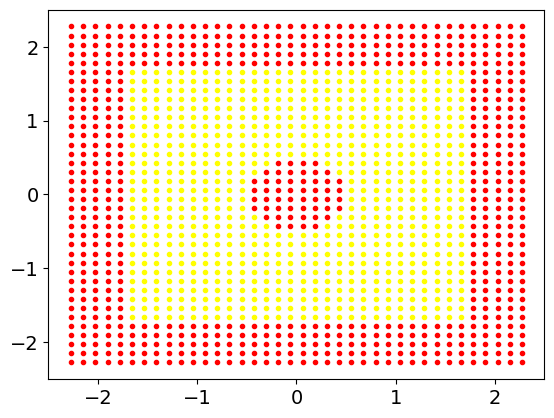

spacing: 0.12297297297297297


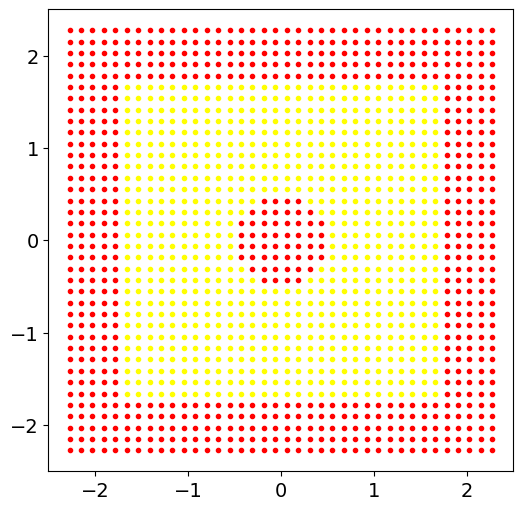

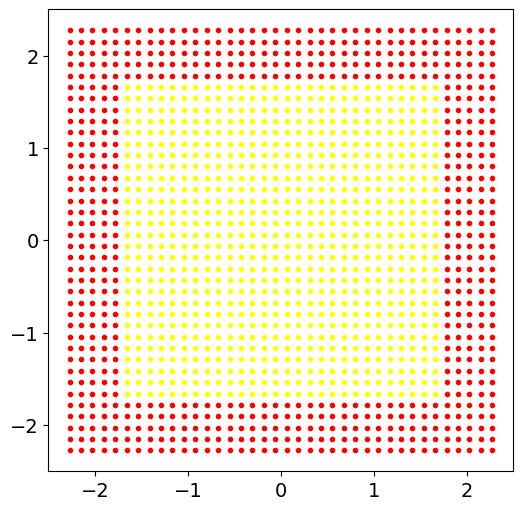

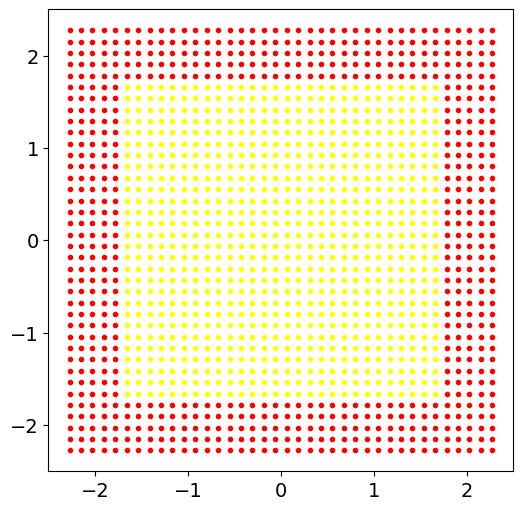

In [33]:
#########################
### Data Construction ###
#########################

width         = 3.5
density       = 72
unsafe_margin = 0.3
thn           = 24

# make grid and obstacles
obs_funcs = []
grid, params, obs_dict, is_obs_grid = make_rectangle(height=width, width=width, density=density, unsafe_margin=unsafe_margin, center=(0,0), return_params=True)
#obs_dict = insert_shape(np.array([0,  1.5]), grid, obs_dict, shape='circle', scale=0.75, theta=0)
obs_dict, is_obs_circ = insert_shape(np.array([0, 0]), grid, obs_dict, shape='circle', scale=0.50, theta=0)
obstacles = np.array([pt for pt in grid if obs_dict[tuple(np.round(pt, 3))] != 0])
obs_funcs.append(is_obs_grid)
obs_funcs.append(is_obs_circ)

from data import check_obs
for pt in grid:
    if check_obs(pt, obs_funcs):
        plt.plot(pt[0], pt[1], marker='.', color="r", linestyle="none")
    else:
        plt.plot(pt[0], pt[1], marker='.', color="yellow", linestyle="none")
plt.show()

# grids for centers and unsafe samples
c_grid, c_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))


# initialize hjb grid
lo, hi, n, spacing = params
print("spacing:", spacing)
lo = jnp.array(lo + (0       ,))
hi = jnp.array(hi + (2*jnp.pi,))
n  = jnp.array(n  + (thn     ,))

hjb_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo, hi), n, periodic_dims=2)

plot_data(  grid,   obs_dict, size=6)
plot_data(c_grid, c_obs_dict, size=6)
plot_data(s_grid, s_obs_dict, size=6)

(1444, 2)
(38, 38, 24)


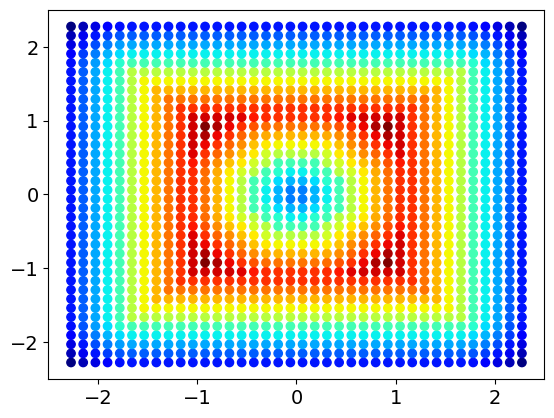

In [34]:
#####################################
### Make Signed Distance Function ###
#####################################

l = np.empty(hjb_grid.states.shape[:-1])

obs_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] != 0])
fre_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] == 0])

for i in range(n[0]):
    for j in range(n[1]):
        for k in range(n[2]):
            if obs_dict[tuple(np.round(np.array(hjb_grid.states[i, j, k, :-1]), 3))] != 0:
                l[i, j, k] = -np.min(np.linalg.norm(fre_coords - hjb_grid.states[i, j, k, :2], axis=1))
            else:
                l[i, j, k] =  np.min(np.linalg.norm(obs_coords - hjb_grid.states[i, j, k, :2], axis=1))

print(grid.shape)
print(l.shape)
plt.scatter(grid[:,0], grid[:,1], c=l[...,0].reshape(-1, 1))
plt.show()

In [35]:
############################
### Configure HJB Solver ###
############################

gamma  = 0.20
cbvf   = True
umax   = 0.40
utype  ="box"
V      = 0.10
l      = jnp.array(l)
values = l 
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube,
                                                  value_postprocessor      =hj.solver.static_obstacle(l))

In [36]:
####################################
### Solver PDE for final surface ###
####################################

dynamics = hj.systems.Bicycle(gamma=gamma, V=V, umax=umax)
time = 0.
target_time = -500
target_values = hj.step(solver_settings, dynamics, hjb_grid, time, values, target_time)

100%|##############################| 500.0000/500.0 [00:04<00:00, 112.25sim_s/s]


<Figure size 640x480 with 0 Axes>

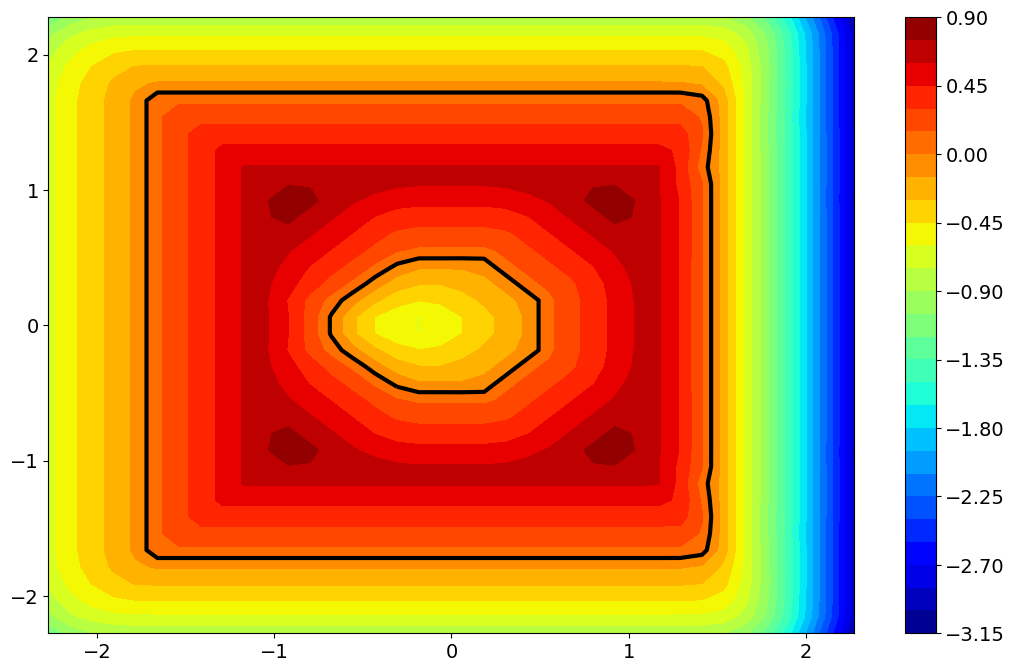

In [37]:
##########################
### Plot final surface ###
##########################

plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(hjb_grid.coordinate_vectors[0], hjb_grid.coordinate_vectors[1], target_values[:, :, 0].T, levels=30)
plt.colorbar()
plt.contour(hjb_grid.coordinate_vectors[0],
            hjb_grid.coordinate_vectors[1],
            target_values[:, :, 0].T,
            levels=0,
            colors="black",
            linewidths=3)

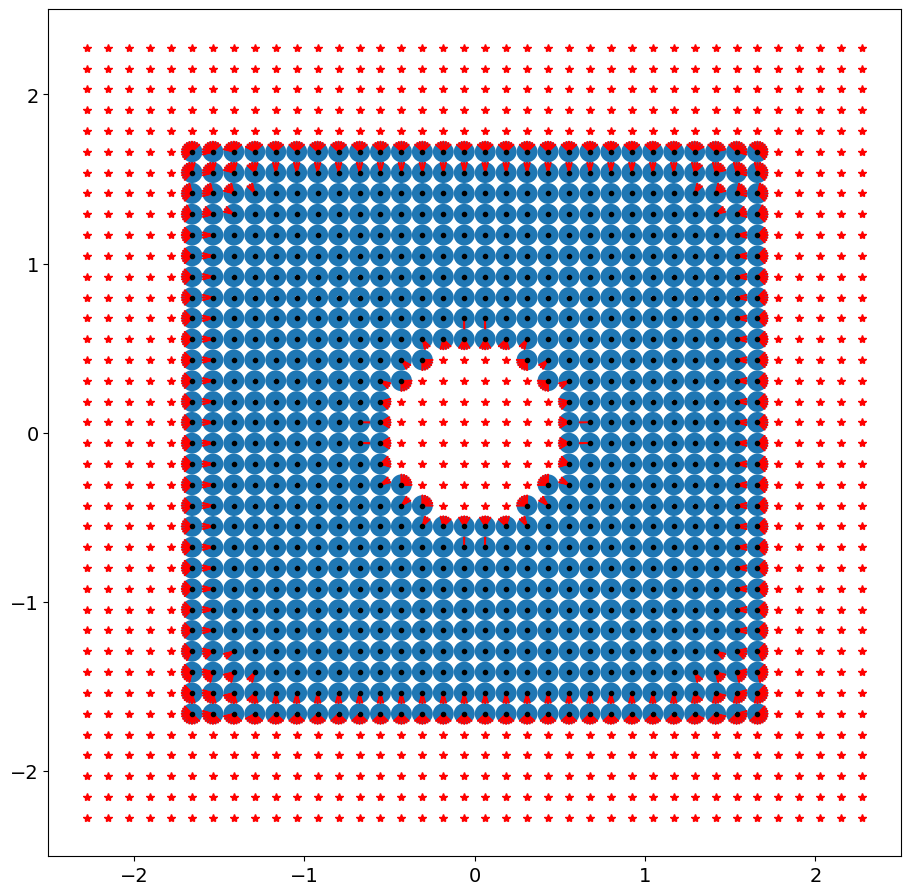

In [38]:
#######################################
### Plot V at each x,y using arrows ###
#######################################
ddegrees = 2

fig, ax = plt.subplots(figsize=(11,11))

plt.rc('xtick', labelsize=14)                                                
plt.rc('ytick', labelsize=14)                                                

for x in grid:                                                               
    if obs_dict[tuple(np.round(x, 3))] == 0:                               
        ax.plot(x[0], x[1], color="black", marker=".", linestyle="none")   
        A = pat.Annulus(x, spacing/2, spacing/2-0.01)
        ax.add_patch(A)
        pt = np.array([x[0], x[1], 0])
        idx = hjb_grid.nearest_index(pt)[:2]
        for i, Vtheta in enumerate(target_values[idx[0], idx[1]]):
            theta = hjb_grid.states[idx[0], idx[1], i][-1]
            if Vtheta <= 0:
                B = pat.Wedge(x, spacing/2, 360/(2*np.pi)*theta - ddegrees, 360/(2*np.pi)*theta + ddegrees, width=spacing/2, color='r')  
                ax.add_patch(B)
            #else:
            #    B = pat.Wedge(  x, s/2, 360/(2*np.pi)*theta - 1, 360/(2*np.pi)*theta + 1, width=s/2, color='b')  
            #    ax.add_patch(B)
    else:
        ax.plot(x[0], x[1], color="red"   , marker="*", linestyle="none") 

plt.show()

In [39]:
##############################
### Plot V(x, y, theta(t)) ###
##############################

vmin, vmax = target_values.min(), target_values.max()
levels = np.linspace(round(vmin), round(vmax), 5*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 target_values[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, target_values.shape[-1], interval=50).to_html5_video())
plt.close(); animation

In [40]:
##########################################
### Solve for backwards reachable tube ###
##########################################

times = np.linspace(0, -500, 100)
initial_values = l
all_values = hj.solve(solver_settings, dynamics, hjb_grid, times, initial_values)

100%|##############################| 500.0000/500.0 [00:04<00:00, 103.94sim_s/s]


In [41]:
##########################################
### Visualize backwards reachable tube ###
##########################################

vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), 15*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 all_values[i, :, :, 10].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, 10].T,
                levels=0,
                colors="black",
                linewidths=3)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

In [98]:
###########################
### Agent Configuration ###
###########################

bf    = 31    # csrbf order
b     =-0.5   # offset (-0.5)
s     = 0.90  #0.75# csrbf zeroing
nm    = 0.20  # nm * n_safe = number of neighbors to consider
pct   = 0.35  # num neighber percentile under which boundary
mult  = 4
utype = utype # defined w/ hjb above
umax  = umax  # defined w/ hjb above
gamma = gamma # defined w/ hjb above
solver        ='CLARABEL'
sensor_radius = 1.1
rx            = sensor_radius + 0.2 # sample radius
rc            = sensor_radius # radius around scan in which centers are chosen
init_x        =-1.1
init_y        =-1.1
init_theta    = 0

a = Agent(dynamics, np.array([init_x, init_y, init_theta]), grid, obs_dict, width         = width, 
                                                                            sensor_radius = sensor_radius,
                                                                            bf            = bf, 
                                                                            b             = b, 
                                                                            s             = s,
                                                                            utype         = utype,
                                                                            umax          = umax,
                                                                            gamma         = gamma,
                                                                            solver        = solver,
                                                                            spacing       = spacing,
                                                                            obstacles     = obstacles)

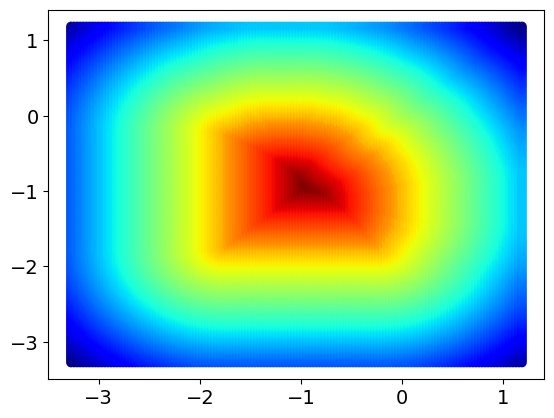

100%|#################################| 10.0000/10.0 [00:02<00:00,  3.55sim_s/s]


<Figure size 640x480 with 0 Axes>

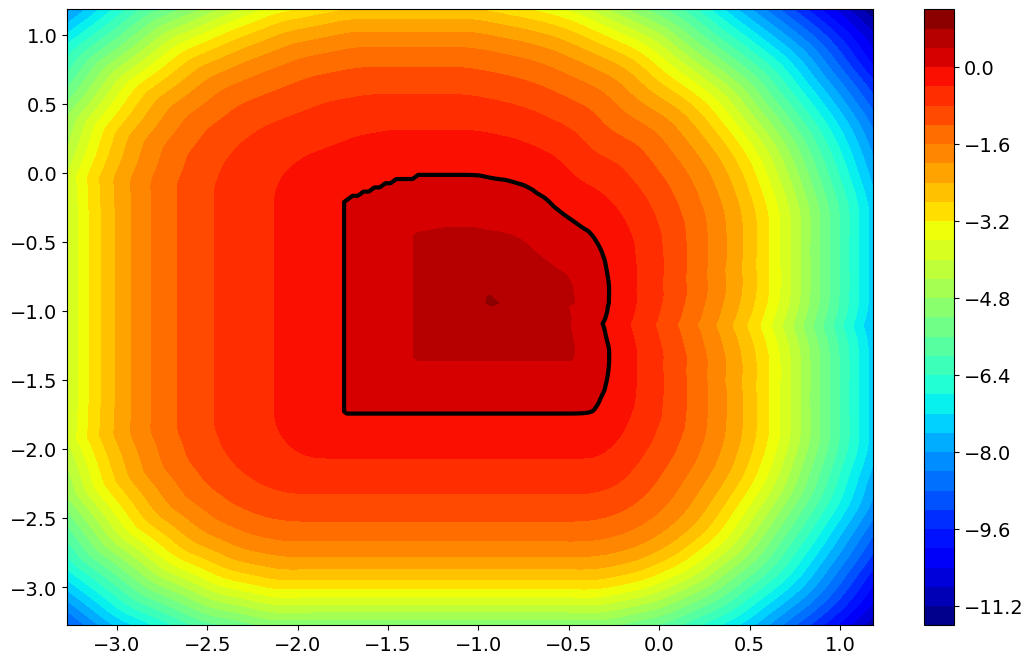

In [99]:
####################
### Initial scan ###
####################

# scan states 
pts_safe, pts_unsafe,\
             in_scan_f = a.scan(ret_in_scan_f=True) 
scan_funcs = [in_scan_f]
samples, gparams,\
is_obs_sample, x2pi_samp, x0_samp = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True, bicycle=True, boundary_condition=True)
sample_funcs = [is_obs_sample]
loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], thn, rx=rx, T=10, mult=mult, extension=1.0)

In [100]:
vmin, vmax = loc_V.min(), loc_V.max()
#levels = np.linspace(round(vmin), round(vmax), 10*(round(vmax) - round(vmin) + 1))
levels = np.linspace(vmin, vmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(loc_hjb_grid.coordinate_vectors[0],
                 loc_hjb_grid.coordinate_vectors[1],
                 loc_V[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(loc_hjb_grid.coordinate_vectors[0],
                loc_hjb_grid.coordinate_vectors[1],
                loc_V[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, loc_V.shape[-1], interval=50).to_html5_video())
plt.close()
animation

In [101]:
##################################
### Configure Safe Exploration ###
##################################

DT   = 0.05   # numerical integration timestep
tol  =-1.0    # h-value at which to halt approach
eps  = 0
dx   = 0.5     # if |x'-x|<dx, approach again
tend = 90     # Duration of boundary approach
T    = 0.3     # MPC horizon (default timestep is 0.05)
N    = 3       # number of CBFs to learn

target: [ 1 -1  0]
position is [-1.1 -1.1  0. ]
V is 0.65175784
start time is 90


  0%|                                          | 1/1800 [00:00<03:19,  9.01it/s]

grad [0.5000007 0.5000007 0.       ]
grad [0.41841948 0.5815819  0.        ]


  0%|                                          | 4/1800 [00:00<03:15,  9.18it/s]

grad [0.34230864 0.6576927  0.        ]
grad [0.28782758 0.7121733  0.        ]


  0%|▏                                         | 6/1800 [00:00<03:15,  9.20it/s]

grad [0.23312011 0.7668804  0.        ]
grad [0.17740664 0.8225932  0.        ]


  0%|▏                                         | 8/1800 [00:00<03:16,  9.10it/s]

grad [0.1199013 0.8800981 0.       ]
grad [0.05984101 0.9401578  0.        ]


  1%|▏                                        | 10/1800 [00:01<03:21,  8.89it/s]

grad [0.        0.9999982 0.       ]
grad [0.         0.99999815 0.        ]


  1%|▎                                        | 12/1800 [00:01<03:28,  8.56it/s]

grad [0.        0.9999981 0.       ]
grad [0.         0.99999785 0.        ]


  1%|▎                                        | 14/1800 [00:01<03:25,  8.70it/s]

grad [0.         0.99999774 0.        ]
grad [0.         0.99999756 0.        ]


  1%|▎                                        | 16/1800 [00:01<03:26,  8.63it/s]

grad [2.2473076e-04 9.9977285e-01 0.0000000e+00]
grad [0.        0.9999975 0.       ]


  1%|▍                                        | 18/1800 [00:02<03:18,  8.97it/s]

grad [0.        0.9999975 0.       ]
grad [0.         0.99999756 0.        ]


  1%|▍                                        | 20/1800 [00:02<03:08,  9.44it/s]

grad [0.        0.9999975 0.       ]
grad [0.         0.99999756 0.        ]
grad [0.        0.9999975 0.       ]


  1%|▌                                        | 23/1800 [00:02<03:01,  9.79it/s]

grad [0.         0.99999744 0.        ]
grad [0.        0.9999975 0.       ]
grad [0.        0.9999975 0.       ]


  1%|▌                                        | 26/1800 [00:02<02:58,  9.94it/s]

grad [0.         0.99999744 0.        ]
grad [0.         0.99999756 0.        ]
grad [0.        0.9999975 0.       ]


  2%|▋                                        | 29/1800 [00:03<03:04,  9.60it/s]

grad [0.        0.9999975 0.       ]
grad [0.         0.99999756 0.        ]


  2%|▋                                        | 31/1800 [00:03<03:15,  9.07it/s]

grad [0.         0.99999756 0.        ]
grad [0.         0.99999756 0.        ]


  2%|▊                                        | 33/1800 [00:03<03:21,  8.76it/s]

grad [0.         0.99999756 0.        ]
grad [0.        0.9999975 0.       ]


  2%|▊                                        | 35/1800 [00:03<03:16,  8.96it/s]

grad [0.         0.99999756 0.        ]
grad [0.         0.99999785 0.        ]


  2%|▊                                        | 36/1800 [00:03<03:19,  8.83it/s]

grad [0.        0.9999981 0.       ]


  2%|▊                                        | 38/1800 [00:04<06:16,  4.67it/s]

grad [0.        0.9999983 0.       ]
grad [0.        0.9999986 0.       ]


  2%|▉                                        | 40/1800 [00:04<04:46,  6.15it/s]

grad [0.        0.9999988 0.       ]
grad [0.         0.99999917 0.        ]


  2%|▉                                        | 42/1800 [00:05<03:58,  7.37it/s]

grad [0.        0.9999993 0.       ]
grad [0.        0.9999996 0.       ]


  2%|█                                        | 44/1800 [00:05<03:28,  8.43it/s]

grad [0.        0.9999998 0.       ]
grad [0. 1. 0.]


  3%|█                                        | 46/1800 [00:05<03:11,  9.18it/s]

grad [0.        1.0000004 0.       ]
grad [0.        1.0000006 0.       ]
grad [0.        1.0000008 0.       ]


  3%|█                                        | 49/1800 [00:05<03:04,  9.51it/s]

grad [0.        1.0000011 0.       ]
grad [0.        1.0000013 0.       ]


  3%|█▏                                       | 51/1800 [00:06<03:11,  9.13it/s]

grad [0.        1.0000015 0.       ]
grad [0.        1.0000018 0.       ]


  3%|█▏                                       | 53/1800 [00:06<03:17,  8.85it/s]

grad [0.       1.000002 0.      ]
grad [0.        1.0000023 0.       ]


  3%|█▎                                       | 55/1800 [00:06<03:16,  8.89it/s]

grad [0.        0.9995272 0.       ]
grad [0.         0.99562347 0.        ]


  3%|█▎                                       | 57/1800 [00:06<03:10,  9.16it/s]

grad [0.       0.987802 0.      ]
grad [0.         0.97608495 0.        ]


  3%|█▎                                       | 59/1800 [00:06<03:08,  9.22it/s]

grad [0.        0.9604646 0.       ]
grad [0.        0.9409372 0.       ]


  3%|█▍                                       | 61/1800 [00:07<03:17,  8.80it/s]

grad [-0.00180179  0.9170126   0.        ]
grad [-0.01610943  0.8853985   0.        ]


  4%|█▍                                       | 63/1800 [00:07<03:11,  9.06it/s]

grad [-0.03412405  0.8487701   0.        ]
grad [-0.0558471   0.80712557  0.        ]


  4%|█▍                                       | 65/1800 [00:07<03:07,  9.24it/s]

grad [-0.08127575  0.76047075  0.        ]
grad [-0.11041243  0.70880026  0.        ]


  4%|█▌                                       | 67/1800 [00:07<03:05,  9.35it/s]

grad [-0.14315577  0.65238607  0.        ]
grad [-0.20490846  0.5818077   0.        ]


  4%|█▌                                       | 69/1800 [00:08<03:11,  9.05it/s]

grad [-0.27842698  0.507368    0.        ]
grad [-0.35755602  0.43181962  0.        ]


  4%|█▌                                       | 71/1800 [00:08<03:11,  9.02it/s]

grad [-0.44228327  0.35517383  0.        ]
grad [-0.53261435  0.27742395  0.        ]


  4%|█▋                                       | 73/1800 [00:08<03:09,  9.09it/s]

grad [-0.6285502   0.19856732  0.        ]
grad [-0.71485287  0.11756525  0.        ]


  4%|█▋                                       | 75/1800 [00:08<03:08,  9.15it/s]

grad [-0.7823486   0.03708372  0.        ]
grad [-0.82713854 -0.03588305  0.        ]


  4%|█▊                                       | 77/1800 [00:09<06:19,  4.54it/s]

grad [-0.86555296 -0.10070106  0.        ]
grad [-0.9037733  -0.15820727  0.        ]


  4%|█▊                                       | 79/1800 [00:09<04:37,  6.20it/s]

grad [-0.9410353  -0.20835955  0.        ]
grad [-9.7694016e-01 -2.4743789e-01  1.1475944e-06]


  4%|█▊                                       | 81/1800 [00:09<03:47,  7.57it/s]

grad [-9.991430e-01 -2.579178e-01  2.902386e-05]
grad [-1.0292226e+00 -2.6766571e-01  2.5804326e-05]
grad [-1.0524951e+00 -2.7525857e-01  1.0772783e-04]


  5%|█▉                                       | 83/1800 [00:10<03:25,  8.35it/s]

grad [-1.0912244e+00 -2.8264171e-01  6.4622276e-05]
grad [-1.1183885e+00 -2.8777215e-01  1.8286127e-04]
grad [-1.1665162e+00 -2.9237619e-01  6.6460067e-05]


  5%|█▉                                       | 87/1800 [00:10<03:04,  9.29it/s]

grad [-1.1925046e+00 -3.1072462e-01  4.9765618e-04]
grad [-1.2483199e+00 -3.3190921e-01  1.0449312e-04]
grad [-1.2712829e+00 -3.5340610e-01  1.1172043e-03]


  5%|██                                       | 89/1800 [00:10<02:59,  9.53it/s]

grad [-1.3245841e+00 -3.7251449e-01  5.3764699e-04]
grad [-1.344355   -0.39474523  0.0023003 ]
grad [-1.3620902  -0.4188271   0.00476498]


  5%|██                                       | 93/1800 [00:11<02:53,  9.85it/s]

grad [-1.3675317  -0.44162068  0.00871896]
grad [-1.3618835  -0.46587226  0.01404223]
grad [-1.35766   -0.4969297  0.0199371]


  5%|██▏                                      | 96/1800 [00:11<02:50,  9.97it/s]

grad [-1.354397   -0.5334548   0.02619489]
grad [-1.3474984 -0.5639536  0.0314621]
grad [-1.3438982  -0.5968803   0.03754069]


  5%|██▏                                      | 98/1800 [00:11<02:49, 10.03it/s]

grad [-1.3436377  -0.6311316   0.04459419]
grad [-1.3367634  -0.667671    0.05272716]
grad [-1.3339503  -0.70597416  0.06209308]


  6%|██▎                                     | 102/1800 [00:11<02:50,  9.98it/s]

grad [-1.3368068  -0.74496466  0.07291296]
grad [-1.3333467  -0.7400712   0.07897662]
grad [-1.3230038  -0.7046026   0.08158418]


  6%|██▎                                     | 105/1800 [00:12<02:49, 10.03it/s]

grad [-1.3119848  -0.66584367  0.08460023]
grad [-1.2997772  -0.6242493   0.08813003]
grad [-1.2824153  -0.59171635  0.092291  ]


  6%|██▍                                     | 107/1800 [00:12<02:48, 10.04it/s]

grad [-1.2664393  -0.56396824  0.09726898]
grad [-1.2446294  -0.54840374  0.1019127 ]
grad [-1.226538   -0.5389846   0.10656503]


  6%|██▍                                     | 111/1800 [00:12<02:47, 10.06it/s]

grad [-1.2136695  -0.53245384  0.11142144]
grad [-1.2054129  -0.52784     0.11646739]
grad [-1.2013223  -0.5245196   0.12169262]


  6%|██▌                                     | 113/1800 [00:13<02:48, 10.02it/s]

grad [-1.2001945  -0.52567375  0.12698227]
grad [-1.1997738  -0.53941107  0.13221504]
grad [-1.2015693  -0.556595    0.13778092]


  6%|██▌                                     | 117/1800 [00:13<02:47, 10.07it/s]

grad [-1.2050879  -0.5775817   0.14372751]
grad [-1.207082   -0.6072471   0.14977358]
grad [-1.1984239  -0.6572219   0.15486073]


  7%|██▋                                     | 120/1800 [00:13<02:52,  9.74it/s]

grad [-1.1923064  -0.7046149   0.16056003]
grad [-1.1892779  -0.7491865   0.16686432]


  7%|██▋                                     | 122/1800 [00:13<02:54,  9.64it/s]

grad [-1.1890529 -0.791608   0.1736486]
grad [-1.1862836  -0.8386878   0.18036814]


  7%|██▊                                     | 124/1800 [00:14<02:52,  9.70it/s]

grad [-1.1889094  -0.86439526  0.18123761]
grad [-1.1928766  -0.8778813   0.17913671]


  7%|██▊                                     | 125/1800 [00:14<02:53,  9.67it/s]

grad [-1.1961226  -0.8879242   0.17665516]


  7%|██▊                                     | 126/1800 [00:14<06:31,  4.27it/s]

grad [-1.1929561  -0.8956211   0.17460889]
grad [-1.1856357  -0.9014359   0.17333253]


  7%|██▊                                     | 129/1800 [00:15<04:24,  6.32it/s]

grad [-1.1808037 -0.9053953  0.1721742]
grad [-1.1782868  -0.90813166  0.17111726]


  7%|██▉                                     | 131/1800 [00:15<03:41,  7.54it/s]

grad [-1.177109   -0.91061956  0.17014161]
grad [-1.173268   -0.9146157   0.16920552]


  7%|██▉                                     | 133/1800 [00:15<03:17,  8.44it/s]

grad [-1.1707329  -0.91811454  0.16827208]
grad [-1.1693994  -0.92123663  0.16733073]


  8%|███                                     | 135/1800 [00:15<03:02,  9.11it/s]

grad [-1.161377   -0.91945535  0.16627267]
grad [-1.1509445  -0.91552395  0.16562228]


  8%|███                                     | 137/1800 [00:15<02:57,  9.38it/s]

grad [-1.1416533  -0.9117843   0.16547197]
grad [-1.1332942  -0.90826     0.16574174]


  8%|███                                     | 139/1800 [00:16<03:06,  8.89it/s]

grad [-1.1256673  -0.904954    0.16635145]
grad [-1.1185732  -0.9018651   0.16722283]


  8%|███▏                                    | 141/1800 [00:16<03:08,  8.78it/s]

grad [-1.1087674  -0.9044861   0.16903758]
grad [-1.0975313  -0.9044524   0.16996904]


  8%|███▏                                    | 143/1800 [00:16<03:14,  8.51it/s]

grad [-1.0859721  -0.9042583   0.17028712]
grad [-1.074978   -0.90576214  0.17020455]


  8%|███▏                                    | 145/1800 [00:16<03:23,  8.15it/s]

grad [-1.0643647  -0.90907365  0.16971219]
grad [-1.0539525  -0.91431594  0.16879693]


  8%|███▎                                    | 147/1800 [00:17<03:19,  8.29it/s]

grad [-1.0435705 -0.9216137  0.1674396]
grad [-1.0330452  -0.93110895  0.1656147 ]


  8%|███▎                                    | 149/1800 [00:17<03:16,  8.39it/s]

grad [-1.0217496  -0.9331813   0.16383943]
grad [-1.0102046  -0.9337029   0.16187084]


  8%|███▎                                    | 151/1800 [00:17<03:04,  8.94it/s]

grad [-0.9987947  -0.9350936   0.15955912]
grad [-0.98771083 -0.9371678   0.15685387]


  8%|███▍                                    | 153/1800 [00:17<02:57,  9.27it/s]

grad [-0.9771323  -0.93974674  0.1537025 ]
grad [-0.9672295  -0.9426598   0.15005074]


  9%|███▍                                    | 155/1800 [00:18<02:54,  9.44it/s]

grad [-0.95729506 -0.9441783   0.14587353]
grad [-0.94482994 -0.94293016  0.14133845]


  9%|███▍                                    | 157/1800 [00:18<02:53,  9.47it/s]

grad [-0.93150187 -0.9418223   0.13711946]
grad [-0.92108434 -0.9383895   0.13644817]


  9%|███▌                                    | 159/1800 [00:18<02:54,  9.42it/s]

grad [-0.9102836 -0.936252   0.1357016]
grad [-0.89990914 -0.9346517   0.13483231]


  9%|███▌                                    | 161/1800 [00:18<02:54,  9.37it/s]

grad [-0.8900117  -0.93394077  0.13370055]
grad [-0.8831674  -0.9299369   0.13151194]


  9%|███▌                                    | 162/1800 [00:19<07:32,  3.62it/s]

grad [-0.87443113 -0.92828465  0.12949885]
grad [-0.8639013  -0.92882997  0.12763108]
grad [-0.85165584 -0.9314433   0.12588005]


  9%|███▋                                    | 166/1800 [00:19<04:14,  6.43it/s]

grad [-0.8377522  -0.9360192   0.12421851]
grad [-0.8222282  -0.94247717  0.12262165]
grad [-0.8153661  -0.93728834  0.11920166]


  9%|███▋                                    | 168/1800 [00:19<03:37,  7.50it/s]

grad [-0.80872667 -0.93223023  0.11541403]
grad [-0.8015527  -0.9282421   0.11136726]
grad [-0.7938003  -0.9252734   0.10702816]


 10%|███▊                                    | 171/1800 [00:20<03:08,  8.66it/s]

grad [-0.78542477 -0.92326224  0.10235374]
grad [-0.7768031  -0.922458    0.09778804]
grad [-0.7726826  -0.9165065   0.09483024]


 10%|███▉                                    | 175/1800 [00:20<02:51,  9.45it/s]

grad [-0.76891    -0.9096533   0.09164885]
grad [-0.7649365  -0.90317154  0.0883451 ]


 10%|███▉                                    | 177/1800 [00:20<02:48,  9.62it/s]

grad [-0.76077807 -0.8969847   0.0849168 ]
grad [-0.75646573 -0.89097476  0.08136136]


 10%|███▉                                    | 178/1800 [00:20<02:46,  9.72it/s]

grad [-0.7520474  -0.8849837   0.07767657]
grad [-0.74735636 -0.87696075  0.07399747]
grad [-0.74295723 -0.8680554   0.07022923]


 10%|████                                    | 181/1800 [00:21<02:45,  9.80it/s]

grad [-0.73898983 -0.8588204   0.06635679]
grad [-0.73546815 -0.84927714  0.06240391]
grad [-0.7324064  -0.83945036  0.0583971 ]


 10%|████                                    | 184/1800 [00:21<02:42,  9.92it/s]

grad [-0.7298271  -0.8293667   0.05436829]
grad [-0.7273828  -0.81942356  0.05060291]
grad [-0.7254162  -0.8093182   0.04702408]


 10%|████▏                                   | 187/1800 [00:21<02:42,  9.94it/s]

grad [-0.724341   -0.79899216  0.04354171]
grad [-0.72429764 -0.7887293   0.04014686]
grad [-0.7262095 -0.7795775  0.0375719]


 11%|████▏                                   | 191/1800 [00:22<02:39, 10.07it/s]

grad [-0.73070985 -0.7722727   0.03639007]
grad [-0.73490024 -0.7658796   0.03550962]
grad [-0.7375968  -0.76118827  0.03503934]


 11%|████▎                                   | 193/1800 [00:22<02:39, 10.10it/s]

grad [-0.74053085 -0.7568563   0.03470173]
grad [-0.7435571  -0.75298214  0.0344914 ]
grad [-0.7465461 -0.7496416  0.034399 ]


 11%|████▍                                   | 197/1800 [00:22<02:38, 10.13it/s]

grad [-0.7493842  -0.74689054  0.03441182]
grad [-0.7519279  -0.74479437  0.03451334]
grad [-0.7514106  -0.74464124  0.0345052 ]


 11%|████▍                                   | 199/1800 [00:23<02:39, 10.06it/s]

grad [-0.75077313 -0.7442089   0.03438538]
grad [-0.7500217  -0.7435089   0.03416052]
grad [-0.7491609  -0.74255127  0.03383658]


 11%|████▌                                   | 203/1800 [00:23<02:38, 10.10it/s]

grad [-0.74819344 -0.74134594  0.0334188 ]
grad [-0.74712163 -0.7399019   0.03291193]


 11%|████▌                                   | 205/1800 [00:24<04:36,  5.78it/s]

grad [-0.7466599  -0.738632    0.03272372]
grad [-0.74655604 -0.73759645  0.03282046]


 12%|████▌                                   | 207/1800 [00:24<03:58,  6.69it/s]

grad [-0.7464256  -0.73664415  0.03298509]
grad [-0.74653137 -0.7359028   0.03321576]


 12%|████▋                                   | 209/1800 [00:24<03:28,  7.64it/s]

grad [-0.7465542  -0.7350525   0.03336827]
grad [-0.746488   -0.73409     0.03344223]


 12%|████▋                                   | 211/1800 [00:24<03:07,  8.48it/s]

grad [-0.74638325 -0.73305535  0.03347737]
grad [-0.74660546 -0.73217845  0.03373658]


 12%|████▋                                   | 213/1800 [00:24<02:54,  9.07it/s]

grad [-0.74683326 -0.73118085  0.03398966]
grad [-0.7470812  -0.7300762   0.03424257]


 12%|████▊                                   | 215/1800 [00:25<02:48,  9.39it/s]

grad [-0.74736315 -0.7288768   0.03450087]
grad [-0.74769217 -0.7275936   0.03476974]


 12%|████▊                                   | 217/1800 [00:25<02:45,  9.58it/s]

grad [-0.7480809 -0.726236   0.0350541]
grad [-0.74936026 -0.72417283  0.03562983]


 12%|████▊                                   | 219/1800 [00:25<02:42,  9.75it/s]

grad [-0.751391   -0.7215912   0.03630855]
grad [-0.7536754  -0.71890557  0.03689934]


 12%|████▉                                   | 220/1800 [00:25<02:41,  9.80it/s]

grad [-0.7562054  -0.71610826  0.03740337]
grad [-0.75897664 -0.7131914   0.03782205]
grad [-0.76198864 -0.71014804  0.03815799]


 12%|████▉                                   | 224/1800 [00:26<02:40,  9.83it/s]

grad [-0.7672629  -0.7046079   0.03869634]
grad [-0.77954715 -0.6921676   0.0410164 ]
grad [-0.7920467  -0.6804789   0.04394973]


 13%|█████                                   | 227/1800 [00:26<02:40,  9.81it/s]

grad [-0.80438256 -0.6698434   0.04745762]
grad [-0.8162519  -0.66044366  0.05147577]


 13%|█████                                   | 229/1800 [00:26<02:40,  9.80it/s]

grad [-0.8274388  -0.65236074  0.055931  ]
grad [-0.83780456 -0.64560074  0.06075049]


 13%|█████▏                                  | 231/1800 [00:26<02:41,  9.71it/s]

grad [-0.8449524  -0.64658237  0.06704074]
grad [-0.84761614 -0.65769863  0.07485126]


 13%|█████▏                                  | 232/1800 [00:26<02:41,  9.68it/s]

grad [-0.84876204 -0.670041    0.08234952]


 13%|█████▏                                  | 233/1800 [00:27<06:19,  4.13it/s]

grad [-0.8487374  -0.68310803  0.08953114]
grad [-0.8478295  -0.69653964  0.09639587]
grad [-0.8462789  -0.71007967  0.10294485]


 13%|█████▎                                  | 237/1800 [00:27<03:49,  6.82it/s]

grad [-0.8442894  -0.7235569   0.10918257]
grad [-0.8204075  -0.76494795  0.11761626]
grad [-0.7925774  -0.80586123  0.12500189]


 13%|█████▎                                  | 240/1800 [00:28<03:09,  8.21it/s]

grad [-0.76168376 -0.8471071   0.13128914]
grad [-0.73048884 -0.88473153  0.13618183]


 13%|█████▍                                  | 242/1800 [00:28<02:54,  8.91it/s]

grad [-0.69870156 -0.9188557   0.13976464]
grad [-0.6658374  -0.95006454  0.14213097]


 14%|█████▍                                  | 243/1800 [00:28<02:49,  9.16it/s]

grad [-0.6384297  -0.9774955   0.14320908]
grad [-0.62569785 -0.9986557   0.14297396]
grad [-0.61205727 -1.0164053   0.14190237]


 14%|█████▍                                  | 247/1800 [00:28<02:42,  9.53it/s]

grad [-0.59758997 -1.0304332   0.13995278]
grad [-0.5824196  -1.0403426   0.13707034]


 14%|█████▌                                  | 249/1800 [00:29<02:42,  9.57it/s]

grad [-0.566707   -1.0456661   0.13318951]
grad [-0.55064666 -1.0458865   0.12823907]


 14%|█████▌                                  | 251/1800 [00:29<02:40,  9.65it/s]

grad [-0.5418891  -1.0409281   0.12378089]
grad [-0.5411061  -1.0464042   0.12366521]


 14%|█████▌                                  | 253/1800 [00:29<02:38,  9.75it/s]

grad [-0.54147774 -1.0497386   0.12308744]
grad [-0.54503596 -1.0491892   0.12188499]


 14%|█████▋                                  | 255/1800 [00:29<02:37,  9.80it/s]

grad [-0.5474644  -1.0473887   0.12028854]
grad [-0.5490453  -1.0440729   0.11827976]


 14%|█████▋                                  | 257/1800 [00:29<02:37,  9.81it/s]

grad [-0.55005544 -1.0389891   0.1158441 ]
grad [-0.550761   -1.0336748   0.11326052]


 14%|█████▊                                  | 259/1800 [00:30<02:38,  9.72it/s]

grad [-0.5521231  -1.0307089   0.11110076]
grad [-0.5548841  -1.0251206   0.10866524]


 14%|█████▊                                  | 261/1800 [00:30<02:38,  9.73it/s]

grad [-0.55939275 -1.016881    0.10602817]
grad [-0.5659479  -1.0060802   0.10328971]


 15%|█████▊                                  | 263/1800 [00:30<02:40,  9.60it/s]

grad [-0.57477593 -0.9929631   0.10058048]
grad [-0.5830326 -0.9818845  0.0990707]


 15%|█████▉                                  | 265/1800 [00:30<02:40,  9.54it/s]

grad [-0.590613   -0.97135735  0.09815383]
grad [-0.59152794 -0.96923256  0.09900925]


 15%|█████▉                                  | 267/1800 [00:30<02:41,  9.52it/s]

grad [-0.5861027  -0.9744288   0.10116515]
grad [-0.57853204 -0.98059356  0.10335615]


 15%|█████▉                                  | 269/1800 [00:31<02:41,  9.51it/s]

grad [-0.5684687  -0.9878208   0.10553275]
grad [-0.5555699  -0.99616665  0.10763601]


 15%|██████                                  | 271/1800 [00:31<02:40,  9.54it/s]

grad [-0.5394717  -1.0056663   0.10960007]
grad [-0.5197818  -1.016338    0.11134984]


 15%|██████                                  | 272/1800 [00:31<02:40,  9.52it/s]

grad [-0.49620134 -1.0307155   0.11230613]


 15%|██████                                  | 274/1800 [00:32<05:08,  4.94it/s]

grad [-0.47365442 -1.0470424   0.11215122]
grad [-0.45498353 -1.0623869   0.11127034]


 15%|██████▏                                 | 276/1800 [00:32<03:52,  6.57it/s]

grad [-0.4387219  -1.0774275   0.11068289]
grad [-0.42607388 -1.0977137   0.11243426]


 15%|██████▏                                 | 278/1800 [00:32<03:15,  7.78it/s]

grad [-0.41424647 -1.1142828   0.11337853]
grad [-0.40334663 -1.1273313   0.11354619]


 16%|██████▏                                 | 280/1800 [00:32<02:58,  8.53it/s]

grad [-0.3935234  -1.1370399   0.11296622]
grad [-0.3852942  -1.1427604   0.11173995]


 16%|██████▎                                 | 282/1800 [00:32<02:49,  8.95it/s]

grad [-0.3801407  -1.1409725   0.11050902]
grad [-0.37551352 -1.1420826   0.1095305 ]


 16%|██████▎                                 | 284/1800 [00:33<02:46,  9.11it/s]

grad [-0.3710532  -1.1447529   0.10870494]
grad [-0.3664115  -1.1464585   0.10775706]


 16%|██████▎                                 | 286/1800 [00:33<02:43,  9.28it/s]

grad [-0.36147457 -1.1475692   0.10674969]
grad [-0.35613436 -1.1484299   0.10573891]


 16%|██████▍                                 | 288/1800 [00:33<02:42,  9.32it/s]

grad [-0.35028782 -1.1493607   0.1047741 ]
grad [-0.3423152  -1.1506166   0.10327811]


 16%|██████▍                                 | 290/1800 [00:33<02:41,  9.35it/s]

grad [-0.33158457 -1.1510125   0.10028788]
grad [-0.32126468 -1.1496648   0.09658854]


 16%|██████▍                                 | 292/1800 [00:34<02:39,  9.46it/s]

grad [-0.3114126  -1.1464902   0.09213242]
grad [-0.30267245 -1.1441132   0.08721204]


 16%|██████▌                                 | 294/1800 [00:34<02:39,  9.44it/s]

grad [-0.2948437  -1.1423559   0.08203588]
grad [-0.28725827 -1.1369803   0.0761858 ]


 16%|██████▌                                 | 296/1800 [00:34<02:40,  9.39it/s]

grad [-0.28101498 -1.1268114   0.06968211]
grad [-0.28733426 -1.1055359   0.06343956]


 17%|██████▌                                 | 298/1800 [00:34<02:38,  9.50it/s]

grad [-0.29394203 -1.0941643   0.06148648]
grad [-0.30213088 -1.0844826   0.06065814]


 17%|██████▋                                 | 300/1800 [00:34<02:36,  9.58it/s]

grad [-0.31228524 -1.0741765   0.06012674]
grad [-0.32426164 -1.063454    0.05995281]


 17%|██████▋                                 | 302/1800 [00:35<02:36,  9.60it/s]

grad [-0.3377467  -1.0525723   0.06019379]
grad [-0.34890383 -1.0443815   0.06137026]


 17%|██████▊                                 | 304/1800 [00:35<02:35,  9.63it/s]

grad [-0.33942637 -1.0527416   0.0658128 ]
grad [-0.32887694 -1.0629747   0.07030268]


 17%|██████▊                                 | 306/1800 [00:35<02:34,  9.65it/s]

grad [-0.31655893 -1.0847429   0.07526092]
grad [-0.30337536 -1.1057186   0.07969077]


 17%|██████▊                                 | 308/1800 [00:35<02:36,  9.56it/s]

grad [-0.28914267 -1.1261816   0.08361871]
grad [-0.27367112 -1.1464736   0.08706421]


 17%|██████▉                                 | 310/1800 [00:35<02:35,  9.59it/s]

grad [-0.2567463 -1.163702   0.0888354]
grad [-0.23946917 -1.1735308   0.08796581]


 17%|██████▉                                 | 312/1800 [00:36<02:33,  9.67it/s]

grad [-0.22222783 -1.1808894   0.08657116]
grad [-0.20475489 -1.1858298   0.08464091]


 17%|██████▉                                 | 314/1800 [00:36<02:32,  9.76it/s]

grad [-0.1868073  -1.1883429   0.08215106]
grad [-0.16814098 -1.1883844   0.0790656 ]


 18%|███████                                 | 316/1800 [00:36<02:31,  9.80it/s]

grad [-0.14849304 -1.1858693   0.07533236]
grad [-0.14632407 -1.1730211   0.07069379]


 18%|███████                                 | 318/1800 [00:36<02:32,  9.71it/s]

grad [-0.15240352 -1.1553593   0.06570525]
grad [-0.16031702 -1.136396    0.06069632]


 18%|███████                                 | 320/1800 [00:37<05:02,  4.90it/s]

grad [-0.17064185 -1.1180944   0.05584178]
grad [-0.18712844 -1.1192392   0.05193545]


 18%|███████▏                                | 322/1800 [00:37<03:45,  6.54it/s]

grad [-0.20535883 -1.1223185   0.04843437]
grad [-0.22809839 -1.1243443   0.04619896]


 18%|███████▏                                | 324/1800 [00:37<03:15,  7.57it/s]

grad [-0.25824767 -1.1157165   0.04692782]
grad [-0.28597748 -1.1042024   0.04949841]


 18%|███████▏                                | 326/1800 [00:38<02:57,  8.29it/s]

grad [-0.30972463 -1.0906578   0.05366019]
grad [-0.328599   -1.0753201   0.05901211]


 18%|███████▎                                | 327/1800 [00:38<02:49,  8.70it/s]

grad [-0.34231064 -1.0580497   0.06517522]
grad [-0.35093686 -1.0385566   0.07186826]
grad [-0.32452297 -1.0749962   0.08137496]


 18%|███████▎                                | 331/1800 [00:38<02:34,  9.53it/s]

grad [-0.2953363  -1.1153307   0.08952289]
grad [-0.26706725 -1.1529275   0.09625828]


 18%|███████▍                                | 333/1800 [00:38<02:32,  9.65it/s]

grad [-0.23901716 -1.1890556   0.10190315]
grad [-0.21068422 -1.224601    0.10664959]


 19%|███████▍                                | 335/1800 [00:39<02:30,  9.76it/s]

grad [-0.18164383 -1.2602965   0.11062635]
grad [-0.15289101 -1.2841569   0.11206801]


 19%|███████▍                                | 337/1800 [00:39<02:35,  9.43it/s]

grad [-0.1261599  -1.2891524   0.11037332]
grad [-0.09995203 -1.2898848   0.10788713]


 19%|███████▌                                | 339/1800 [00:39<02:39,  9.14it/s]

grad [-0.07386386 -1.2894044   0.10471964]
grad [-0.0479719  -1.2947516   0.10117958]


 19%|███████▌                                | 341/1800 [00:39<02:43,  8.95it/s]

grad [-0.02250006 -1.2988448   0.097041  ]
grad [ 6.4664200e-04 -1.3014326e+00  9.2293747e-02]


 19%|███████▌                                | 343/1800 [00:39<02:45,  8.79it/s]

grad [ 8.4990339e-04 -1.3057977e+00  8.8845149e-02]
grad [ 9.736501e-04 -1.315423e+00  8.699764e-02]


 19%|███████▋                                | 345/1800 [00:40<02:47,  8.68it/s]

grad [ 1.0541369e-03 -1.3244905e+00  8.5045576e-02]
grad [ 1.0985940e-03 -1.3330134e+00  8.3009839e-02]


 19%|███████▋                                | 347/1800 [00:40<02:49,  8.58it/s]

grad [ 1.1134431e-03 -1.3410251e+00  8.0912463e-02]
grad [ 1.1044584e-03 -1.3485376e+00  7.8772865e-02]


 19%|███████▊                                | 349/1800 [00:40<02:48,  8.62it/s]

grad [ 1.2365037e-03 -1.3555235e+00  7.6613545e-02]
grad [ 1.3533330e-03 -1.3620684e+00  7.4449889e-02]


 20%|███████▊                                | 351/1800 [00:41<05:30,  4.39it/s]

grad [ 0.00143216 -1.3682103   0.07229941]
grad [ 0.00147976 -1.3739834   0.07018006]


 20%|███████▊                                | 353/1800 [00:41<04:12,  5.73it/s]

grad [ 0.001502   -1.3794291   0.06810876]
grad [ 0.00150408 -1.3845801   0.06610064]


 20%|███████▉                                | 355/1800 [00:41<03:31,  6.84it/s]

grad [ 0.00200138 -1.3893387   0.06429005]
grad [ 0.00264556 -1.3938174   0.06258786]


 20%|███████▉                                | 357/1800 [00:42<03:09,  7.63it/s]

grad [ 0.00321852 -1.398087    0.06094853]
grad [ 0.0037259  -1.4021909   0.05938454]


 20%|███████▉                                | 359/1800 [00:42<02:55,  8.20it/s]

grad [ 0.00417369 -1.4061432   0.05790426]
grad [ 0.00456851 -1.4099771   0.05651581]


 20%|████████                                | 361/1800 [00:42<02:51,  8.38it/s]

grad [ 0.00608024 -1.4137399   0.05547158]
grad [ 0.0081824  -1.4173644   0.05464181]


 20%|████████                                | 363/1800 [00:42<02:50,  8.45it/s]

grad [ 0.01008053 -1.4208069   0.05384497]
grad [ 0.01178737 -1.4240906   0.05308867]


 20%|████████                                | 365/1800 [00:42<02:39,  8.98it/s]

grad [ 0.01331862 -1.4272413   0.05238003]
grad [ 0.0146909  -1.4302819   0.05172424]


 20%|████████▏                               | 367/1800 [00:43<02:34,  9.30it/s]

grad [ 0.01633169 -1.4333043   0.05155076]
grad [ 0.01816561 -1.4362727   0.05182772]


 20%|████████▏                               | 369/1800 [00:43<02:30,  9.52it/s]

grad [ 0.01980722 -1.439098    0.05215351]
grad [ 0.021278   -1.4418105   0.05253047]


 21%|████████▏                               | 371/1800 [00:43<02:26,  9.73it/s]

grad [ 0.02259919 -1.444422    0.0529597 ]
grad [ 0.02379022 -1.4469455   0.05344086]
grad [ 0.02503456 -1.4495137   0.05426374]


 21%|████████▎                               | 374/1800 [00:43<02:24,  9.84it/s]

grad [ 0.02640007 -1.4521407   0.05550005]
grad [ 0.02768674 -1.4546825   0.05677564]
grad [ 0.02890351 -1.45714     0.05808789]


 21%|████████▍                               | 377/1800 [00:44<02:24,  9.87it/s]

grad [ 0.03005774 -1.4595213   0.0594342 ]
grad [ 0.03115561 -1.461834    0.06081216]
grad [ 0.03451519 -1.4643655   0.06248678]


 21%|████████▍                               | 380/1800 [00:44<02:45,  8.57it/s]

grad [ 0.0417253  -1.4671941   0.06456283]
grad [ 0.04865577 -1.4696593   0.06645879]


 21%|████████▍                               | 382/1800 [00:44<02:35,  9.13it/s]

grad [ 0.05536081 -1.4717896   0.06820694]
grad [ 0.06188248 -1.4736114   0.06983238]


 21%|████████▌                               | 384/1800 [00:45<02:50,  8.29it/s]

grad [ 0.06825046 -1.4751444   0.07135396]
grad [ 0.07593561 -1.4769472   0.07295295]


 21%|████████▌                               | 386/1800 [00:45<02:41,  8.76it/s]

grad [ 0.08681244 -1.4797457   0.0748066 ]
grad [ 0.09730571 -1.4821851   0.07642086]


 22%|████████▌                               | 387/1800 [00:45<02:35,  9.07it/s]

grad [ 0.10745829 -1.4843136   0.07782819]
grad [ 0.11729842 -1.4861658   0.07905474]
grad [ 0.12683965 -1.4877682   0.08012092]


 22%|████████▋                               | 391/1800 [00:45<02:25,  9.69it/s]

grad [ 0.13937876 -1.4901602   0.08163791]
grad [ 0.16102433 -1.4950483   0.0844688 ]


 22%|████████▋                               | 393/1800 [00:46<04:33,  5.15it/s]

grad [ 0.18103582 -1.4991088   0.08692326]
grad [ 0.19928505 -1.5023136   0.08903505]


 22%|████████▊                               | 395/1800 [00:46<03:34,  6.54it/s]

grad [ 0.21570648 -1.5046602   0.09083852]
grad [ 0.23027667 -1.506162    0.092366  ]


 22%|████████▊                               | 397/1800 [00:46<03:06,  7.52it/s]

grad [ 0.24419215 -1.5073918   0.09381923]
grad [ 0.2625449 -1.5106236  0.0959503]


 22%|████████▊                               | 399/1800 [00:47<02:56,  7.96it/s]

grad [ 0.27919745 -1.5129738   0.0978383 ]
grad [ 0.29421592 -1.5144731   0.09951795]


 22%|████████▉                               | 400/1800 [00:47<02:46,  8.41it/s]

grad [ 0.3076848  -1.5151733   0.10101998]
grad [ 0.31968674 -1.5151243   0.10236863]
grad [ 0.33030644 -1.5141435   0.10356875]


 22%|████████▉                               | 404/1800 [00:47<02:28,  9.40it/s]

grad [ 0.34164962 -1.5103707   0.10459299]
grad [ 0.3550995  -1.5064574   0.10562681]


 22%|█████████                               | 405/1800 [00:47<02:27,  9.43it/s]

grad [ 0.37039024 -1.502351    0.10662427]
grad [ 0.387306   -1.4980106   0.10754716]
grad [ 0.40561423 -1.4933721   0.10835551]


 23%|█████████                               | 409/1800 [00:48<02:23,  9.68it/s]

grad [ 0.4250912  -1.4883816   0.10901347]
grad [ 0.4352632  -1.4824531   0.10731976]


 23%|█████████▏                              | 411/1800 [00:48<02:23,  9.68it/s]

grad [ 0.44811642 -1.4779204   0.1058701 ]
grad [ 0.46370983 -1.4749353   0.1046522 ]


 23%|█████████▏                              | 413/1800 [00:48<02:21,  9.79it/s]

grad [ 0.4819262  -1.4736575   0.10361392]
grad [ 0.5026629  -1.4742936   0.10270411]
grad [ 0.5257827  -1.4770836   0.10186671]


 23%|█████████▏                              | 416/1800 [00:48<02:20,  9.88it/s]

grad [ 0.5160968 -1.4702595  0.0963624]
grad [ 0.5002549 -1.4634556  0.0899526]
grad [ 0.48506933 -1.4590725   0.08367355]


 23%|█████████▎                              | 419/1800 [00:49<02:21,  9.77it/s]

grad [ 0.4709122  -1.4571463   0.07764974]
grad [ 0.45816332 -1.4576837   0.07200784]


 23%|█████████▎                              | 421/1800 [00:49<02:20,  9.79it/s]

grad [ 0.44721106 -1.4606551   0.06687186]
grad [ 0.4170967  -1.4635623   0.06382154]


 23%|█████████▍                              | 422/1800 [00:49<05:31,  4.16it/s]

grad [ 0.37601072 -1.4672878   0.06336084]
grad [ 0.33920157 -1.4725335   0.06541393]
grad [ 0.3087623  -1.4783716   0.06976719]


 24%|█████████▍                              | 426/1800 [00:50<03:15,  7.02it/s]

grad [ 0.2851626  -1.4842222   0.07589042]
grad [ 0.2677618  -1.4898697   0.08321755]
grad [ 0.27611056 -1.4921887   0.09371529]


 24%|█████████▌                              | 429/1800 [00:50<02:42,  8.44it/s]

grad [ 0.31520358 -1.4896274   0.10717783]
grad [ 0.3473723 -1.4810205  0.1181379]
grad [ 0.37112206 -1.4637656   0.12659895]


 24%|█████████▌                              | 432/1800 [00:51<02:37,  8.67it/s]

grad [ 0.3915352 -1.4473996  0.1342068]
grad [ 0.40925884 -1.431773    0.14115827]


 24%|█████████▋                              | 434/1800 [00:51<02:50,  8.01it/s]

grad [ 0.4340387  -1.4152607   0.14764309]
grad [ 0.49422848 -1.3943529   0.15382227]


 24%|█████████▋                              | 436/1800 [00:51<02:37,  8.65it/s]

grad [ 0.5501038 -1.3758478  0.1586265]
grad [ 0.6032049 -1.3596786  0.1623231]


 24%|█████████▋                              | 437/1800 [00:51<02:32,  8.92it/s]

grad [ 0.65437573 -1.3458309   0.16507648]
grad [ 0.70398384 -1.3343129   0.16699012]


 24%|█████████▊                              | 439/1800 [00:51<02:26,  9.30it/s]

grad [ 0.75205123 -1.3251576   0.16813134]
grad [ 0.7410112  -1.3221531   0.16173545]


 25%|█████████▊                              | 442/1800 [00:52<02:22,  9.56it/s]

grad [ 0.7376365  -1.3179716   0.15869632]
grad [ 0.7405691  -1.3156196   0.15668316]


 25%|█████████▊                              | 444/1800 [00:52<02:21,  9.61it/s]

grad [ 0.7483801 -1.3161265  0.15517  ]
grad [ 0.7602803  -1.3199282   0.15401214]


 25%|█████████▉                              | 446/1800 [00:52<02:20,  9.61it/s]

grad [ 0.7754645  -1.3274659   0.15306902]
grad [ 0.7767872  -1.3294026   0.15269719]


 25%|█████████▉                              | 447/1800 [00:52<02:19,  9.69it/s]

grad [ 0.7735591 -1.3318363  0.1529798]
grad [ 0.7756126 -1.3402885  0.1539157]
grad [ 0.7836357  -1.3547496   0.15559436]


 25%|██████████                              | 451/1800 [00:53<02:19,  9.70it/s]

grad [ 0.7982116  -1.3752513   0.15808247]
grad [ 0.81982374 -1.4018749   0.16142572]


 25%|██████████                              | 453/1800 [00:53<02:18,  9.70it/s]

grad [ 0.83838063 -1.4029326   0.16361187]
grad [ 0.8611059  -1.3458273   0.16437823]


 25%|██████████                              | 455/1800 [00:53<02:19,  9.67it/s]

grad [ 0.88403213 -1.2927582   0.16448602]
grad [ 0.90640175 -1.2438552   0.16387628]


 25%|██████████▏                             | 457/1800 [00:53<02:20,  9.58it/s]

grad [ 0.92720336 -1.1993501   0.16247815]
grad [ 0.94518137 -1.1595578   0.16021535]


 26%|██████████▏                             | 459/1800 [00:53<02:18,  9.68it/s]

grad [ 0.9588852  -1.1248692   0.15701804]
grad [ 0.94115984 -1.1119357   0.15159214]


 26%|██████████▏                             | 461/1800 [00:54<02:18,  9.67it/s]

grad [ 0.91000915 -1.1180658   0.14637282]
grad [ 0.88444686 -1.1345978   0.14312688]


 26%|██████████▎                             | 463/1800 [00:54<02:16,  9.78it/s]

grad [ 0.8663459 -1.1613085  0.1422127]
grad [ 0.8574064  -1.197736    0.14390856]


 26%|██████████▎                             | 465/1800 [00:54<04:25,  5.03it/s]

grad [ 0.85894966 -1.2433045   0.14837109]
grad [ 0.8717975  -1.2974895   0.15561989]


 26%|██████████▎                             | 466/1800 [00:55<03:47,  5.87it/s]

grad [ 0.9183292 -1.2708992  0.1665202]
grad [ 0.9586998  -1.1928488   0.17428009]
grad [ 0.99366343 -1.1245288   0.18026848]


 26%|██████████▍                             | 470/1800 [00:55<02:42,  8.16it/s]

grad [ 1.0244503  -1.0651062   0.18484229]
grad [ 1.0538359 -1.0122906  0.1888195]


 26%|██████████▍                             | 472/1800 [00:55<02:34,  8.60it/s]

grad [ 1.0921774  -0.95577896  0.19533195]
grad [ 1.1242315  -0.9066434   0.20048386]


 26%|██████████▌                             | 474/1800 [00:55<02:25,  9.11it/s]

grad [ 1.1262939  -0.88082665  0.20299359]
grad [ 1.1252059  -0.86824876  0.20626076]


 26%|██████████▌                             | 476/1800 [00:56<02:21,  9.35it/s]

grad [ 1.1258336  -0.86769146  0.21083897]
grad [ 1.1289287  -0.88013417  0.21690015]


 26%|██████████▌                             | 477/1800 [00:56<02:20,  9.45it/s]

grad [ 1.1354573  -0.9062055   0.22463764]
grad [ 1.150809   -0.9292666   0.23324189]
grad [ 1.172876   -0.9282223   0.24126405]


 27%|██████████▋                             | 481/1800 [00:56<02:16,  9.65it/s]

grad [ 1.202892   -0.8807627   0.24938591]
grad [ 1.2374985  -0.8070135   0.25665593]


 27%|██████████▋                             | 483/1800 [00:56<02:14,  9.78it/s]

grad [ 1.2685235  -0.74015903  0.26258028]
grad [ 1.2968919 -0.679387   0.2672888]
grad [ 1.3233404  -0.62403524  0.270874  ]


 27%|██████████▊                             | 486/1800 [00:57<02:15,  9.72it/s]

grad [ 1.348475   -0.57355344  0.2734012 ]
grad [ 1.3728083  -0.52748084  0.274915  ]


 27%|██████████▊                             | 487/1800 [00:57<02:14,  9.75it/s]

grad [ 1.3967788  -0.485398    0.27544376]
grad [ 1.4133775  -0.47037512  0.27595413]
grad [ 1.4430364  -0.45964748  0.2776662 ]


 27%|██████████▉                             | 491/1800 [00:57<02:14,  9.76it/s]

grad [ 1.4781432  -0.44129843  0.2801866 ]
grad [ 1.5185333  -0.41421738  0.28355762]
grad [ 1.564139   -0.37720647  0.28783673]


 27%|██████████▉                             | 494/1800 [00:58<03:44,  5.82it/s]

grad [ 1.6064615  -0.33333206  0.29308978]
grad [ 1.6238343  -0.29360843  0.29836115]


 28%|███████████                             | 496/1800 [00:58<03:03,  7.10it/s]

grad [ 1.6389606  -0.2445159   0.30334574]
grad [ 1.6442957  -0.1881806   0.30535007]


 28%|███████████                             | 498/1800 [00:58<02:50,  7.63it/s]

grad [ 1.6380198  -0.1694014   0.30062613]
grad [ 1.6379521  -0.15601097  0.29549462]


 28%|███████████                             | 500/1800 [00:59<02:43,  7.94it/s]

grad [ 1.6446476  -0.13804883  0.29085338]
grad [ 1.6568929  -0.11692749  0.28655604]


 28%|███████████▏                            | 502/1800 [00:59<02:52,  7.50it/s]

grad [ 1.6736367  -0.09396839  0.28248245]
grad [ 1.6939294  -0.07044839  0.2785354 ]


 28%|███████████▏                            | 504/1800 [00:59<02:42,  7.98it/s]

grad [ 1.7168751  -0.0476343   0.27463505]
grad [ 1.7413167  -0.02711278  0.27066317]


 28%|███████████▏                            | 506/1800 [00:59<02:36,  8.27it/s]

grad [ 1.7552636  -0.02201037  0.2642865 ]
grad [ 1.7574985  -0.01822168  0.25668502]


 28%|███████████▎                            | 508/1800 [01:00<02:36,  8.25it/s]

grad [ 1.752496   -0.01503452  0.24830851]
grad [ 1.7501148  -0.01177562  0.24013466]


 28%|███████████▎                            | 510/1800 [01:00<02:36,  8.24it/s]

grad [ 1.7400658  -0.00938812  0.23238812]
grad [ 1.724993   -0.00639794  0.2250495 ]


 28%|███████████▍                            | 512/1800 [01:00<02:35,  8.31it/s]

grad [ 1.7143507  -0.00220952  0.21789663]
grad [ 1.7073463e+00 -1.3709165e-03  2.1088564e-01]


 29%|███████████▍                            | 514/1800 [01:00<02:31,  8.49it/s]

grad [ 1.7036514e+00 -8.9223613e-04  2.0405668e-01]
grad [ 1.7030652e+00 -5.2914256e-04  1.9739871e-01]


 29%|███████████▍                            | 516/1800 [01:01<02:32,  8.39it/s]

grad [ 1.7053758e+00 -2.7268106e-04  1.9090065e-01]
grad [ 1.7103729e+00 -1.1405661e-04  1.8455212e-01]


 29%|███████████▌                            | 518/1800 [01:01<02:32,  8.41it/s]

grad [ 1.7178422e+00 -4.4661512e-05  1.7834516e-01]
grad [ 1.7275660e+00 -4.0427884e-05  1.7227416e-01]


 29%|███████████▌                            | 520/1800 [01:01<02:27,  8.70it/s]

grad [ 1.7393101e+00 -2.7777238e-05  1.6633579e-01]
grad [ 1.7334647e+00 -2.0325862e-05  1.5813065e-01]


 29%|███████████▌                            | 522/1800 [01:01<02:30,  8.51it/s]

grad [ 1.7214330e+00 -1.4744179e-05  1.4909478e-01]
grad [ 1.7107488e+00 -9.6298791e-06  1.4015900e-01]


 29%|███████████▋                            | 524/1800 [01:02<02:30,  8.49it/s]

grad [ 1.7013202e+00 -4.9673390e-06  1.3132222e-01]
grad [ 1.6899097e+00 -2.0763922e-07  1.2385698e-01]


 29%|███████████▋                            | 526/1800 [01:02<02:31,  8.38it/s]

grad [ 1.67792499e+00 -3.79223337e-07  1.17154494e-01]
grad [ 1.6666822e+00 -7.5012309e-07  1.1067257e-01]


 29%|███████████▋                            | 528/1800 [01:02<02:26,  8.69it/s]

grad [ 1.6561418e+00 -1.0265479e-06  1.0441135e-01]
grad [ 1.6462653e+00 -1.2223421e-06  9.8371640e-02]


 29%|███████████▊                            | 530/1800 [01:02<02:23,  8.83it/s]

grad [ 1.6370184e+00 -1.3501207e-06  9.2556246e-02]
grad [ 1.6283686e+00 -1.4210930e-06  8.6969666e-02]


 30%|███████████▊                            | 532/1800 [01:02<02:21,  8.96it/s]

grad [ 1.6202854e+00 -9.8588134e-07  8.1617698e-02]
grad [ 1.6127442e+00 -5.0479389e-07  7.6507792e-02]


 30%|███████████▊                            | 534/1800 [01:03<04:33,  4.64it/s]

grad [ 1.6057239e+00 -1.3689964e-07  7.1649045e-02]
grad [1.5992069e+00 1.3511803e-07 6.7052282e-02]


 30%|███████████▉                            | 536/1800 [01:03<03:25,  6.15it/s]

grad [1.5931795e+00 3.2663664e-07 6.2729634e-02]
grad [1.5876322e+00 4.5122374e-07 5.8693890e-02]


 30%|███████████▉                            | 538/1800 [01:04<02:53,  7.28it/s]

grad [1.5825583e+00 3.5015688e-07 5.4957982e-02]
grad [1.5779531e+00 1.8979695e-07 5.1534254e-02]


 30%|████████████                            | 540/1800 [01:04<02:38,  7.95it/s]

grad [1.5738122e+00 7.4984719e-08 4.8432402e-02]
grad [ 1.5701302e+00 -2.3458782e-09  4.5659132e-02]


 30%|████████████                            | 542/1800 [01:04<02:30,  8.33it/s]

grad [ 1.5668973e+00 -4.9449500e-08  4.3215308e-02]
grad [ 1.5640992e+00 -7.2824207e-08  4.1096106e-02]


 30%|████████████                            | 544/1800 [01:04<02:30,  8.37it/s]

grad [ 1.5617138e+00 -5.4319624e-08  3.9289065e-02]
grad [ 1.5597131e+00 -2.5960642e-08  3.7775107e-02]


 30%|████████████▏                           | 546/1800 [01:05<02:29,  8.37it/s]

grad [ 1.5580616e+00 -9.2323953e-09  3.6528878e-02]
grad [ 1.5567188e+00 -1.2446144e-09  3.5519946e-02]


 30%|████████████▏                           | 548/1800 [01:05<02:20,  8.90it/s]

grad [1.5556433e+00 3.9797587e-10 3.4716848e-02]
grad [1.555107  0.        0.0343655]


 31%|████████████▏                           | 550/1800 [01:05<02:21,  8.84it/s]

grad [1.5547873  0.         0.03418507]
grad [1.5545313  0.         0.03404441]


 31%|████████████▎                           | 552/1800 [01:05<02:17,  9.06it/s]

grad [1.5543263  0.         0.03393529]
grad [1.5541619  0.         0.03385128]


 31%|████████████▎                           | 554/1800 [01:05<02:12,  9.42it/s]

grad [1.5540296  0.         0.03378699]
grad [1.5539222  0.         0.03373829]
grad [1.553835   0.         0.03370169]


 31%|████████████▍                           | 557/1800 [01:06<02:09,  9.59it/s]

grad [1.5537633  0.         0.03367463]
grad [1.5537041  0.         0.03365505]
grad [1.5536547  0.         0.03364132]


 31%|████████████▍                           | 560/1800 [01:06<02:08,  9.68it/s]

grad [1.5536126  0.         0.03363207]
grad [1.5535766  0.         0.03362631]


 31%|████████████▍                           | 562/1800 [01:06<02:06,  9.76it/s]

grad [1.5535449  0.         0.03362323]
grad [1.5535171  0.         0.03362231]


 31%|████████████▌                           | 564/1800 [01:06<02:15,  9.11it/s]

grad [1.5534924  0.         0.03362298]
grad [1.5534699  0.         0.03362488]


 31%|████████████▌                           | 566/1800 [01:07<02:21,  8.73it/s]

grad [1.5534496  0.         0.03362776]
grad [1.5534302  0.         0.03363128]


 32%|████████████▌                           | 568/1800 [01:07<02:23,  8.60it/s]

grad [1.5534121  0.         0.03363536]
grad [1.553395   0.         0.03363988]


 32%|████████████▋                           | 570/1800 [01:07<02:21,  8.68it/s]

grad [1.5533785  0.         0.03364462]
grad [1.553363  0.        0.0336496]


 32%|████████████▋                           | 572/1800 [01:07<02:18,  8.86it/s]

grad [1.5533481  0.         0.03365485]
grad [1.5533335  0.         0.03366011]


 32%|████████████▊                           | 574/1800 [01:08<02:18,  8.88it/s]

grad [1.5533192  0.         0.03366541]
grad [1.5533055  0.         0.03367078]


 32%|████████████▊                           | 576/1800 [01:08<02:15,  9.03it/s]

grad [1.5532922  0.         0.03367623]
grad [1.5532787  0.         0.03368153]


 32%|████████████▊                           | 578/1800 [01:08<02:20,  8.68it/s]

grad [1.5532656  0.         0.03368684]
grad [1.5532529  0.         0.03369216]


 32%|████████████▉                           | 580/1800 [01:08<02:19,  8.74it/s]

grad [1.5532404  0.         0.03369742]
grad [1.5532279 0.        0.0337026]


 32%|████████████▉                           | 582/1800 [01:08<02:16,  8.90it/s]

grad [1.5532156  0.         0.03370778]
grad [1.5532038 0.        0.0337129]


 32%|████████████▉                           | 583/1800 [01:09<02:18,  8.81it/s]

grad [1.553192   0.         0.03371796]


 32%|█████████████                           | 585/1800 [01:09<04:28,  4.53it/s]

grad [1.5531801  0.         0.03372291]
grad [1.5531685  0.         0.03372777]


 33%|█████████████                           | 587/1800 [01:10<03:24,  5.94it/s]

grad [1.5531572  0.         0.03373263]
grad [1.553146   0.         0.03373735]


 33%|█████████████                           | 589/1800 [01:10<02:49,  7.14it/s]

grad [1.5531349  0.         0.03374214]
grad [1.553124   0.         0.03374675]


 33%|█████████████▏                          | 591/1800 [01:10<02:42,  7.44it/s]

grad [1.5531132  0.         0.03375134]
grad [1.5531027  0.         0.03375593]


 33%|█████████████▏                          | 593/1800 [01:10<02:42,  7.41it/s]

grad [1.5530919  0.         0.03376031]
grad [1.5530816  0.         0.03376473]


 33%|█████████████▏                          | 594/1800 [01:11<02:53,  6.94it/s]

grad [1.5530716 0.        0.0337691]
grad [1.5530614  0.         0.03377339]


 33%|█████████████▎                          | 597/1800 [01:11<02:38,  7.61it/s]

grad [1.5530512  0.         0.03377759]
grad [1.5530416  0.         0.03378175]


 33%|█████████████▎                          | 599/1800 [01:11<02:26,  8.22it/s]

grad [1.5530317  0.         0.03378586]
grad [1.5530223  0.         0.03378993]


 33%|█████████████▎                          | 601/1800 [01:11<02:21,  8.45it/s]

grad [1.5530126  0.         0.03379388]
grad [1.5530033  0.         0.03379785]


 34%|█████████████▍                          | 603/1800 [01:12<02:16,  8.79it/s]

grad [1.5529939  0.         0.03380173]
grad [1.5529851 0.        0.0338056]


 34%|█████████████▍                          | 605/1800 [01:12<02:10,  9.16it/s]

grad [1.552976   0.         0.03380939]
grad [1.5529672  0.         0.03381309]


 34%|█████████████▍                          | 607/1800 [01:12<02:06,  9.42it/s]

grad [1.5529585  0.         0.03381672]
grad [1.5529498  0.         0.03382033]


 34%|█████████████▌                          | 609/1800 [01:12<02:12,  9.02it/s]

grad [1.5529412  0.         0.03382392]
grad [1.5529331  0.         0.03382748]


 34%|█████████████▌                          | 611/1800 [01:12<02:16,  8.70it/s]

grad [1.5529248  0.         0.03383095]
grad [1.5529164  0.         0.03383436]


 34%|█████████████▌                          | 613/1800 [01:13<02:14,  8.82it/s]

grad [1.5529084  0.         0.03383774]
grad [1.5529007  0.         0.03384104]


 34%|█████████████▋                          | 615/1800 [01:13<02:18,  8.54it/s]

grad [1.5528927  0.         0.03384439]
grad [1.5528847  0.         0.03384756]


 34%|█████████████▋                          | 617/1800 [01:13<02:14,  8.78it/s]

grad [1.5528772  0.         0.03385079]
grad [1.5528698  0.         0.03385393]


 34%|█████████████▊                          | 619/1800 [01:13<02:13,  8.87it/s]

grad [1.5528624  0.         0.03385699]
grad [1.552855   0.         0.03386008]


 34%|█████████████▊                          | 621/1800 [01:14<04:10,  4.70it/s]

grad [1.5528476  0.         0.03386307]
grad [1.5528405  0.         0.03386603]


 35%|█████████████▊                          | 623/1800 [01:14<03:04,  6.37it/s]

grad [1.5528334e+00 3.6011698e-09 3.3868965e-02]
grad [1.5528263e+00 8.7724947e-09 3.3871815e-02]


 35%|█████████████▉                          | 625/1800 [01:14<02:32,  7.71it/s]

grad [1.55281961e+00 1.39353435e-08 3.38747203e-02]
grad [1.5528129e+00 1.9090697e-08 3.3877581e-02]


 35%|█████████████▉                          | 627/1800 [01:15<02:16,  8.62it/s]

grad [1.5528063e+00 2.4237631e-08 3.3880342e-02]
grad [1.5527995e+00 2.9377642e-08 3.3883087e-02]


 35%|█████████████▉                          | 629/1800 [01:15<02:07,  9.21it/s]

grad [1.5527929e+00 3.7747114e-08 3.3885732e-02]
grad [1.5527862e+00 4.8020055e-08 3.3888333e-02]


 35%|██████████████                          | 631/1800 [01:15<02:02,  9.53it/s]

grad [1.5527800e+00 5.8277948e-08 3.3890985e-02]
grad [1.552774e+00 6.852258e-08 3.389356e-02]


 35%|██████████████                          | 632/1800 [01:15<02:02,  9.57it/s]

grad [1.5527679e+00 7.8751548e-08 3.3896122e-02]
grad [1.5527618e+00 8.8968349e-08 3.3898622e-02]
grad [1.5527558e+00 1.1356387e-07 3.3901140e-02]


 35%|██████████████▏                         | 636/1800 [01:16<02:01,  9.56it/s]

grad [1.5527498e+00 1.4938567e-07 3.3903554e-02]
grad [1.5527440e+00 1.8516073e-07 3.3906005e-02]


 35%|██████████████▏                         | 638/1800 [01:16<02:09,  8.99it/s]

grad [1.5527383e+00 2.2088977e-07 3.3908367e-02]
grad [1.5527326e+00 2.5657260e-07 3.3910684e-02]


 36%|██████████████▏                         | 640/1800 [01:16<02:06,  9.14it/s]

grad [1.5527271e+00 2.9221195e-07 3.3912979e-02]
grad [1.5527216e+00 3.5303839e-07 3.3915289e-02]


 36%|██████████████▎                         | 642/1800 [01:16<02:03,  9.41it/s]

grad [1.5527161e+00 4.3965824e-07 3.3917494e-02]
grad [1.5527108e+00 5.2617520e-07 3.3919740e-02]


 36%|██████████████▎                         | 644/1800 [01:16<02:03,  9.37it/s]

grad [1.5527056e+00 6.1258743e-07 3.3921938e-02]
grad [1.5527004e+00 6.9890029e-07 3.3924054e-02]


 36%|██████████████▎                         | 646/1800 [01:17<02:13,  8.63it/s]

grad [1.5526954e+00 7.8511516e-07 3.3926249e-02]
grad [1.5526905e+00 9.1465762e-07 3.3928353e-02]


 36%|██████████████▍                         | 648/1800 [01:17<02:11,  8.75it/s]

grad [1.5526855e+00 1.1024561e-06 3.3930354e-02]
grad [1.5526809e+00 1.2900441e-06 3.3932373e-02]


 36%|██████████████▍                         | 650/1800 [01:17<02:09,  8.85it/s]

grad [1.5526761e+00 1.4774341e-06 3.3934366e-02]
grad [1.5526717e+00 1.6646084e-06 3.3936303e-02]


 36%|██████████████▍                         | 652/1800 [01:17<02:11,  8.75it/s]

grad [1.5526668e+00 1.8515917e-06 3.3938251e-02]
grad [1.5526626e+00 2.1386006e-06 3.3940136e-02]


 36%|██████████████▌                         | 654/1800 [01:18<02:11,  8.71it/s]

grad [1.5526584e+00 2.6041791e-06 3.3941954e-02]
grad [1.5526546e+00 3.0692586e-06 3.3943873e-02]


 36%|██████████████▌                         | 656/1800 [01:18<02:07,  8.94it/s]

grad [1.5526508e+00 3.5339021e-06 3.3945687e-02]
grad [1.5526469e+00 3.9980132e-06 3.3947501e-02]


 37%|██████████████▌                         | 658/1800 [01:18<02:07,  8.96it/s]

grad [1.5526431e+00 4.4617295e-06 3.3949226e-02]
grad [1.5526396e+00 5.1315383e-06 3.3950955e-02]


 37%|██████████████▋                         | 660/1800 [01:18<02:04,  9.17it/s]

grad [1.5526373e+00 6.3023149e-06 3.3952676e-02]
grad [1.5526350e+00 7.4719765e-06 3.3954352e-02]


 37%|██████████████▋                         | 661/1800 [01:18<02:04,  9.11it/s]

grad [1.5526327e+00 8.6405944e-06 3.3955988e-02]


 37%|██████████████▋                         | 662/1800 [01:19<04:40,  4.06it/s]

grad [1.552630e+00 9.807935e-06 3.395750e-02]
grad [1.5526278e+00 1.0974374e-05 3.3959106e-02]
grad [1.5526264e+00 1.2550696e-05 3.3960670e-02]


 37%|██████████████▊                         | 665/1800 [01:19<03:00,  6.28it/s]

grad [1.5526270e+00 1.5545633e-05 3.3962194e-02]
grad [1.5526278e+00 1.8537643e-05 3.3963673e-02]
grad [1.5526285e+00 2.1526983e-05 3.3965033e-02]


 37%|██████████████▊                         | 669/1800 [01:20<02:17,  8.23it/s]

grad [1.5526294e+00 2.4513900e-05 3.3966407e-02]
grad [1.5526299e+00 2.7498132e-05 3.3967741e-02]


 37%|██████████████▉                         | 671/1800 [01:20<02:06,  8.93it/s]

grad [1.5526320e+00 3.1132036e-05 3.3969030e-02]
grad [1.5526407e+00 3.8260012e-05 3.3970274e-02]
grad [1.5526494e+00 4.5382611e-05 3.3971414e-02]


 37%|██████████████▉                         | 674/1800 [01:20<01:58,  9.49it/s]

grad [1.5526577e+00 5.2498926e-05 3.3972457e-02]
grad [1.5526663e+00 5.9609134e-05 3.3973493e-02]
grad [1.5526745e+00 6.6713037e-05 3.3974368e-02]


 38%|███████████████                         | 677/1800 [01:21<01:56,  9.63it/s]

grad [1.5526849e+00 7.4396179e-05 3.3975258e-02]
grad [1.5527122e+00 8.7990600e-05 3.3976045e-02]


 38%|███████████████                         | 679/1800 [01:21<01:55,  9.67it/s]

grad [1.5527399e+00 1.0157352e-04 3.3976775e-02]
grad [1.55276680e+00 1.15144416e-04 3.39772739e-02]


 38%|███████████████▏                        | 681/1800 [01:21<01:55,  9.70it/s]

grad [1.5527940e+00 1.2870498e-04 3.3977717e-02]
grad [1.5528209e+00 1.4225428e-04 3.3978112e-02]


 38%|███████████████▏                        | 682/1800 [01:21<01:54,  9.73it/s]

grad [1.5528487e+00 1.5584588e-04 3.3978410e-02]
grad [1.5529116e+00 1.7172424e-04 3.3978645e-02]
grad [1.5529745e+00 1.8759056e-04 3.3978820e-02]


 38%|███████████████▏                        | 686/1800 [01:21<01:51,  9.97it/s]

grad [1.5530372e+00 2.0344443e-04 3.3978891e-02]
grad [1.5530999e+00 2.1928333e-04 3.3978898e-02]
grad [1.5531623e+00 2.3510979e-04 3.3978913e-02]


 38%|███████████████▎                        | 689/1800 [01:22<01:51,  9.98it/s]

grad [1.5532249e+00 2.5092403e-04 3.3978820e-02]
grad [1.5533211e+00 2.6869006e-04 3.3978667e-02]


 38%|███████████████▎                        | 690/1800 [01:22<01:53,  9.82it/s]

grad [1.5534188e+00 2.8653181e-04 3.3978514e-02]


 38%|███████████████▍                        | 692/1800 [01:23<03:35,  5.14it/s]

grad [1.5535161e+00 3.0436076e-04 3.3978261e-02]
grad [1.5536137e+00 3.2217507e-04 3.3978004e-02]


 39%|███████████████▍                        | 694/1800 [01:23<02:49,  6.54it/s]

grad [1.5537109e+00 3.3997427e-04 3.3977631e-02]
grad [1.5538083e+00 3.5775971e-04 3.3977270e-02]


 39%|███████████████▍                        | 696/1800 [01:23<02:23,  7.68it/s]

grad [1.5539181e+00 3.9731598e-04 3.3976831e-02]
grad [1.5540291e+00 4.3958350e-04 3.3975974e-02]


 39%|███████████████▌                        | 698/1800 [01:23<02:11,  8.38it/s]

grad [1.5541390e+00 4.8181479e-04 3.3974767e-02]
grad [1.5542488e+00 5.2399735e-04 3.3973299e-02]


 39%|███████████████▌                        | 700/1800 [01:23<02:06,  8.67it/s]

grad [1.5543579e+00 5.6614296e-04 3.3971541e-02]
grad [1.5544667e+00 6.0824212e-04 3.3969585e-02]


 39%|███████████████▌                        | 702/1800 [01:24<02:09,  8.46it/s]

grad [1.5546124e+00 6.9067109e-04 3.4130909e-02]
grad [1.554765e+00 7.818255e-04 3.432694e-02]


 39%|███████████████▋                        | 704/1800 [01:24<02:06,  8.65it/s]

grad [1.5549158e+00 8.7284832e-04 3.4521859e-02]
grad [1.5550654e+00 9.6375716e-04 3.4715999e-02]


 39%|███████████████▋                        | 706/1800 [01:24<02:02,  8.96it/s]

grad [1.5552142e+00 1.0545348e-03 3.4909379e-02]
grad [1.5553620e+00 1.1451837e-03 3.5102122e-02]


 39%|███████████████▋                        | 708/1800 [01:24<01:56,  9.34it/s]

grad [1.555605e+00 1.311369e-03 3.564774e-02]
grad [1.5558766e+00 1.5020317e-03 3.6307015e-02]


 39%|███████████████▊                        | 710/1800 [01:25<01:55,  9.43it/s]

grad [1.5561453  0.00169232 0.03696416]
grad [1.5564111 0.0018822 0.0376194]


 40%|███████████████▊                        | 712/1800 [01:25<01:52,  9.64it/s]

grad [1.556675   0.00207166 0.03827297]
grad [1.5569371  0.00226071 0.03892518]


 40%|███████████████▊                        | 714/1800 [01:25<01:51,  9.76it/s]

grad [1.5573632  0.00260708 0.04015178]
grad [1.5578593  0.00302462 0.04163763]


 40%|███████████████▉                        | 716/1800 [01:25<01:50,  9.80it/s]

grad [1.5583488  0.00344076 0.04311828]
grad [1.5588325  0.00385544 0.04459431]


 40%|███████████████▉                        | 718/1800 [01:25<01:49,  9.84it/s]

grad [1.5593117  0.00426856 0.04606622]
grad [1.5597875  0.00468005 0.04753457]


 40%|████████████████                        | 720/1800 [01:26<01:49,  9.84it/s]

grad [1.5605893  0.00629136 0.04969817]
grad [1.5615617  0.0086363  0.05226504]


 40%|████████████████                        | 722/1800 [01:26<01:49,  9.86it/s]

grad [1.5624901  0.01096916 0.05479296]
grad [1.5633816  0.01328755 0.05728551]
grad [1.5642412  0.01559006 0.0597457 ]


 40%|████████████████                        | 725/1800 [01:26<01:48,  9.90it/s]

grad [1.5650735  0.01787586 0.06217582]
grad [1.5657964  0.02325474 0.06548502]
grad [1.566372   0.03110051 0.06943837]


 40%|████████████████▏                       | 728/1800 [01:26<01:49,  9.79it/s]

grad [1.5668387  0.03883784 0.0732526 ]
grad [1.5672171  0.04645212 0.07693642]


 41%|████████████████▏                       | 730/1800 [01:27<01:50,  9.66it/s]

grad [1.5675242  0.05393593 0.08049738]
grad [1.5677742  0.06128733 0.08394251]


 41%|████████████████▎                       | 732/1800 [01:27<03:33,  5.01it/s]

grad [1.5637124  0.07117138 0.08851238]
grad [1.5551403  0.08364366 0.09422275]


 41%|████████████████▎                       | 734/1800 [01:27<02:39,  6.68it/s]

grad [1.5466539  0.09577222 0.09970307]
grad [1.5382951 0.1075477 0.1049644]


 41%|████████████████▎                       | 736/1800 [01:28<02:15,  7.85it/s]

grad [1.5300945  0.11896671 0.11001666]
grad [1.5220723  0.13003175 0.11486963]


 41%|████████████████▍                       | 738/1800 [01:28<02:01,  8.71it/s]

grad [1.5122497  0.14752594 0.12088557]
grad [1.4998955  0.1737494  0.12845305]


 41%|████████████████▍                       | 740/1800 [01:28<01:54,  9.23it/s]

grad [1.4879242  0.19865608 0.1354694 ]
grad [1.4764132  0.22217146 0.14195578]


 41%|████████████████▍                       | 742/1800 [01:28<01:51,  9.50it/s]

grad [1.4654169  0.24425063 0.14793302]
grad [1.4549726  0.2648741  0.15342306]


 41%|████████████████▌                       | 744/1800 [01:28<01:49,  9.65it/s]

grad [1.439633   0.29465824 0.15995449]
grad [1.4150156  0.342075   0.16869637]


 41%|████████████████▌                       | 746/1800 [01:29<01:49,  9.66it/s]

grad [1.3925041  0.38471276 0.17630722]
grad [1.3723221  0.42231643 0.1828619 ]


 42%|████████████████▌                       | 748/1800 [01:29<01:55,  9.12it/s]

grad [1.3546069  0.45476687 0.18844095]
grad [1.3394313  0.4820459  0.19312909]


 42%|████████████████▋                       | 750/1800 [01:29<01:59,  8.82it/s]

grad [1.3223147  0.51129615 0.19833629]
grad [1.2952648 0.5570772 0.2067474]


 42%|████████████████▋                       | 752/1800 [01:29<01:58,  8.86it/s]

grad [1.2730839  0.5972023  0.21410331]
grad [1.255844   0.6321324  0.22054799]


 42%|████████████████▊                       | 754/1800 [01:30<01:59,  8.72it/s]

grad [1.2435268 0.6624029 0.2262213]
grad [1.2360379  0.6886162  0.23126116]


 42%|████████████████▊                       | 756/1800 [01:30<02:00,  8.64it/s]

grad [1.2302585  0.71360743 0.23624107]
grad [1.2045276  0.75391173 0.24424273]


 42%|████████████████▊                       | 758/1800 [01:30<01:57,  8.89it/s]

grad [1.1797204 0.7937367 0.2518226]
grad [1.1555581  0.8336618  0.25906375]


 42%|████████████████▉                       | 760/1800 [01:30<01:53,  9.20it/s]

grad [1.1317687  0.8742479  0.26603863]
grad [1.1079417  0.91596943 0.27279535]


 42%|████████████████▉                       | 762/1800 [01:30<01:55,  8.98it/s]

grad [1.0730155 0.952282  0.2778912]
grad [1.0303048  0.9960075  0.28577942]


 42%|████████████████▉                       | 764/1800 [01:31<01:51,  9.30it/s]

grad [0.9816445  1.0465951  0.29558888]
grad [0.9305565  1.0971972  0.30696058]


 43%|█████████████████                       | 766/1800 [01:31<01:51,  9.27it/s]

grad [0.88518286 1.1393667  0.31692436]
grad [0.8453254 1.1737359 0.3255928]


 43%|█████████████████                       | 768/1800 [01:31<01:50,  9.37it/s]

grad [0.81072205 1.2010285  0.33308405]
grad [0.7743038 1.2244494 0.3396883]


 43%|█████████████████                       | 770/1800 [01:31<01:47,  9.56it/s]

grad [0.7343717 1.2493892 0.3457019]
grad [0.69410145 1.2759418  0.351071  ]


 43%|█████████████████▏                      | 772/1800 [01:32<01:46,  9.67it/s]

grad [0.65277964 1.3046751  0.35582864]
grad [0.6096349  1.3361883  0.36000398]


 43%|█████████████████▏                      | 774/1800 [01:32<01:45,  9.68it/s]

grad [0.56382966 1.3711182  0.36362162]
grad [0.5150037  1.4088074  0.36656567]


 43%|█████████████████▏                      | 776/1800 [01:32<01:47,  9.52it/s]

grad [0.46820012 1.4384106  0.36818188]
grad [0.4179482  1.4749693  0.37047988]


 43%|█████████████████▎                      | 778/1800 [01:33<03:39,  4.66it/s]

grad [0.36436784 1.5186162  0.37353516]
grad [0.31052876 1.569431   0.37749106]


 43%|█████████████████▎                      | 780/1800 [01:33<02:41,  6.33it/s]

grad [0.27373484 1.6261092  0.38271275]
grad [0.2339317  1.6897681  0.38922432]


 43%|█████████████████▍                      | 782/1800 [01:33<02:25,  7.01it/s]

grad [0.2094539  1.7269518  0.39459488]
grad [0.21779716 1.6998265  0.39420694]


 44%|█████████████████▍                      | 784/1800 [01:33<02:14,  7.56it/s]

grad [0.21713115 1.6852636  0.39390177]
grad [0.20828532 1.6831411  0.39369074]


 44%|█████████████████▍                      | 786/1800 [01:34<02:09,  7.86it/s]

grad [0.19187051 1.6936527  0.3936061 ]
grad [0.16829358 1.7173226  0.39370498]


 44%|█████████████████▌                      | 788/1800 [01:34<02:07,  7.95it/s]

grad [0.13777071 1.7550188  0.39407197]
grad [0.10033263 1.8079845  0.39482477]


 44%|█████████████████▌                      | 790/1800 [01:34<02:03,  8.20it/s]

grad [0.08711569 1.826294   0.39038426]
grad [0.07723082 1.8337109  0.38441774]


 44%|█████████████████▌                      | 792/1800 [01:34<01:55,  8.73it/s]

grad [0.06658918 1.8444319  0.37868053]
grad [0.05533634 1.859521   0.37322187]


 44%|█████████████████▋                      | 794/1800 [01:35<01:53,  8.89it/s]

grad [0.04422342 1.8781604  0.36786628]
grad [0.03401363 1.8995273  0.36244157]


 44%|█████████████████▋                      | 796/1800 [01:35<01:47,  9.30it/s]

grad [0.02548268 1.9227924  0.35677758]
grad [0.01873665 1.9294269  0.35013124]


 44%|█████████████████▋                      | 798/1800 [01:35<01:56,  8.63it/s]

grad [0.01367474 1.8934085  0.3403023 ]
grad [0.00861518 1.8630267  0.33075428]


 44%|█████████████████▊                      | 800/1800 [01:35<01:57,  8.54it/s]

grad [0.00604851 1.8339818  0.32178348]
grad [0.00433971 1.810604   0.31320402]


 45%|█████████████████▊                      | 802/1800 [01:35<01:54,  8.72it/s]

grad [0.00324511 1.7926855  0.30499113]
grad [0.00256352 1.779931   0.29712385]


 45%|█████████████████▊                      | 804/1800 [01:36<01:48,  9.17it/s]

grad [0.00209955 1.7720555  0.28958234]
grad [1.6636981e-03 1.7687849e+00 2.8234866e-01]


 45%|█████████████████▉                      | 806/1800 [01:36<01:52,  8.86it/s]

grad [1.0723149e-03 1.7698538e+00 2.7540624e-01]
grad [4.2188383e-04 1.7703378e+00 2.6803926e-01]


 45%|█████████████████▉                      | 807/1800 [01:36<01:51,  8.88it/s]

grad [3.4657159e-04 1.7628508e+00 2.5922397e-01]


 45%|█████████████████▉                      | 809/1800 [01:37<03:37,  4.56it/s]

grad [2.7374100e-04 1.7585496e+00 2.5066525e-01]
grad [2.0480620e-04 1.7572752e+00 2.4234436e-01]


 45%|██████████████████                      | 811/1800 [01:37<02:44,  6.02it/s]

grad [1.4077625e-04 1.7495914e+00 2.3446374e-01]
grad [8.6891676e-05 1.7361606e+00 2.2703201e-01]


 45%|██████████████████                      | 813/1800 [01:37<02:19,  7.06it/s]

grad [4.3985510e-05 1.7266840e+00 2.1983035e-01]
grad [1.5149484e-05 1.7208948e+00 2.1283925e-01]


 45%|██████████████████                      | 815/1800 [01:37<02:18,  7.12it/s]

grad [6.5645349e-06 1.7185333e+00 2.0604175e-01]
grad [1.7483975e-06 1.7193897e+00 1.9942118e-01]


 45%|██████████████████▏                     | 817/1800 [01:38<02:12,  7.41it/s]

grad [7.4466811e-08 1.7232229e+00 1.9296464e-01]
grad [9.4913719e-07 1.7297951e+00 1.8666098e-01]


 46%|██████████████████▏                     | 819/1800 [01:38<02:02,  7.98it/s]

grad [3.8136491e-06 1.7388711e+00 1.8050171e-01]
grad [8.1452054e-06 1.7502124e+00 1.7447962e-01]


 46%|██████████████████▏                     | 821/1800 [01:38<01:59,  8.16it/s]

grad [8.0483806e-06 1.7392356e+00 1.6555747e-01]
grad [5.5566829e-06 1.7264318e+00 1.5631862e-01]


 46%|██████████████████▎                     | 823/1800 [01:38<01:56,  8.41it/s]

grad [3.2534886e-06 1.7150741e+00 1.4717531e-01]
grad [1.1239179e-06 1.7050669e+00 1.3812394e-01]


 46%|██████████████████▎                     | 825/1800 [01:39<01:57,  8.30it/s]

grad [-8.4775616e-07  1.6963156e+00  1.2916136e-01]
grad [-2.5030727e-06  1.6846162e+00  1.2190500e-01]


 46%|██████████████████▍                     | 827/1800 [01:39<02:01,  8.01it/s]

grad [-3.0615952e-06  1.6728932e+00  1.1518147e-01]
grad [-2.0200887e-06  1.6619135e+00  1.0867926e-01]


 46%|██████████████████▍                     | 829/1800 [01:39<01:54,  8.45it/s]

grad [-1.1823729e-06  1.6516343e+00  1.0239850e-01]
grad [-5.2074654e-07  1.6420166e+00  9.6340351e-02]


 46%|██████████████████▍                     | 831/1800 [01:39<01:50,  8.78it/s]

grad [-1.00295665e-08  1.63302374e+00  9.05081779e-02]
grad [3.7249893e-07 1.6246220e+00 8.4906556e-02]


 46%|██████████████████▌                     | 833/1800 [01:40<01:47,  8.99it/s]

grad [5.8992561e-07 1.6167812e+00 7.9542011e-02]
grad [3.8418941e-07 1.6094745e+00 7.4423157e-02]


 46%|██████████████████▌                     | 835/1800 [01:40<01:53,  8.50it/s]

grad [2.2460536e-07 1.6026807e+00 6.9560125e-02]
grad [1.0393091e-07 1.5963814e+00 6.4964771e-02]


 46%|██████████████████▌                     | 837/1800 [01:40<01:52,  8.52it/s]

grad [1.5828597e-08 1.5905641e+00 6.0650811e-02]
grad [-4.5241624e-08  1.5852195e+00  5.6632284e-02]


 47%|██████████████████▋                     | 839/1800 [01:40<01:51,  8.63it/s]

grad [-8.2311502e-08  1.5803419e+00  5.2923754e-02]
grad [-5.0691554e-08  1.5759282e+00  4.9538672e-02]


 47%|██████████████████▋                     | 841/1800 [01:41<01:57,  8.15it/s]

grad [-2.7858171e-08  1.5719745e+00  4.6487316e-02]
grad [-1.22310295e-08  1.56847632e+00  4.37768474e-02]


 47%|██████████████████▋                     | 843/1800 [01:41<01:49,  8.71it/s]

grad [-2.4105602e-09  1.5654240e+00  4.1407213e-02]
grad [2.8394418e-09 1.5628024e+00 3.9372005e-02]


 47%|██████████████████▊                     | 845/1800 [01:41<01:46,  8.94it/s]

grad [4.6017834e-09 1.5605879e+00 3.7656222e-02]
grad [1.8651234e-09 1.5587488e+00 3.6237091e-02]


 47%|██████████████████▊                     | 847/1800 [01:41<01:43,  9.25it/s]

grad [3.0059122e-10 1.5572476e+00 3.5085723e-02]
grad [0.         1.5564129  0.03452376]


 47%|██████████████████▊                     | 849/1800 [01:41<01:47,  8.84it/s]

grad [0.         1.5559287  0.03425628]
grad [0.         1.5555403  0.03404697]


 47%|██████████████████▉                     | 851/1800 [01:42<03:20,  4.73it/s]

grad [0.         1.5552294  0.03388428]
grad [0.         1.55498    0.03375876]


 47%|██████████████████▉                     | 853/1800 [01:42<02:29,  6.34it/s]

grad [0.         1.5547799  0.03366262]
grad [0.         1.5546184  0.03358971]


 48%|███████████████████                     | 855/1800 [01:43<02:07,  7.42it/s]

grad [0.         1.5544878  0.03353504]
grad [0.         1.5543808  0.03349456]


 48%|███████████████████                     | 857/1800 [01:43<01:53,  8.29it/s]

grad [0.         1.5542928  0.03346523]
grad [0.         1.5542197  0.03344458]


 48%|███████████████████                     | 859/1800 [01:43<01:53,  8.30it/s]

grad [0.         1.554158   0.03343064]
grad [0.         1.5541054  0.03342189]


 48%|███████████████████▏                    | 861/1800 [01:43<01:48,  8.69it/s]

grad [0.         1.5540601  0.03341725]
grad [0.         1.5540204  0.03341568]


 48%|███████████████████▏                    | 863/1800 [01:44<01:53,  8.27it/s]

grad [0.         1.553985   0.03341656]
grad [0.         1.5539532  0.03341928]


 48%|███████████████████▏                    | 865/1800 [01:44<01:53,  8.21it/s]

grad [0.         1.5539242  0.03342341]
grad [0.         1.553897   0.03342852]


 48%|███████████████████▎                    | 867/1800 [01:44<01:51,  8.37it/s]

grad [0.         1.5538718  0.03343451]
grad [0.         1.553848   0.03344107]


 48%|███████████████████▎                    | 869/1800 [01:44<01:47,  8.66it/s]

grad [0.         1.5538255  0.03344803]
grad [0.         1.5538037  0.03345535]


 48%|███████████████████▎                    | 871/1800 [01:44<01:45,  8.85it/s]

grad [0.         1.5537829  0.03346291]
grad [0.         1.5537627  0.03347052]


 48%|███████████████████▍                    | 873/1800 [01:45<01:43,  8.96it/s]

grad [0.         1.5537431  0.03347828]
grad [0.         1.5537235  0.03348605]


 49%|███████████████████▍                    | 875/1800 [01:45<01:41,  9.09it/s]

grad [0.         1.5537046  0.03349387]
grad [0.         1.5536861  0.03350163]


 49%|███████████████████▍                    | 877/1800 [01:45<01:40,  9.15it/s]

grad [0.         1.5536679  0.03350936]
grad [0.         1.5536501  0.03351707]


 49%|███████████████████▌                    | 879/1800 [01:45<01:41,  9.05it/s]

grad [0.         1.5536326  0.03352468]
grad [0.         1.5536152  0.03353227]


 49%|███████████████████▌                    | 881/1800 [01:46<03:15,  4.69it/s]

grad [0.        1.5535982 0.0335398]
grad [0.         1.5535812  0.03354718]


 49%|███████████████████▌                    | 883/1800 [01:46<02:33,  5.97it/s]

grad [0.         1.5535647  0.03355453]
grad [0.         1.5535485  0.03356176]


 49%|███████████████████▋                    | 885/1800 [01:47<02:05,  7.26it/s]

grad [0.         1.5535324  0.03356892]
grad [0.         1.5535164  0.03357596]


 49%|███████████████████▋                    | 887/1800 [01:47<01:49,  8.32it/s]

grad [0.         1.5535007  0.03358287]
grad [0.         1.5534852  0.03358978]


 49%|███████████████████▊                    | 889/1800 [01:47<01:41,  8.94it/s]

grad [0.        1.5534698 0.0335965]
grad [0.         1.5534544  0.03360318]


 50%|███████████████████▊                    | 891/1800 [01:47<01:46,  8.51it/s]

grad [0.         1.5534399  0.03360982]
grad [0.         1.5534247  0.03361627]


 50%|███████████████████▊                    | 893/1800 [01:47<01:45,  8.61it/s]

grad [0.         1.5534102  0.03362267]
grad [0.         1.5533957  0.03362903]


 50%|███████████████████▉                    | 895/1800 [01:48<01:42,  8.81it/s]

grad [0.         1.5533816  0.03363528]
grad [0.         1.5533675  0.03364143]


 50%|███████████████████▉                    | 897/1800 [01:48<01:43,  8.73it/s]

grad [0.        1.5533537 0.0336475]
grad [0.         1.5533401  0.03365349]


 50%|███████████████████▉                    | 899/1800 [01:48<01:42,  8.81it/s]

grad [0.        1.5533266 0.0336594]
grad [0.        1.5533131 0.0336652]


 50%|████████████████████                    | 901/1800 [01:48<01:44,  8.57it/s]

grad [0.         1.5533001  0.03367093]
grad [0.         1.553287   0.03367656]


 50%|████████████████████                    | 903/1800 [01:49<01:43,  8.64it/s]

grad [0.         1.5532739  0.03368211]
grad [0.         1.5532615  0.03368768]


 50%|████████████████████                    | 905/1800 [01:49<01:44,  8.57it/s]

grad [0.         1.553249   0.03369306]
grad [0.         1.5532367  0.03369846]


 50%|████████████████████▏                   | 907/1800 [01:49<01:42,  8.74it/s]

grad [0.         1.5532243  0.03370366]
grad [0.         1.5532122  0.03370886]


 50%|████████████████████▏                   | 909/1800 [01:49<01:45,  8.45it/s]

grad [0.         1.5532001  0.03371398]
grad [0.         1.5531887  0.03371907]


 51%|████████████████████▏                   | 911/1800 [01:49<01:43,  8.63it/s]

grad [0.         1.5531771  0.03372408]
grad [0.         1.5531654  0.03372895]


 51%|████████████████████▎                   | 913/1800 [01:50<01:41,  8.77it/s]

grad [0.         1.5531542  0.03373379]
grad [0.         1.553143   0.03373854]


 51%|████████████████████▎                   | 915/1800 [01:50<01:42,  8.66it/s]

grad [0.         1.553132   0.03374327]
grad [0.         1.5531211  0.03374789]


 51%|████████████████████▍                   | 917/1800 [01:50<01:41,  8.66it/s]

grad [0.         1.5531105  0.03375248]
grad [0.        1.5530996 0.033757 ]


 51%|████████████████████▍                   | 919/1800 [01:50<01:42,  8.60it/s]

grad [0.        1.5530891 0.0337614]
grad [0.         1.553079   0.03376581]


 51%|████████████████████▍                   | 921/1800 [01:51<01:43,  8.51it/s]

grad [0.         1.5530688  0.03377011]
grad [0.        1.5530586 0.0337744]


 51%|████████████████████▌                   | 923/1800 [01:51<03:11,  4.57it/s]

grad [0.         1.5530487  0.03377864]
grad [0.         1.553039   0.03378284]


 51%|████████████████████▌                   | 925/1800 [01:52<02:20,  6.22it/s]

grad [0.         1.5530293  0.03378693]
grad [0.         1.5530195  0.03379091]


 52%|████████████████████▌                   | 927/1800 [01:52<01:55,  7.54it/s]

grad [0.         1.5530103  0.03379496]
grad [0.         1.5530009  0.03379887]


 52%|████████████████████▋                   | 929/1800 [01:52<01:42,  8.54it/s]

grad [0.         1.5529917  0.03380277]
grad [0.         1.5529828  0.03380652]


 52%|████████████████████▋                   | 931/1800 [01:52<01:35,  9.13it/s]

grad [0.         1.5529737  0.03381033]
grad [0.         1.552965   0.03381404]


 52%|████████████████████▋                   | 933/1800 [01:52<01:32,  9.34it/s]

grad [0.         1.5529563  0.03381773]
grad [0.         1.5529475  0.03382134]


 52%|████████████████████▊                   | 935/1800 [01:53<01:31,  9.46it/s]

grad [0.         1.5529389  0.03382488]
grad [0.        1.5529308 0.0338284]


 52%|████████████████████▊                   | 937/1800 [01:53<01:37,  8.81it/s]

grad [-4.9443627e-09  1.5529224e+00  3.3831835e-02]
grad [-1.0166005e-08  1.5529143e+00  3.3835247e-02]


 52%|████████████████████▊                   | 939/1800 [01:53<01:35,  8.99it/s]

grad [-1.5378280e-08  1.5529063e+00  3.3838622e-02]
grad [-2.0580801e-08  1.5528983e+00  3.3841927e-02]


 52%|████████████████████▉                   | 941/1800 [01:53<01:37,  8.84it/s]

grad [-2.5774240e-08  1.5528904e+00  3.3845190e-02]
grad [-3.0958887e-08  1.5528828e+00  3.3848442e-02]


 52%|████████████████████▉                   | 943/1800 [01:54<01:37,  8.82it/s]

grad [-4.0702705e-08  1.5528749e+00  3.3851609e-02]
grad [-5.1063907e-08  1.5528674e+00  3.3854753e-02]


 52%|█████████████████████                   | 945/1800 [01:54<01:34,  9.01it/s]

grad [-6.1408429e-08  1.5528600e+00  3.3857875e-02]
grad [-7.1736054e-08  1.5528529e+00  3.3860903e-02]


 53%|█████████████████████                   | 947/1800 [01:54<01:35,  8.91it/s]

grad [-8.2047734e-08  1.5528455e+00  3.3863906e-02]
grad [-9.2342411e-08  1.5528383e+00  3.3866886e-02]


 53%|█████████████████████                   | 949/1800 [01:54<01:34,  8.98it/s]

grad [-1.1101453e-07  1.5528314e+00  3.3869840e-02]
grad [-1.3161747e-07  1.5528246e+00  3.3872709e-02]
grad [-1.5218924e-07  1.5528177e+00  3.3875532e-02]


 53%|█████████████████████▏                  | 952/1800 [01:55<02:31,  5.59it/s]

grad [-1.7273085e-07  1.5528110e+00  3.3878352e-02]
grad [-1.9324062e-07  1.5528045e+00  3.3881128e-02]


 53%|█████████████████████▏                  | 954/1800 [01:55<02:00,  7.04it/s]

grad [-2.1372135e-07  1.5527977e+00  3.3883795e-02]
grad [-2.5715678e-07  1.5527911e+00  3.3886522e-02]


 53%|█████████████████████▏                  | 956/1800 [01:55<01:45,  7.98it/s]

grad [-3.0845851e-07  1.5527847e+00  3.3889137e-02]
grad [-3.5968625e-07  1.5527786e+00  3.3891734e-02]


 53%|█████████████████████▎                  | 958/1800 [01:56<01:39,  8.48it/s]

grad [-4.1084985e-07  1.5527725e+00  3.3894360e-02]
grad [-4.6193929e-07  1.5527663e+00  3.3896886e-02]


 53%|█████████████████████▎                  | 960/1800 [01:56<01:33,  8.95it/s]

grad [-5.1296212e-07  1.5527604e+00  3.3899385e-02]
grad [-6.1247476e-07  1.5527545e+00  3.3901799e-02]


 53%|█████████████████████▍                  | 962/1800 [01:56<01:35,  8.74it/s]

grad [-7.3511808e-07  1.5527488e+00  3.3904213e-02]
grad [-8.5760519e-07  1.5527430e+00  3.3906676e-02]


 54%|█████████████████████▍                  | 964/1800 [01:56<01:31,  9.11it/s]

grad [-9.7992972e-07  1.5527374e+00  3.3908978e-02]
grad [-1.1021010e-06  1.5527318e+00  3.3911318e-02]


 54%|█████████████████████▍                  | 966/1800 [01:57<01:30,  9.19it/s]

grad [-1.2241302e-06  1.5527261e+00  3.3913609e-02]
grad [-1.4579964e-06  1.5527209e+00  3.3915862e-02]


 54%|█████████████████████▌                  | 968/1800 [01:57<01:27,  9.50it/s]

grad [-1.7635290e-06  1.5527158e+00  3.3918086e-02]
grad [-2.0686832e-06  1.5527105e+00  3.3920210e-02]


 54%|█████████████████████▌                  | 970/1800 [01:57<01:26,  9.65it/s]

grad [-2.3734888e-06  1.5527058e+00  3.3922363e-02]
grad [-2.6779483e-06  1.5527008e+00  3.3924475e-02]


 54%|█████████████████████▌                  | 972/1800 [01:57<01:30,  9.16it/s]

grad [-2.9820524e-06  1.5526960e+00  3.3926629e-02]
grad [-3.5201615e-06  1.5526915e+00  3.3928733e-02]


 54%|█████████████████████▋                  | 974/1800 [01:57<01:30,  9.15it/s]

grad [-4.2560259e-06  1.5526875e+00  3.3930738e-02]
grad [-4.9910896e-06  1.5526832e+00  3.3932693e-02]


 54%|█████████████████████▋                  | 976/1800 [01:58<01:29,  9.22it/s]

grad [-5.7253046e-06  1.5526789e+00  3.3934627e-02]
grad [-6.4587671e-06  1.5526749e+00  3.3936575e-02]


 54%|█████████████████████▋                  | 978/1800 [01:58<01:31,  9.03it/s]

grad [-7.1914992e-06  1.5526711e+00  3.3938501e-02]
grad [-8.4263474e-06  1.5526677e+00  3.3940367e-02]


 54%|█████████████████████▊                  | 980/1800 [01:58<01:29,  9.16it/s]

grad [-1.0217289e-05  1.5526654e+00  3.3942208e-02]
grad [-1.2006341e-05  1.5526628e+00  3.3943921e-02]


 55%|█████████████████████▊                  | 982/1800 [01:58<01:28,  9.29it/s]

grad [-1.3793686e-05  1.5526603e+00  3.3945739e-02]
grad [-1.5579142e-05  1.5526576e+00  3.3947371e-02]


 55%|█████████████████████▊                  | 984/1800 [01:58<01:30,  9.02it/s]

grad [-1.7362827e-05  1.5526552e+00  3.3949099e-02]
grad [-2.0229507e-05  1.5526545e+00  3.3950742e-02]


 55%|█████████████████████▉                  | 986/1800 [01:59<01:30,  9.03it/s]

grad [-2.4674180e-05  1.5526553e+00  3.3952322e-02]
grad [-2.9114526e-05  1.5526564e+00  3.3953879e-02]


 55%|█████████████████████▉                  | 988/1800 [01:59<01:28,  9.18it/s]

grad [-3.3550619e-05  1.5526575e+00  3.3955328e-02]
grad [-3.7982296e-05  1.5526582e+00  3.3956677e-02]


 55%|██████████████████████                  | 990/1800 [01:59<01:29,  9.07it/s]

grad [-4.2409742e-05  1.5526590e+00  3.3958003e-02]
grad [-4.9093902e-05  1.5526628e+00  3.3959311e-02]


 55%|██████████████████████                  | 992/1800 [02:00<03:08,  4.28it/s]

grad [-6.0167338e-05  1.5526725e+00  3.3960573e-02]
grad [-7.1229981e-05  1.5526819e+00  3.3961728e-02]


 55%|██████████████████████                  | 994/1800 [02:00<02:16,  5.92it/s]

grad [-8.2283179e-05  1.5526912e+00  3.3962660e-02]
grad [-9.3325762e-05  1.5527003e+00  3.3963487e-02]


 55%|██████████████████████▏                 | 996/1800 [02:00<01:53,  7.11it/s]

grad [-1.0435796e-04  1.5527093e+00  3.3964314e-02]
grad [-1.19736025e-04  1.55272472e+00  3.39650400e-02]


 55%|██████████████████████▏                 | 998/1800 [02:01<01:40,  8.01it/s]

grad [-1.4674537e-04  1.5527560e+00  3.3965658e-02]
grad [-1.7372647e-04  1.5527868e+00  3.3965915e-02]


 56%|█████████████████████▋                 | 1000/1800 [02:01<01:30,  8.79it/s]

grad [-2.0068196e-04  1.5528171e+00  3.3965945e-02]
grad [-2.2760883e-04  1.5528473e+00  3.3965729e-02]


 56%|█████████████████████▋                 | 1002/1800 [02:01<01:28,  9.06it/s]

grad [-2.545107e-04  1.552877e+00  3.396533e-02]
grad [-2.8864271e-04  1.5529181e+00  3.3964891e-02]


 56%|█████████████████████▊                 | 1004/1800 [02:01<01:25,  9.33it/s]

grad [-3.5086027e-04  1.5530030e+00  3.3964161e-02]
grad [-4.1301065e-04  1.5530864e+00  3.3962756e-02]


 56%|█████████████████████▊                 | 1006/1800 [02:01<01:23,  9.46it/s]

grad [-4.750888e-04  1.553169e+00  3.396080e-02]
grad [-5.3709251e-04  1.5532509e+00  3.3958405e-02]


 56%|█████████████████████▊                 | 1008/1800 [02:02<01:23,  9.46it/s]

grad [-5.9901475e-04  1.5533319e+00  3.3955641e-02]
grad [-6.6937908e-04  1.5534290e+00  3.3952683e-02]


 56%|█████████████████████▉                 | 1010/1800 [02:02<01:23,  9.49it/s]

grad [-7.9299894e-04  1.5536292e+00  3.3949357e-02]
grad [-9.1643573e-04  1.5538267e+00  3.3944789e-02]


 56%|█████████████████████▉                 | 1012/1800 [02:02<01:24,  9.28it/s]

grad [-1.0396533e-03  1.5540226e+00  3.3939160e-02]
grad [-1.1626710e-03  1.5542166e+00  3.3932772e-02]


 56%|█████████████████████▉                 | 1014/1800 [02:02<01:24,  9.26it/s]

grad [-1.2854695e-03  1.5544093e+00  3.3925809e-02]
grad [-1.4161128e-03  1.5546141e+00  3.3925563e-02]


 56%|██████████████████████                 | 1016/1800 [02:03<01:23,  9.35it/s]

grad [-0.00165296  1.5549897   0.03401956]
grad [-0.00188924  1.5553603   0.03411094]


 57%|██████████████████████                 | 1018/1800 [02:03<01:22,  9.43it/s]

grad [-0.00212493  1.5557275   0.03420033]
grad [-0.00235997  1.5560914   0.03428806]


 57%|██████████████████████                 | 1020/1800 [02:03<01:28,  8.80it/s]

grad [-0.00259431  1.5564522   0.03437451]
grad [-0.00282881  1.5568118   0.03446307]


 57%|██████████████████████▏                | 1022/1800 [02:03<01:24,  9.18it/s]

grad [-0.0033349   1.5574269   0.03555666]
grad [-0.00383894  1.5580317   0.03664382]


 57%|██████████████████████▏                | 1024/1800 [02:03<01:26,  8.99it/s]

grad [-0.0043408   1.5586282   0.03772559]
grad [-0.0048403   1.559218    0.03880283]


 57%|██████████████████████▏                | 1026/1800 [02:04<01:23,  9.22it/s]

grad [-0.00533739  1.5598024   0.03987618]
grad [-0.00583194  1.5603822   0.04094604]


 57%|██████████████████████▎                | 1028/1800 [02:04<01:22,  9.40it/s]

grad [-0.0086916   1.5617186   0.04331668]
grad [-0.01169697  1.5630349   0.04572714]


 57%|██████████████████████▎                | 1030/1800 [02:04<01:20,  9.57it/s]

grad [-0.0146797  1.5642887  0.0480914]
grad [-0.01763607  1.5654899   0.05041403]


 57%|██████████████████████▎                | 1032/1800 [02:04<01:19,  9.69it/s]

grad [-0.02056496  1.5666463   0.05269959]
grad [-0.02346557  1.5677638   0.05495123]


 57%|██████████████████████▍                | 1034/1800 [02:04<01:18,  9.72it/s]

grad [-0.03142968  1.5685542   0.05917525]
grad [-0.04003858  1.5691684   0.06356003]


 58%|██████████████████████▍                | 1036/1800 [02:05<01:25,  8.91it/s]

grad [-0.04849092  1.5696659   0.06779712]
grad [-0.05677653  1.5700736   0.07189587]


 58%|██████████████████████▍                | 1038/1800 [02:05<01:27,  8.68it/s]

grad [-0.06489323  1.5704118   0.07586472]
grad [-0.0728429   1.5706975   0.07971089]


 58%|██████████████████████▌                | 1040/1800 [02:05<01:27,  8.68it/s]

grad [-0.08607241  1.5653026   0.08558814]
grad [-0.10024826  1.558522    0.09174921]


 58%|██████████████████████▌                | 1041/1800 [02:05<01:26,  8.73it/s]

grad [-0.11395406  1.5518088   0.09764046]


 58%|██████████████████████▌                | 1043/1800 [02:06<02:45,  4.56it/s]

grad [-0.12718531  1.5452039   0.10327447]
grad [-0.13994251  1.5387367   0.10866182]


 58%|██████████████████████▋                | 1045/1800 [02:06<02:07,  5.90it/s]

grad [-0.15223084  1.5324281   0.11381231]
grad [-0.17780793  1.5226679   0.12070439]


 58%|██████████████████████▋                | 1047/1800 [02:06<01:48,  6.96it/s]

grad [-0.20699209  1.511821    0.1277769 ]
grad [-0.23432857  1.5013219   0.13421771]


 58%|██████████████████████▋                | 1049/1800 [02:07<01:34,  7.97it/s]

grad [-0.2597288   1.4912525   0.14005561]
grad [-0.28314388  1.4816711   0.14531884]


 58%|██████████████████████▊                | 1051/1800 [02:07<01:31,  8.23it/s]

grad [-0.30456126  1.4726167   0.15003812]
grad [-0.34172928  1.4557946   0.1567892 ]


 58%|██████████████████████▊                | 1053/1800 [02:07<01:27,  8.58it/s]

grad [-0.3841756   1.4360588   0.16405107]
grad [-0.4215248   1.4182743   0.17035376]


 59%|██████████████████████▊                | 1055/1800 [02:07<01:25,  8.74it/s]

grad [-0.4537435  1.4025935  0.1757973]
grad [-0.48091522  1.3890989   0.18048298]


 59%|██████████████████████▉                | 1057/1800 [02:08<01:26,  8.54it/s]

grad [-0.5032322   1.3778133   0.18451655]
grad [-0.53331804  1.3611838   0.19020395]


 59%|██████████████████████▉                | 1059/1800 [02:08<01:26,  8.61it/s]

grad [-0.5703665   1.3412194   0.19712132]
grad [-0.60473114  1.3242984   0.20343629]


 59%|██████████████████████▉                | 1061/1800 [02:08<01:26,  8.57it/s]

grad [-0.6368956   1.3104042   0.20924783]
grad [-0.66735315  1.2994853   0.21464929]


 59%|███████████████████████                | 1063/1800 [02:08<01:27,  8.38it/s]

grad [-0.6965997   1.2914641   0.21972749]
grad [-0.73228854  1.2794824   0.2251837 ]


 59%|███████████████████████                | 1065/1800 [02:09<01:34,  7.80it/s]

grad [-0.78085566  1.2586726   0.23143485]
grad [-0.83303535  1.2382356   0.2374565 ]


 59%|███████████████████████                | 1067/1800 [02:09<01:32,  7.92it/s]

grad [-0.889577    1.2180598   0.24329159]
grad [-0.9443295   1.1906073   0.24776925]


 59%|███████████████████████▏               | 1069/1800 [02:09<01:34,  7.76it/s]

grad [-1.0004485   1.1603352   0.25143847]
grad [-1.0540564  1.1275555  0.2553567]


 60%|███████████████████████▏               | 1071/1800 [02:09<01:38,  7.38it/s]

grad [-1.0758859   1.0840279   0.26167032]
grad [-1.098929    1.0449172   0.26741323]


 60%|███████████████████████▏               | 1073/1800 [02:10<01:34,  7.65it/s]

grad [-1.1232725  1.0097591  0.2725918]
grad [-1.1490217   0.9780339   0.27721444]


 60%|███████████████████████▎               | 1075/1800 [02:10<01:38,  7.37it/s]

grad [-1.176299    0.9491626   0.28129077]
grad [-1.2052451   0.9225067   0.28483218]


 60%|███████████████████████▎               | 1077/1800 [02:10<01:32,  7.78it/s]

grad [-1.2189403  0.8952131  0.2842958]
grad [-1.2368822   0.8661102   0.28352717]


 60%|███████████████████████▍               | 1079/1800 [02:11<02:50,  4.22it/s]

grad [-1.2632726   0.83619183  0.283342  ]
grad [-1.2982086   0.80629057  0.28370535]


 60%|███████████████████████▍               | 1081/1800 [02:11<02:08,  5.61it/s]

grad [-1.3419611   0.77723587  0.28460556]
grad [-1.394934   0.749897   0.2860493]


 60%|███████████████████████▍               | 1083/1800 [02:11<01:47,  6.68it/s]

grad [-1.4426534   0.72717726  0.286141  ]
grad [-1.4462985   0.7130389   0.27980703]


 60%|███████████████████████▌               | 1085/1800 [02:12<01:43,  6.91it/s]

grad [-1.4529017   0.70121837  0.27310976]
grad [-1.4583874   0.698623    0.26532498]


 60%|███████████████████████▌               | 1087/1800 [02:12<01:34,  7.57it/s]

grad [-1.4650255   0.69634736  0.25798658]
grad [-1.4687256  0.6876598  0.2526468]


 60%|███████████████████████▌               | 1089/1800 [02:12<01:38,  7.22it/s]

grad [-1.4808972   0.6798628   0.24768612]
grad [-1.4892446   0.67292005  0.242131  ]


 61%|███████████████████████▋               | 1091/1800 [02:13<01:40,  7.04it/s]

grad [-1.4716033   0.6667151   0.23435934]
grad [-1.4585857   0.66366434  0.2266882 ]


 61%|███████████████████████▋               | 1093/1800 [02:13<01:31,  7.73it/s]

grad [-1.4506067   0.66393167  0.21911666]
grad [-1.4480904   0.6676925   0.21164212]


 61%|███████████████████████▋               | 1095/1800 [02:13<01:31,  7.71it/s]

grad [-1.4514712   0.67513263  0.20426157]
grad [-1.4597573   0.68600464  0.19695766]


 61%|███████████████████████▊               | 1097/1800 [02:13<01:27,  8.04it/s]

grad [-1.4641161   0.69772035  0.18987344]
grad [-1.4509584   0.6971075   0.18088867]


 61%|███████████████████████▊               | 1099/1800 [02:14<01:26,  8.13it/s]

grad [-1.429836    0.69091964  0.17110105]
grad [-1.4127624   0.6875454   0.16197014]


 61%|███████████████████████▊               | 1101/1800 [02:14<01:25,  8.18it/s]

grad [-1.4010438   0.6874837   0.15371765]
grad [-1.3961371   0.68904275  0.14904536]


 61%|███████████████████████▉               | 1103/1800 [02:14<01:26,  8.08it/s]

grad [-1.3997973   0.6960653   0.14718518]
grad [-1.4139831   0.7096494   0.14706458]


 61%|███████████████████████▉               | 1105/1800 [02:14<01:24,  8.23it/s]

grad [-1.43686    0.7244115  0.1468836]
grad [-1.4605633   0.73294073  0.1439455 ]


 62%|███████████████████████▉               | 1107/1800 [02:14<01:19,  8.71it/s]

grad [-1.4427859   0.7076279   0.13599554]
grad [-1.4264346   0.68681055  0.12762155]


 62%|████████████████████████               | 1109/1800 [02:15<01:15,  9.14it/s]

grad [-1.4112223   0.67323536  0.11879658]
grad [-1.3968719   0.66971785  0.10953388]


 62%|████████████████████████               | 1110/1800 [02:15<01:21,  8.51it/s]

grad [-1.3831358   0.67907333  0.09990913]
grad [-1.3698673   0.70393777  0.09009983]


 62%|████████████████████████               | 1113/1800 [02:15<01:31,  7.53it/s]

grad [-1.354506    0.73031694  0.08424737]
grad [-1.3485731   0.75278175  0.08299749]


 62%|████████████████████████▏              | 1115/1800 [02:15<01:23,  8.19it/s]

grad [-1.357492    0.77764153  0.08452639]
grad [-1.3821083   0.80408305  0.08881597]


 62%|████████████████████████▏              | 1117/1800 [02:16<01:22,  8.31it/s]

grad [-1.3902504   0.78520507  0.09431157]
grad [-1.3958975   0.75540835  0.09817915]


 62%|████████████████████████▏              | 1119/1800 [02:16<01:26,  7.87it/s]

grad [-1.4057038   0.72570074  0.10015467]
grad [-1.4080887   0.6924999   0.09771089]


 62%|████████████████████████▎              | 1120/1800 [02:16<01:30,  7.54it/s]

grad [-1.3923311   0.66349     0.08996722]


 62%|████████████████████████▎              | 1122/1800 [02:17<02:45,  4.11it/s]

grad [-1.3776896   0.65034544  0.08148748]
grad [-1.3659532   0.650888    0.07400633]


 62%|████████████████████████▎              | 1124/1800 [02:17<02:04,  5.43it/s]

grad [-1.3577405   0.6651518   0.06838109]
grad [-1.3504298   0.6982655   0.06303354]


 63%|████████████████████████▍              | 1126/1800 [02:17<01:44,  6.47it/s]

grad [-1.3438278   0.75068116  0.05827031]
grad [-1.3426099   0.79794246  0.05832179]


 63%|████████████████████████▍              | 1128/1800 [02:18<01:34,  7.10it/s]

grad [-1.3592947   0.81193733  0.06664666]
grad [-1.3713691   0.7810389   0.07814208]


 63%|████████████████████████▍              | 1130/1800 [02:18<01:25,  7.85it/s]

grad [-1.3827524   0.73743796  0.08847489]
grad [-1.3982717   0.69501877  0.09678673]


 63%|████████████████████████▌              | 1132/1800 [02:18<01:20,  8.30it/s]

grad [-1.4184568   0.65323025  0.1031659 ]
grad [-1.4439576  0.6114859  0.1076669]


 63%|████████████████████████▌              | 1134/1800 [02:18<01:22,  8.09it/s]

grad [-1.4593557   0.5657233   0.10734162]
grad [-1.4610333   0.5275625   0.10295929]


 63%|████████████████████████▌              | 1136/1800 [02:19<01:21,  8.18it/s]

grad [-1.4637744   0.50540835  0.09785606]
grad [-1.4671162   0.5006815   0.09219119]


 63%|████████████████████████▋              | 1138/1800 [02:19<01:18,  8.47it/s]

grad [-1.4704995   0.5147846   0.08619216]
grad [-1.4735246   0.54862046  0.08018407]


 63%|████████████████████████▋              | 1140/1800 [02:19<01:17,  8.57it/s]

grad [-1.4762485   0.6019774   0.07461116]
grad [-1.4817535   0.62921214  0.07944094]


 63%|████████████████████████▋              | 1142/1800 [02:19<01:19,  8.30it/s]

grad [-1.4982595   0.64350253  0.08919238]
grad [-1.4976344   0.6130237   0.10057224]


 64%|████████████████████████▊              | 1144/1800 [02:20<01:20,  8.18it/s]

grad [-1.5029433   0.58337635  0.11041164]
grad [-1.5146111   0.55430007  0.11874746]


 64%|████████████████████████▊              | 1146/1800 [02:20<01:21,  8.05it/s]

grad [-1.533141    0.52556235  0.12560464]
grad [-1.5529636   0.48904276  0.12903485]


 64%|████████████████████████▊              | 1148/1800 [02:20<01:25,  7.61it/s]

grad [-1.5510164   0.4253047   0.12383814]
grad [-1.548323    0.36810037  0.11788654]


 64%|████████████████████████▉              | 1150/1800 [02:20<01:21,  8.00it/s]

grad [-1.5451382   0.3165095   0.11118706]
grad [-1.5414655   0.27005836  0.10371426]


 64%|████████████████████████▉              | 1152/1800 [02:21<02:31,  4.29it/s]

grad [-1.5371231   0.22859642  0.09541318]
grad [-1.5317781   0.19215891  0.08619952]


 64%|█████████████████████████              | 1154/1800 [02:21<01:53,  5.69it/s]

grad [-1.5149757   0.18317834  0.07598116]
grad [-1.491726   0.1837413  0.0652817]


 64%|█████████████████████████              | 1156/1800 [02:22<01:40,  6.42it/s]

grad [-1.4706824   0.18169327  0.05712031]
grad [-1.4544493   0.17591375  0.05113547]


 64%|█████████████████████████              | 1158/1800 [02:22<01:23,  7.70it/s]

grad [-1.4399731   0.16872254  0.04540096]
grad [-1.4270529   0.16038029  0.03987997]


 64%|█████████████████████████▏             | 1160/1800 [02:22<01:17,  8.25it/s]

grad [-1.4142544   0.20445168  0.03474879]
grad [-1.3946129   0.31778902  0.0307288 ]


 65%|█████████████████████████▏             | 1162/1800 [02:22<01:14,  8.58it/s]

grad [-1.3681405   0.44564676  0.02948106]
grad [-1.339871    0.56815183  0.03062575]


 65%|█████████████████████████▏             | 1164/1800 [02:22<01:11,  8.84it/s]

grad [-1.3116491   0.6652672   0.03293933]
grad [-1.2896473   0.7424234   0.03605448]


 65%|█████████████████████████▎             | 1166/1800 [02:23<01:09,  9.17it/s]

grad [-1.2885398   0.76600295  0.04446852]
grad [-1.3275545   0.70680773  0.06337645]


 65%|█████████████████████████▎             | 1168/1800 [02:23<01:14,  8.51it/s]

grad [-1.3852311   0.6256818   0.08787193]
grad [-1.4337584   0.56272435  0.1059419 ]


 65%|█████████████████████████▎             | 1170/1800 [02:23<01:15,  8.30it/s]

grad [-1.4811232   0.5090628   0.11998349]
grad [-1.5316215   0.4600614   0.13125168]


 65%|█████████████████████████▍             | 1172/1800 [02:23<01:12,  8.70it/s]

grad [-1.5875378   0.413606    0.14028473]
grad [-1.6049562   0.32725903  0.13786831]


 65%|█████████████████████████▍             | 1174/1800 [02:24<01:09,  8.97it/s]

grad [-1.6193756   0.2511593   0.13394949]
grad [-1.6319106   0.18322541  0.12875712]


 65%|█████████████████████████▍             | 1176/1800 [02:24<01:07,  9.24it/s]

grad [-1.6432476   0.12202458  0.12241917]
grad [-1.648936    0.06595488  0.11688267]


 65%|█████████████████████████▌             | 1178/1800 [02:24<01:07,  9.24it/s]

grad [-1.6523854   0.01555829  0.11080469]
grad [-1.64621544e+00  1.17484212e-03  1.04195505e-01]


 66%|█████████████████████████▌             | 1180/1800 [02:24<01:19,  7.85it/s]

grad [-1.6369929e+00  7.4968231e-04  9.7587511e-02]
grad [-1.6284438e+00  4.3574860e-04  9.1199338e-02]


 66%|█████████████████████████▌             | 1182/1800 [02:25<01:16,  8.04it/s]

grad [-1.6205213e+00  2.1100014e-04  8.5035071e-02]
grad [-1.6131825e+00  5.6147801e-05  7.9101458e-02]


 66%|█████████████████████████▋             | 1184/1800 [02:25<01:13,  8.41it/s]

grad [-1.606387e+00 -4.538346e-05  7.340793e-02]
grad [-1.6001182e+00 -7.1907823e-05  6.7965575e-02]


 66%|█████████████████████████▋             | 1186/1800 [02:25<01:18,  7.87it/s]

grad [-1.5943383e+00 -6.7399858e-05  6.2791042e-02]
grad [-1.5890031e+00 -6.9232687e-05  5.7903957e-02]


 66%|█████████████████████████▋             | 1188/1800 [02:25<01:13,  8.32it/s]

grad [-1.5840933e+00 -7.5932905e-05  5.3325806e-02]
grad [-1.5795982e+00 -8.6282511e-05  4.9081087e-02]


 66%|█████████████████████████▊             | 1190/1800 [02:26<01:08,  8.94it/s]

grad [-1.5755135e+00 -9.9286437e-05  4.5195334e-02]
grad [-1.57184970e+00 -1.21667996e-04  4.16937768e-02]


 66%|█████████████████████████▊             | 1192/1800 [02:26<01:05,  9.27it/s]

grad [-1.5686150e+00 -1.5431526e-04  3.8597982e-02]
grad [-1.5658354e+00 -1.8747330e-04  3.6000069e-02]


 66%|█████████████████████████▊             | 1194/1800 [02:26<02:08,  4.72it/s]

grad [-1.5640080e+00 -2.0953179e-04  3.5099983e-02]
grad [-1.5625159e+00 -2.3106659e-04  3.4374751e-02]


 66%|█████████████████████████▉             | 1196/1800 [02:27<01:35,  6.31it/s]

grad [-1.5613124e+00 -2.5230646e-04  3.3798430e-02]
grad [-1.5603673e+00 -2.8583067e-04  3.3346243e-02]


 67%|█████████████████████████▉             | 1198/1800 [02:27<01:22,  7.27it/s]

grad [-1.5596467e+00 -3.3750531e-04  3.2995682e-02]
grad [-1.5590858e+00 -3.8840214e-04  3.2726876e-02]


 67%|██████████████████████████             | 1200/1800 [02:27<01:20,  7.50it/s]

grad [-1.5586530e+00 -4.3871859e-04  3.2523293e-02]
grad [-1.5583216e+00 -4.8859359e-04  3.2371335e-02]


 67%|██████████████████████████             | 1202/1800 [02:27<01:11,  8.38it/s]

grad [-1.5580698e+00 -5.3809350e-04  3.2259654e-02]
grad [-1.5579017e+00 -6.0246378e-04  3.2189511e-02]


 67%|██████████████████████████             | 1204/1800 [02:28<01:15,  7.89it/s]

grad [-1.5578244e+00 -6.9727795e-04  3.2165188e-02]
grad [-1.5577823e+00 -7.9119310e-04  3.2161009e-02]


 67%|██████████████████████████▏            | 1206/1800 [02:28<01:09,  8.59it/s]

grad [-1.5577672e+00 -8.8427169e-04  3.2172859e-02]
grad [-1.5577728e+00 -9.7655755e-04  3.2197461e-02]


 67%|██████████████████████████▏            | 1208/1800 [02:28<01:05,  9.09it/s]

grad [-1.5577943e+00 -1.0680644e-03  3.2232344e-02]
grad [-1.5578394e+00 -1.1858788e-03  3.2308768e-02]


 67%|██████████████████████████▏            | 1210/1800 [02:28<01:03,  9.26it/s]

grad [-1.5579256e+00 -1.3804169e-03  3.2492325e-02]
grad [-1.5580151  -0.00157307  0.03268736]


 67%|██████████████████████████▎            | 1212/1800 [02:29<01:02,  9.38it/s]

grad [-1.558107   -0.00176386  0.0328935 ]
grad [-1.558201   -0.0019528   0.03311037]


 67%|██████████████████████████▎            | 1214/1800 [02:29<01:01,  9.46it/s]

grad [-1.5582968  -0.00213994  0.03333772]
grad [-1.558412   -0.00240056  0.03362878]


 68%|██████████████████████████▎            | 1216/1800 [02:29<01:01,  9.52it/s]

grad [-1.5586036  -0.00298824  0.03416239]
grad [-1.5587816  -0.00357742  0.03470138]


 68%|██████████████████████████▍            | 1218/1800 [02:29<01:01,  9.53it/s]

grad [-1.5589494  -0.00416785  0.03524721]
grad [-1.5591099  -0.00475945  0.03580135]


 68%|██████████████████████████▍            | 1220/1800 [02:29<01:00,  9.53it/s]

grad [-1.5592645  -0.00535206  0.0363644 ]
grad [-1.5593934  -0.00621452  0.03701586]
grad [-1.5593486  -0.00912982  0.03826247]


 68%|██████████████████████████▍            | 1223/1800 [02:30<01:40,  5.71it/s]

grad [-1.559231   -0.01209673  0.03947371]
grad [-1.5590585  -0.01510946  0.0406576 ]


 68%|██████████████████████████▌            | 1225/1800 [02:30<01:29,  6.46it/s]

grad [-1.5588447  -0.01816496  0.04182013]
grad [-1.5585992  -0.02126242  0.04296628]


 68%|██████████████████████████▌            | 1227/1800 [02:31<01:16,  7.47it/s]

grad [-1.558083   -0.02452953  0.04412484]
grad [-1.552698   -0.0303905   0.04577456]


 68%|██████████████████████████▋            | 1229/1800 [02:31<01:09,  8.25it/s]

grad [-1.5473708  -0.03625165  0.04735545]
grad [-1.5421487  -0.0421069   0.04887999]


 68%|██████████████████████████▋            | 1231/1800 [02:31<01:04,  8.77it/s]

grad [-1.5370678  -0.04795423  0.0503577 ]
grad [-1.5321572  -0.05379654  0.05179705]


 68%|██████████████████████████▋            | 1233/1800 [02:31<01:02,  9.02it/s]

grad [-1.5274391  -0.0596353   0.05320418]
grad [-1.5211935  -0.07164514  0.05537249]


 69%|██████████████████████████▊            | 1235/1800 [02:32<01:01,  9.16it/s]

grad [-1.5152204  -0.08352731  0.05740044]
grad [-1.5096375  -0.09510249  0.05929071]


 69%|██████████████████████████▊            | 1237/1800 [02:32<01:01,  9.22it/s]

grad [-1.5045     -0.10635544  0.06106348]
grad [-1.4998507  -0.11728594  0.06273709]


 69%|██████████████████████████▊            | 1239/1800 [02:32<01:01,  9.10it/s]

grad [-1.495718   -0.12789774  0.06432701]
grad [-1.486084   -0.14394401  0.06656556]


 69%|██████████████████████████▉            | 1241/1800 [02:32<01:01,  9.12it/s]

grad [-1.4769948  -0.15991311  0.06872948]
grad [-1.4692391  -0.17517442  0.07076828]


 69%|██████████████████████████▉            | 1243/1800 [02:32<01:00,  9.18it/s]

grad [-1.4628568  -0.18978256  0.07271904]
grad [-1.4578618  -0.20382011  0.07461761]


 69%|██████████████████████████▉            | 1245/1800 [02:33<01:00,  9.24it/s]

grad [-1.4542353  -0.21736848  0.07649475]
grad [-1.4480892  -0.23436639  0.07851788]


 69%|███████████████████████████            | 1247/1800 [02:33<01:00,  9.15it/s]

grad [-1.4421782  -0.25342852  0.08055075]
grad [-1.4374027  -0.27405757  0.08255667]


 69%|███████████████████████████            | 1249/1800 [02:33<01:03,  8.62it/s]

grad [-1.4337833  -0.29659933  0.08455035]
grad [-1.4313331  -0.321442    0.08654503]


 70%|███████████████████████████            | 1251/1800 [02:33<01:07,  8.14it/s]

grad [-1.4300451  -0.3490356   0.08855441]
grad [-1.4244168  -0.37349814  0.0890455 ]


 70%|███████████████████████████▏           | 1253/1800 [02:34<01:02,  8.81it/s]

grad [-1.4170715  -0.39907128  0.08907294]
grad [-1.4104979  -0.42909572  0.08937805]


 70%|███████████████████████████▏           | 1255/1800 [02:34<00:58,  9.25it/s]

grad [-1.4049399  -0.46427932  0.0900227 ]
grad [-1.4006994  -0.5055274   0.09109662]


 70%|███████████████████████████▏           | 1257/1800 [02:34<00:57,  9.52it/s]

grad [-1.3981293  -0.5539514   0.09271981]
grad [-1.3985982  -0.5819067   0.09108794]


 70%|███████████████████████████▎           | 1259/1800 [02:34<00:56,  9.59it/s]

grad [-1.4017619  -0.58623505  0.08577815]
grad [-1.4072621  -0.58954763  0.07997662]


 70%|███████████████████████████▎           | 1261/1800 [02:34<00:55,  9.65it/s]

grad [-1.4157009  -0.58616716  0.07419717]
grad [-1.4234077  -0.58686405  0.06899114]


 70%|███████████████████████████▎           | 1262/1800 [02:35<02:11,  4.10it/s]

grad [-1.4301119  -0.59563905  0.06421911]
grad [-1.4344141  -0.59798974  0.05905824]
grad [-1.4286902  -0.54752934  0.05089442]


 70%|███████████████████████████▍           | 1266/1800 [02:35<01:16,  6.96it/s]

grad [-1.4288082  -0.4888543   0.04280941]
grad [-1.4352274  -0.42228284  0.03527245]
grad [-1.4478279  -0.3481515   0.02888804]


 70%|███████████████████████████▍           | 1269/1800 [02:36<01:07,  7.89it/s]

grad [-1.4650767  -0.26761115  0.02438543]
grad [-1.4795535  -0.19426408  0.02122935]


 71%|███████████████████████████▌           | 1271/1800 [02:36<01:07,  7.85it/s]

grad [-1.4882773  -0.16775812  0.02594676]
grad [-1.4911577  -0.17338115  0.03566554]


 71%|███████████████████████████▌           | 1273/1800 [02:36<01:01,  8.60it/s]

grad [-1.4898126  -0.1988592   0.04859433]
grad [-1.4884665  -0.22468346  0.0597747 ]


 71%|███████████████████████████▋           | 1275/1800 [02:36<00:57,  9.12it/s]

grad [-1.4879649  -0.24755575  0.06871715]
grad [-1.4881746  -0.26933485  0.07652558]


 71%|███████████████████████████▋           | 1277/1800 [02:37<00:55,  9.41it/s]

grad [-1.4804609  -0.3156085   0.08360456]
grad [-1.4691556  -0.37645647  0.08935055]


 71%|███████████████████████████▋           | 1279/1800 [02:37<00:56,  9.17it/s]

grad [-1.4598687  -0.43730646  0.09375439]
grad [-1.4522185 -0.5013496  0.097191 ]


 71%|███████████████████████████▊           | 1281/1800 [02:37<00:58,  8.87it/s]

grad [-1.4460336 -0.5713337  0.0998814]
grad [-1.4412575  -0.65008044  0.10197642]


 71%|███████████████████████████▊           | 1283/1800 [02:37<00:58,  8.86it/s]

grad [-1.4380075 -0.7093914  0.1003279]
grad [-1.4394042  -0.71947056  0.09343439]


 71%|███████████████████████████▊           | 1285/1800 [02:37<00:58,  8.88it/s]

grad [-1.4444128 -0.7245503  0.0883131]
grad [-1.450017   -0.73838896  0.08383937]


 72%|███████████████████████████▉           | 1287/1800 [02:38<00:57,  8.97it/s]

grad [-1.4562504  -0.76171446  0.08006226]
grad [-1.4379007  -0.76540995  0.07564253]


 72%|███████████████████████████▉           | 1289/1800 [02:38<01:01,  8.32it/s]

grad [-1.4142479  -0.7685717   0.07179324]
grad [-1.4034734  -0.7004435   0.06386717]


 72%|███████████████████████████▉           | 1291/1800 [02:38<01:03,  7.97it/s]

grad [-1.4009231  -0.6313539   0.05636609]
grad [-1.406533   -0.56274265  0.0500548 ]


 72%|████████████████████████████           | 1293/1800 [02:38<00:58,  8.69it/s]

grad [-1.4195876  -0.4971569   0.04578132]
grad [-1.4382746  -0.43854263  0.04430217]


 72%|████████████████████████████           | 1295/1800 [02:39<00:54,  9.22it/s]

grad [-1.459674   -0.39142877  0.04590277]
grad [-1.4666781  -0.38927048  0.05412442]


 72%|████████████████████████████           | 1297/1800 [02:39<00:54,  9.22it/s]

grad [-1.456769   -0.42764017  0.06605518]
grad [-1.4453034  -0.47176403  0.07668388]


 72%|████████████████████████████▏          | 1299/1800 [02:39<00:57,  8.78it/s]

grad [-1.4344176  -0.51960295  0.08636472]
grad [-1.425195   -0.5703687   0.09528004]


 72%|████████████████████████████▏          | 1301/1800 [02:39<00:55,  9.03it/s]

grad [-1.4181647  -0.62398666  0.10354243]
grad [-1.4122345 -0.6797048  0.1108043]


 72%|████████████████████████████▏          | 1303/1800 [02:40<00:57,  8.68it/s]

grad [-1.3950992  -0.72490287  0.1127732 ]
grad [-1.3807954  -0.7713895   0.11391998]


 72%|████████████████████████████▎          | 1305/1800 [02:40<00:59,  8.39it/s]

grad [-1.3617709  -0.8094789   0.11359368]
grad [-1.3291289  -0.82536864  0.11117359]


 73%|████████████████████████████▎          | 1307/1800 [02:40<00:59,  8.24it/s]

grad [-1.2997762  -0.8456974   0.10884884]
grad [-1.2740973  -0.8694655   0.10643868]


 73%|████████████████████████████▎          | 1309/1800 [02:40<01:00,  8.05it/s]

grad [-1.2617326  -0.8553542   0.10058135]
grad [-1.2621416  -0.8161016   0.09278394]


 73%|████████████████████████████▍          | 1311/1800 [02:41<01:01,  7.96it/s]

grad [-1.2696333  -0.7836671   0.08618971]
grad [-1.2844479 -0.7598568  0.0811977]


 73%|████████████████████████████▍          | 1312/1800 [02:41<01:01,  7.88it/s]

grad [-1.3065187  -0.74622864  0.07812358]


 73%|████████████████████████████▍          | 1314/1800 [02:41<01:55,  4.19it/s]

grad [-1.3355395 -0.7439637  0.0771493]
grad [-1.3711408  -0.7537633   0.07829197]


 73%|████████████████████████████▌          | 1316/1800 [02:42<01:23,  5.79it/s]

grad [-1.3536333  -0.7816718   0.08364806]
grad [-1.3253522 -0.8162979  0.0886094]


 73%|████████████████████████████▌          | 1318/1800 [02:42<01:05,  7.33it/s]

grad [-1.2963145  -0.85684174  0.09254952]
grad [-1.2662115  -0.90454566  0.09554435]


 73%|████████████████████████████▌          | 1320/1800 [02:42<00:56,  8.45it/s]

grad [-1.2115834  -0.9276469   0.09485562]
grad [-1.1649052  -0.9556636   0.09351543]


 73%|████████████████████████████▋          | 1322/1800 [02:42<00:53,  8.97it/s]

grad [-1.1261535  -0.98897696  0.09176441]
grad [-1.1092579  -0.9686908   0.08517903]


 74%|████████████████████████████▋          | 1324/1800 [02:42<00:51,  9.19it/s]

grad [-1.0999973 -0.9552464  0.0795359]
grad [-1.0986009  -0.95132834  0.07516348]


 74%|████████████████████████████▋          | 1326/1800 [02:43<00:51,  9.28it/s]

grad [-1.1057028 -0.9579035  0.0721527]
grad [-1.1218967  -0.97587574  0.07058702]


 74%|████████████████████████████▊          | 1328/1800 [02:43<00:51,  9.19it/s]

grad [-1.1477317  -1.006087    0.07054251]
grad [-1.1837232  -1.0493271   0.07208864]


 74%|████████████████████████████▊          | 1330/1800 [02:43<00:51,  9.07it/s]

grad [-1.208931   -1.0499314   0.07041008]
grad [-1.2106698  -0.99116707  0.06364962]


 74%|████████████████████████████▊          | 1332/1800 [02:43<00:51,  9.13it/s]

grad [-1.2082531  -0.9141445   0.05713394]
grad [-1.2176353  -0.84496456  0.05353818]


 74%|████████████████████████████▉          | 1334/1800 [02:44<00:51,  9.13it/s]

grad [-1.2388395  -0.7869317   0.05328058]
grad [-1.2703907  -0.74419284  0.05653886]


 74%|████████████████████████████▉          | 1336/1800 [02:44<00:50,  9.24it/s]

grad [-1.3099117  -0.720117    0.06309345]
grad [-1.341241   -0.72394663  0.07350104]


 74%|████████████████████████████▉          | 1338/1800 [02:44<00:51,  8.95it/s]

grad [-1.3149636  -0.77650124  0.08856544]
grad [-1.284001   -0.838957    0.10152797]


 74%|█████████████████████████████          | 1340/1800 [02:44<00:49,  9.25it/s]

grad [-1.2497063  -0.9101756   0.11270554]
grad [-1.2080903  -0.98550606  0.12173015]


 75%|█████████████████████████████          | 1342/1800 [02:44<00:51,  8.93it/s]

grad [-1.140613   -1.0307145   0.12577115]
grad [-1.082314   -1.071539    0.12850544]


 75%|█████████████████████████████          | 1344/1800 [02:45<00:53,  8.49it/s]

grad [-1.0323056  -1.1072761   0.13008374]
grad [-1.0096922  -1.0954443   0.12536205]


 75%|█████████████████████████████▏         | 1346/1800 [02:45<00:57,  7.84it/s]

grad [-0.9970117  -1.0819355   0.12140457]
grad [-0.9926323  -1.0740455   0.11924694]


 75%|█████████████████████████████▏         | 1348/1800 [02:45<00:54,  8.30it/s]

grad [-0.9973934  -1.0731866   0.11908367]
grad [-1.0119904  -1.0806552   0.12108659]


 75%|█████████████████████████████▎         | 1350/1800 [02:46<01:45,  4.28it/s]

grad [-1.0369458  -1.0975384   0.12538935]
grad [-1.0726078 -1.1246561  0.1320802]


 75%|█████████████████████████████▎         | 1352/1800 [02:46<01:16,  5.88it/s]

grad [-1.0582538  -1.1532223   0.13473214]
grad [-0.9905269  -1.168889    0.13321461]


 75%|█████████████████████████████▎         | 1354/1800 [02:46<01:03,  7.07it/s]

grad [-0.9304746  -1.1871452   0.13117252]
grad [-0.8777922  -1.209205    0.12872171]


 75%|█████████████████████████████▍         | 1356/1800 [02:47<00:57,  7.72it/s]

grad [-0.83281434 -1.2361135   0.12592742]
grad [-0.79641306 -1.2687962   0.12281553]


 75%|█████████████████████████████▍         | 1358/1800 [02:47<00:52,  8.37it/s]

grad [-0.76995665 -1.3080755   0.11938357]
grad [-0.75528634 -1.3546484   0.11560576]


 76%|█████████████████████████████▍         | 1360/1800 [02:47<00:53,  8.28it/s]

grad [-0.7522092  -1.3983941   0.11047491]
grad [-0.7401201  -1.3662535   0.09963482]


 76%|█████████████████████████████▌         | 1362/1800 [02:47<00:52,  8.37it/s]

grad [-0.73498523 -1.3326242   0.0900232 ]
grad [-0.73677796 -1.3050635   0.08207162]


 76%|█████████████████████████████▌         | 1364/1800 [02:48<00:52,  8.34it/s]

grad [-0.74482375 -1.2855887   0.0760703 ]
grad [-0.7583915  -1.2760055   0.07225812]


 76%|█████████████████████████████▌         | 1366/1800 [02:48<00:53,  8.04it/s]

grad [-0.7767366  -1.2777745   0.07078705]
grad [-0.7991429  -1.2919295   0.07170442]


 76%|█████████████████████████████▋         | 1368/1800 [02:48<00:55,  7.81it/s]

grad [-0.8249896  -1.319103    0.07496125]
grad [-0.8369001  -1.3482494   0.07306108]


 76%|█████████████████████████████▋         | 1370/1800 [02:48<00:53,  8.00it/s]

grad [-0.8219687  -1.3477434   0.06639674]
grad [-0.80024344 -1.3242681   0.05728669]


 76%|█████████████████████████████▋         | 1372/1800 [02:49<00:49,  8.70it/s]

grad [-0.79351425 -1.3008668   0.04835899]
grad [-0.8037866 -1.2764957  0.039722 ]


 76%|█████████████████████████████▊         | 1374/1800 [02:49<00:48,  8.82it/s]

grad [-0.83371186 -1.2496969   0.03156852]
grad [-0.88618183 -1.2185173   0.0242378 ]


 76%|█████████████████████████████▊         | 1376/1800 [02:49<00:50,  8.37it/s]

grad [-0.9489614 -1.1716532  0.0201386]
grad [-1.0018039  -1.126456    0.02041453]


 77%|█████████████████████████████▊         | 1378/1800 [02:49<00:52,  8.09it/s]

grad [-1.0521846  -1.1045651   0.02230673]
grad [-1.100999   -1.1051407   0.02585789]


 77%|█████████████████████████████▉         | 1380/1800 [02:50<00:50,  8.24it/s]

grad [-1.1458765  -1.1253217   0.03102287]
grad [-1.1386409  -1.125777    0.03476777]


 77%|█████████████████████████████▉         | 1382/1800 [02:50<00:47,  8.86it/s]

grad [-1.1380495  -1.1314012   0.03706703]
grad [-1.1432954  -1.1415024   0.03738222]


 77%|█████████████████████████████▉         | 1384/1800 [02:50<00:46,  9.02it/s]

grad [-1.120675   -1.1194305   0.03445454]
grad [-1.0996331  -1.0979276   0.03199095]


 77%|██████████████████████████████         | 1386/1800 [02:50<00:44,  9.33it/s]

grad [-1.0925034  -1.0905529   0.03092424]
grad [-1.0990298  -1.0970947   0.03131852]


 77%|██████████████████████████████         | 1388/1800 [02:50<00:46,  8.90it/s]

grad [-1.1190561  -1.1174213   0.03323108]
grad [-1.1504035  -1.1488587   0.03654805]


 77%|██████████████████████████████         | 1390/1800 [02:51<00:45,  8.95it/s]

grad [-1.1499482  -1.1372453   0.03658222]
grad [-1.1552469  -1.1285951   0.03510747]


 77%|██████████████████████████████▏        | 1391/1800 [02:51<00:46,  8.76it/s]

grad [-1.1499081  -1.1085668   0.03163775]


 77%|██████████████████████████████▏        | 1393/1800 [02:52<01:34,  4.31it/s]

grad [-1.1223165  -1.071227    0.02851067]
grad [-1.1076946  -1.0503774   0.02744822]


 78%|██████████████████████████████▏        | 1395/1800 [02:52<01:08,  5.90it/s]

grad [-1.1060929  -1.0463084   0.02811456]
grad [-1.1173723  -1.0588161   0.03038952]


 78%|██████████████████████████████▎        | 1397/1800 [02:52<00:54,  7.37it/s]

grad [-1.1414269  -1.0877874   0.03422328]
grad [-1.1604443  -1.0971795   0.03735044]


 78%|██████████████████████████████▎        | 1399/1800 [02:52<00:48,  8.19it/s]

grad [-1.1735979  -1.0743899   0.03770438]
grad [-1.1980102  -1.0492567   0.03715113]


 78%|██████████████████████████████▎        | 1401/1800 [02:52<00:45,  8.76it/s]

grad [-1.2056735  -0.9720584   0.03338603]
grad [-1.2133042  -0.87315655  0.03133671]


 78%|██████████████████████████████▍        | 1403/1800 [02:53<00:43,  9.20it/s]

grad [-1.236445   -0.7897097   0.03254762]
grad [-1.2719619  -0.7250645   0.03633419]


 78%|██████████████████████████████▍        | 1405/1800 [02:53<00:42,  9.39it/s]

grad [-1.3170755  -0.6807687   0.04286615]
grad [-1.3458139  -0.6740222   0.05449123]


 78%|██████████████████████████████▍        | 1407/1800 [02:53<00:41,  9.48it/s]

grad [-1.3257651  -0.7220987   0.07188354]
grad [-1.296984   -0.7892727   0.08833988]


 78%|██████████████████████████████▌        | 1409/1800 [02:53<00:42,  9.20it/s]

grad [-1.2637421  -0.86684227  0.1020836 ]
grad [-1.2271204  -0.9546042   0.11370204]


 78%|██████████████████████████████▌        | 1411/1800 [02:54<00:43,  8.98it/s]

grad [-1.1580405  -1.0089672   0.12011097]
grad [-1.0941937  -1.0529699   0.12443975]


 78%|██████████████████████████████▌        | 1413/1800 [02:54<00:42,  9.18it/s]

grad [-1.0389205 -1.0906389  0.127316 ]
grad [-1.010738   -1.0819061   0.12451962]


 79%|██████████████████████████████▋        | 1415/1800 [02:54<00:40,  9.41it/s]

grad [-0.9934977  -1.0718161   0.12245189]
grad [-0.98541045 -1.067609    0.12207492]


 79%|██████████████████████████████▋        | 1417/1800 [02:54<00:40,  9.46it/s]

grad [-0.98721385 -1.0704671   0.12356725]
grad [-0.999509  -1.0815251  0.1270983]


 79%|██████████████████████████████▋        | 1419/1800 [02:54<00:39,  9.59it/s]

grad [-1.022733   -1.101795    0.13281609]
grad [-1.057157   -1.1320838   0.14083207]


 79%|██████████████████████████████▊        | 1421/1800 [02:55<00:40,  9.43it/s]

grad [-1.0454134  -1.1677651   0.14579311]
grad [-0.9695879  -1.1893654   0.14645043]


 79%|██████████████████████████████▊        | 1423/1800 [02:55<01:22,  4.58it/s]

grad [-0.90319896 -1.2121903   0.14601138]
grad [-0.8458089  -1.2375252   0.14460006]


 79%|██████████████████████████████▉        | 1425/1800 [02:56<01:02,  6.01it/s]

grad [-0.79774755 -1.2664229   0.14226794]
grad [-0.75993156 -1.2997928   0.13901667]


 79%|██████████████████████████████▉        | 1427/1800 [02:56<00:51,  7.27it/s]

grad [-0.73377264 -1.3384514   0.1348145 ]
grad [-0.7211232  -1.383131    0.12960729]


 79%|██████████████████████████████▉        | 1429/1800 [02:56<00:44,  8.28it/s]

grad [-0.717171  -1.4353427  0.1255537]
grad [-0.70644313 -1.4059469   0.11659687]


 80%|███████████████████████████████        | 1431/1800 [02:56<00:41,  8.81it/s]

grad [-0.70342875 -1.3715186   0.10845404]
grad [-0.70745564 -1.3428882   0.1018242 ]


 80%|███████████████████████████████        | 1433/1800 [02:56<00:40,  9.12it/s]

grad [-0.7176273  -1.3221874   0.09700665]
grad [-0.7330309 -1.3113537  0.0942554]


 80%|███████████████████████████████        | 1435/1800 [02:57<00:38,  9.37it/s]

grad [-0.7527954  -1.3120031   0.09375209]
grad [-0.7761498  -1.3253601   0.09559185]


 80%|███████████████████████████████▏       | 1437/1800 [02:57<00:38,  9.46it/s]

grad [-0.8024721 -1.3522674  0.0997863]
grad [-0.81355214 -1.3784807   0.09866902]


 80%|███████████████████████████████▏       | 1439/1800 [02:57<00:39,  9.24it/s]

grad [-0.80664563 -1.3861884   0.09413593]
grad [-0.7848302  -1.3635253   0.08581177]


 80%|███████████████████████████████▏       | 1441/1800 [02:57<00:40,  8.79it/s]

grad [-0.77763873 -1.3413146   0.07716585]
grad [-0.7872312  -1.3187715   0.06837253]


 80%|███████████████████████████████▎       | 1443/1800 [02:58<00:43,  8.14it/s]

grad [-0.81586117 -1.2952342   0.05977945]
grad [-0.8652174  -1.2704854   0.05200695]


 80%|███████████████████████████████▎       | 1445/1800 [02:58<00:49,  7.23it/s]

grad [-0.9176669  -1.2339022   0.04910917]
grad [-0.95440483 -1.20188     0.05354696]


 80%|███████████████████████████████▎       | 1447/1800 [02:58<00:45,  7.70it/s]

grad [-0.986241   -1.1934931   0.06157519]
grad [-1.0132445  -1.207504    0.07208301]


 80%|███████████████████████████████▍       | 1449/1800 [02:58<00:43,  8.07it/s]

grad [-1.037095   -1.241862    0.08435813]
grad [-1.0133051  -1.2748034   0.09597173]


 81%|███████████████████████████████▍       | 1451/1800 [02:59<00:41,  8.34it/s]

grad [-0.97844285 -1.3076532   0.1044494 ]
grad [-0.94675136 -1.3436399   0.10995612]


 81%|███████████████████████████████▍       | 1453/1800 [02:59<00:41,  8.46it/s]

grad [-0.8738635  -1.3485657   0.11108715]
grad [-0.8171176 -1.3580874  0.1122535]


 81%|███████████████████████████████▌       | 1455/1800 [02:59<00:40,  8.61it/s]

grad [-0.77520895 -1.3735068   0.11385103]
grad [-0.7476236  -1.3962014   0.11624828]


 81%|███████████████████████████████▌       | 1457/1800 [02:59<00:39,  8.72it/s]

grad [-0.7343134  -1.4275304   0.11979906]
grad [-0.7354707  -1.4687204   0.12483469]


 81%|███████████████████████████████▌       | 1459/1800 [02:59<00:38,  8.79it/s]

grad [-0.7513637 -1.5207522  0.1316498]
grad [-0.7430359 -1.5522896  0.1330542]


 81%|███████████████████████████████▋       | 1461/1800 [03:00<00:38,  8.77it/s]

grad [-0.6873232  -1.5340778   0.12627022]
grad [-0.6430054  -1.5183773   0.11874838]


 81%|███████████████████████████████▋       | 1463/1800 [03:00<00:38,  8.85it/s]

grad [-0.6106534  -1.5054809   0.11053722]
grad [-0.5912122  -1.4957476   0.10171056]


 81%|███████████████████████████████▋       | 1465/1800 [03:01<01:11,  4.70it/s]

grad [-0.585091   -1.4896867   0.09298264]
grad [-0.5921902  -1.4872532   0.08675994]


 82%|███████████████████████████████▊       | 1467/1800 [03:01<00:53,  6.21it/s]

grad [-0.607705  -1.4799099  0.0841082]
grad [-0.62038887 -1.4736731   0.0861707 ]


 82%|███████████████████████████████▊       | 1469/1800 [03:01<00:44,  7.39it/s]

grad [-0.6340646  -1.4773592   0.09054569]
grad [-0.64776164 -1.4919895   0.09710889]


 82%|███████████████████████████████▊       | 1471/1800 [03:01<00:40,  8.09it/s]

grad [-0.6609626  -1.5180883   0.10570498]
grad [-0.6734478  -1.5558635   0.11618285]


 82%|███████████████████████████████▉       | 1473/1800 [03:02<00:38,  8.46it/s]

grad [-0.645783   -1.5681505   0.12364392]
grad [-0.58912003 -1.5606252   0.12049637]


 82%|███████████████████████████████▉       | 1475/1800 [03:02<00:37,  8.61it/s]

grad [-0.5305966  -1.5488653   0.11369912]
grad [-0.47754773 -1.5387496   0.10621454]


 82%|████████████████████████████████       | 1477/1800 [03:02<00:37,  8.64it/s]

grad [-0.42932653 -1.5303234   0.09796731]
grad [-0.38571927 -1.5232903   0.08883479]


 82%|████████████████████████████████       | 1479/1800 [03:02<00:36,  8.69it/s]

grad [-0.34682864 -1.5170621   0.078642  ]
grad [-0.31851366 -1.5097243   0.06743423]


 82%|████████████████████████████████       | 1481/1800 [03:02<00:36,  8.70it/s]

grad [-0.35871503 -1.4905621   0.05862912]
grad [-0.4164162  -1.4702778   0.05045419]


 82%|████████████████████████████████▏      | 1483/1800 [03:03<00:36,  8.66it/s]

grad [-0.4904185  -1.4501294   0.04439736]
grad [-0.57447696 -1.433017    0.04170014]


 82%|████████████████████████████████▏      | 1485/1800 [03:03<00:36,  8.72it/s]

grad [-0.65880644 -1.4227372   0.0430931 ]
grad [-0.7354675 -1.4215578  0.0478702]


 83%|████████████████████████████████▏      | 1487/1800 [03:03<00:35,  8.74it/s]

grad [-0.7453758  -1.4378345   0.06099959]
grad [-0.73143744 -1.4648303   0.07636194]


 83%|████████████████████████████████▎      | 1489/1800 [03:03<00:35,  8.77it/s]

grad [-0.6979551  -1.4854739   0.09112871]
grad [-0.6461933  -1.4969388   0.10388044]


 83%|████████████████████████████████▎      | 1491/1800 [03:04<00:35,  8.71it/s]

grad [-0.60025537 -1.5122354   0.11427455]
grad [-0.557876  -1.532667   0.1226972]
grad [-0.51268125 -1.5548569   0.12778892]


 83%|████████████████████████████████▎      | 1494/1800 [03:04<00:55,  5.48it/s]

grad [-0.4440211  -1.5542793   0.12304772]
grad [-0.38272348 -1.5525262   0.11745924]


 83%|████████████████████████████████▍      | 1496/1800 [03:05<00:44,  6.81it/s]

grad [-0.32745177 -1.5500406   0.11105587]
grad [-0.2774307  -1.5469804   0.10382961]


 83%|████████████████████████████████▍      | 1498/1800 [03:05<00:39,  7.63it/s]

grad [-0.2322438  -1.5432812   0.09573647]
grad [-0.19170465 -1.5387187   0.08669607]


 83%|████████████████████████████████▌      | 1500/1800 [03:05<00:36,  8.20it/s]

grad [-0.18032861 -1.5227361   0.07660761]
grad [-0.18106693 -1.4995874   0.06591443]


 83%|████████████████████████████████▌      | 1502/1800 [03:05<00:35,  8.45it/s]

grad [-0.17921403 -1.4785812   0.05784061]
grad [-0.17385556 -1.4619814   0.05179246]


 84%|████████████████████████████████▌      | 1504/1800 [03:06<00:34,  8.61it/s]

grad [-0.16700947 -1.4471948   0.04600006]
grad [-0.15893525 -1.4340212   0.0404279 ]


 84%|████████████████████████████████▋      | 1506/1800 [03:06<00:33,  8.65it/s]

grad [-0.19689187 -1.4212043   0.03521016]
grad [-0.30551705 -1.4020269   0.03108552]


 84%|████████████████████████████████▋      | 1508/1800 [03:06<00:33,  8.71it/s]

grad [-0.42895812 -1.3763585   0.02962469]
grad [-0.55453545 -1.3517342   0.03034391]


 84%|████████████████████████████████▋      | 1510/1800 [03:06<00:32,  8.79it/s]

grad [-0.6761893  -1.3320783   0.03115911]
grad [-0.7645147  -1.3101526   0.03359848]


 84%|████████████████████████████████▊      | 1512/1800 [03:06<00:32,  8.76it/s]

grad [-0.7978187  -1.3049153   0.04119448]
grad [-0.73967063 -1.339102    0.0604403 ]


 84%|████████████████████████████████▊      | 1514/1800 [03:07<00:32,  8.84it/s]

grad [-0.6596114  -1.3918241   0.08497643]
grad [-0.59181046 -1.4397849   0.10490778]


 84%|████████████████████████████████▊      | 1516/1800 [03:07<00:31,  8.89it/s]

grad [-0.5358225  -1.4848555   0.12022304]
grad [-0.48550254 -1.5322354   0.13255186]


 84%|████████████████████████████████▉      | 1518/1800 [03:07<00:31,  8.87it/s]

grad [-0.43833497 -1.5844105   0.14253794]
grad [-0.3494535 -1.6042686  0.1409174]


 84%|████████████████████████████████▉      | 1520/1800 [03:07<00:31,  8.90it/s]

grad [-0.26937687 -1.6193917   0.13733682]
grad [-0.19781387 -1.6323948   0.13243286]


 85%|████████████████████████████████▉      | 1522/1800 [03:08<00:31,  8.83it/s]

grad [-0.13311112 -1.6440651   0.12634575]
grad [-0.07371762 -1.6527237   0.12002186]


 85%|█████████████████████████████████      | 1524/1800 [03:08<00:31,  8.75it/s]

grad [-0.01942009 -1.6570162   0.1139768 ]
grad [-1.3922369e-03 -1.6514815e+00  1.0735287e-01]


 85%|█████████████████████████████████      | 1526/1800 [03:08<00:31,  8.79it/s]

grad [-9.0461131e-04 -1.6418712e+00  1.0067818e-01]
grad [-5.3843495e-04 -1.6329502e+00  9.4221391e-02]


 85%|█████████████████████████████████      | 1528/1800 [03:08<00:30,  8.82it/s]

grad [-2.7109159e-04 -1.6246735e+00  8.7986149e-02]
grad [-8.2466569e-05 -1.6169982e+00  8.1978597e-02]


 85%|█████████████████████████████████▏     | 1530/1800 [03:09<00:30,  8.75it/s]

grad [ 4.4867866e-05 -1.6098830e+00  7.6205947e-02]
grad [ 8.3742096e-05 -1.6033086e+00  7.0678838e-02]


 85%|█████████████████████████████████▏     | 1532/1800 [03:09<00:30,  8.80it/s]

grad [ 7.5244461e-05 -1.5972412e+00  6.5411471e-02]
grad [ 7.4106094e-05 -1.5916345e+00  6.0422502e-02]


 85%|█████████████████████████████████▏     | 1534/1800 [03:09<00:57,  4.64it/s]

grad [ 7.8743185e-05 -1.5864661e+00  5.5731088e-02]
grad [ 8.7819535e-05 -1.5817220e+00  5.1360060e-02]


 85%|█████████████████████████████████▎     | 1536/1800 [03:10<00:42,  6.19it/s]

grad [ 1.00223835e-04 -1.57739615e+00  4.73340079e-02]
grad [ 1.2193066e-04 -1.5734936e+00  4.3676689e-02]


 85%|█████████████████████████████████▎     | 1538/1800 [03:10<00:35,  7.36it/s]

grad [ 1.5571760e-04 -1.5700243e+00  4.0411159e-02]
grad [ 1.9089383e-04 -1.5669812e+00  3.7553705e-02]


 86%|█████████████████████████████████▎     | 1540/1800 [03:10<00:31,  8.14it/s]

grad [ 2.2216982e-04 -1.5646002e+00  3.5617001e-02]
grad [ 2.4493763e-04 -1.5629845e+00  3.4815390e-02]


 86%|█████████████████████████████████▍     | 1542/1800 [03:10<00:30,  8.44it/s]

grad [ 2.6733856e-04 -1.5616722e+00  3.4173265e-02]
grad [ 3.0096763e-04 -1.5606327e+00  3.3665646e-02]


 86%|█████████████████████████████████▍     | 1544/1800 [03:11<00:29,  8.57it/s]

grad [ 3.5631232e-04 -1.5598360e+00  3.3269104e-02]
grad [ 4.1074687e-04 -1.5592127e+00  3.2962386e-02]


 86%|█████████████████████████████████▍     | 1546/1800 [03:11<00:29,  8.72it/s]

grad [ 4.6452408e-04 -1.5587293e+00  3.2727998e-02]
grad [ 5.1781361e-04 -1.5583577e+00  3.2551099e-02]


 86%|█████████████████████████████████▌     | 1548/1800 [03:11<00:28,  8.81it/s]

grad [ 5.7070277e-04 -1.5580742e+00  3.2419395e-02]
grad [ 6.3694734e-04 -1.5578779e+00  3.2332186e-02]


 86%|█████████████████████████████████▌     | 1550/1800 [03:11<00:28,  8.85it/s]

grad [ 7.3995208e-04 -1.5577849e+00  3.2298286e-02]
grad [ 8.4198918e-04 -1.5577316e+00  3.2286867e-02]


 86%|█████████████████████████████████▋     | 1552/1800 [03:11<00:27,  8.88it/s]

grad [ 9.4309280e-04 -1.5577083e+00  3.2293089e-02]
grad [ 1.0433452e-03 -1.5577087e+00  3.2313593e-02]


 86%|█████████████████████████████████▋     | 1554/1800 [03:12<00:29,  8.30it/s]

grad [ 1.1427714e-03 -1.5577270e+00  3.2345377e-02]
grad [ 1.2646792e-03 -1.5577693e+00  3.2416243e-02]


 86%|█████████████████████████████████▋     | 1556/1800 [03:12<00:28,  8.59it/s]

grad [ 1.4798283e-03 -1.5578625e+00  3.2620925e-02]
grad [ 0.00169291 -1.5579594   0.03283753]


 87%|█████████████████████████████████▊     | 1558/1800 [03:12<00:27,  8.65it/s]

grad [ 0.00190392 -1.5580598   0.03306568]
grad [ 0.00211291 -1.5581625   0.03330474]


 87%|█████████████████████████████████▊     | 1560/1800 [03:12<00:27,  8.69it/s]

grad [ 0.00231985 -1.5582665   0.03355461]
grad [ 0.00257978 -1.558387    0.03385973]


 87%|█████████████████████████████████▊     | 1562/1800 [03:13<00:27,  8.72it/s]

grad [ 0.00321563 -1.5586085   0.03448163]
grad [ 0.00385207 -1.5588161   0.03510875]


 87%|█████████████████████████████████▉     | 1564/1800 [03:13<00:26,  8.77it/s]

grad [ 0.00448876 -1.559012    0.03574267]
grad [ 0.00512571 -1.5592009   0.03638469]


 87%|█████████████████████████████████▉     | 1566/1800 [03:13<00:26,  8.84it/s]

grad [ 0.00576268 -1.5593827   0.03703558]
grad [ 0.00654118 -1.5595535   0.03773728]


 87%|█████████████████████████████████▉     | 1568/1800 [03:13<00:26,  8.84it/s]

grad [ 0.00964747 -1.559601    0.03910808]
grad [ 0.01279972 -1.5595708   0.04043974]


 87%|██████████████████████████████████     | 1570/1800 [03:14<00:25,  8.85it/s]

grad [ 0.01599197 -1.5594816   0.04174088]
grad [ 0.01922056 -1.5593481   0.04301795]


 87%|██████████████████████████████████     | 1572/1800 [03:14<00:25,  8.81it/s]

grad [ 0.02248415 -1.5591803   0.04427572]
grad [ 0.02578311 -1.5589858   0.04551835]


 87%|██████████████████████████████████     | 1574/1800 [03:14<00:25,  8.81it/s]

grad [ 0.03193054 -1.5538706   0.04731662]
grad [ 0.03809709 -1.548749    0.04904599]


 88%|██████████████████████████████████▏    | 1576/1800 [03:14<00:25,  8.83it/s]

grad [ 0.04424281 -1.543726    0.05071168]
grad [ 0.05036232 -1.5388399   0.05232294]


 88%|██████████████████████████████████▏    | 1578/1800 [03:14<00:25,  8.84it/s]

grad [ 0.05645983 -1.5341198   0.05388896]
grad [ 0.06253691 -1.5295883   0.05541608]


 88%|██████████████████████████████████▏    | 1580/1800 [03:15<00:24,  8.87it/s]

grad [ 0.07475206 -1.52374     0.05780553]
grad [ 0.08721696 -1.5180576   0.06011312]


 88%|██████████████████████████████████▎    | 1582/1800 [03:15<00:24,  8.77it/s]

grad [ 0.0993232  -1.5127511   0.06227009]
grad [ 0.11105866 -1.507879    0.06429817]


 88%|██████████████████████████████████▎    | 1583/1800 [03:15<00:24,  8.76it/s]

grad [ 0.12241969 -1.5034833   0.06621548]


 88%|██████████████████████████████████▎    | 1585/1800 [03:16<00:46,  4.67it/s]

grad [ 0.1334136  -1.499593    0.06803899]
grad [ 0.1500435 -1.4903567  0.0706109]


 88%|██████████████████████████████████▍    | 1587/1800 [03:16<00:34,  6.17it/s]

grad [ 0.16701697 -1.4811723   0.07316463]
grad [ 0.18316312 -1.4732879   0.07556089]


 88%|██████████████████████████████████▍    | 1589/1800 [03:16<00:28,  7.28it/s]

grad [ 0.1985426  -1.4667505   0.07783965]
grad [ 0.21322794 -1.4615749   0.08003612]


 88%|██████████████████████████████████▍    | 1591/1800 [03:16<00:25,  8.06it/s]

grad [ 0.22730148 -1.457743    0.08218202]
grad [ 0.24485777 -1.4516367   0.08463911]


 88%|██████████████████████████████████▌    | 1593/1800 [03:17<00:24,  8.45it/s]

grad [ 0.26475498 -1.4455371   0.08714351]
grad [ 0.28609946 -1.4406419   0.0895716 ]


 89%|██████████████████████████████████▌    | 1595/1800 [03:17<00:23,  8.68it/s]

grad [ 0.3092174  -1.4369627   0.09193309]
grad [ 0.33448416 -1.4345074   0.09423777]


 89%|██████████████████████████████████▌    | 1597/1800 [03:17<00:22,  8.85it/s]

grad [ 0.36232653 -1.4332712   0.09649406]
grad [ 0.38773102 -1.4279118   0.09752394]


 89%|██████████████████████████████████▋    | 1599/1800 [03:17<00:22,  8.80it/s]

grad [ 0.41365623 -1.4202851   0.09796098]
grad [ 0.44374052 -1.4135166   0.09852628]


 89%|██████████████████████████████████▋    | 1601/1800 [03:18<00:23,  8.49it/s]

grad [ 0.47860983 -1.4078573   0.09925522]
grad [ 0.5190554 -1.4036001  0.1002018]


 89%|██████████████████████████████████▋    | 1603/1800 [03:18<00:24,  8.11it/s]

grad [ 0.56607807 -1.4010999   0.10144392]
grad [ 0.5947249 -1.4013232  0.0997984]


 89%|██████████████████████████████████▊    | 1605/1800 [03:18<00:24,  7.88it/s]

grad [ 0.5958051  -1.4043705   0.09394488]
grad [ 0.59558547 -1.4101546   0.08727227]


 89%|██████████████████████████████████▊    | 1607/1800 [03:18<00:24,  7.94it/s]

grad [ 0.5916165  -1.4189858   0.08066668]
grad [ 0.5897526  -1.4276009   0.07546262]


 89%|██████████████████████████████████▊    | 1609/1800 [03:19<00:23,  8.01it/s]

grad [ 0.59531015 -1.4354901   0.07062517]
grad [ 0.59355485 -1.4362757   0.06532164]


 90%|██████████████████████████████████▉    | 1611/1800 [03:19<00:25,  7.49it/s]

grad [ 0.5420267  -1.4312181   0.05773163]
grad [ 0.4832164  -1.4315567   0.05045803]


 90%|██████████████████████████████████▉    | 1613/1800 [03:19<00:24,  7.56it/s]

grad [ 0.41782022 -1.4375011   0.0440263 ]
grad [ 0.34686717 -1.4486265   0.039093  ]


 90%|██████████████████████████████████▉    | 1615/1800 [03:19<00:22,  8.09it/s]

grad [ 0.27218586 -1.4633847   0.03638037]
grad [ 0.19912167 -1.4780277   0.03599134]


 90%|███████████████████████████████████    | 1617/1800 [03:20<00:22,  8.27it/s]

grad [ 0.17195658 -1.4865266   0.04423571]
grad [ 0.18722019 -1.4830196   0.06026967]


 90%|███████████████████████████████████    | 1619/1800 [03:20<00:21,  8.38it/s]

grad [ 0.22197919 -1.4725173   0.07812885]
grad [ 0.24992311 -1.4657915   0.09194704]


 90%|███████████████████████████████████    | 1621/1800 [03:21<00:42,  4.20it/s]

grad [ 0.27548438 -1.4609674   0.10396554]
grad [ 0.29997024 -1.4575243   0.11491232]


 90%|███████████████████████████████████▏   | 1622/1800 [03:21<00:36,  4.83it/s]

grad [ 0.35156882 -1.444999    0.12556249]
grad [ 0.42367652 -1.4274529   0.13502899]


 90%|███████████████████████████████████▏   | 1625/1800 [03:21<00:28,  6.05it/s]

grad [ 0.49415255 -1.4142503   0.14264694]
grad [ 0.565876   -1.4050816   0.14883588]


 90%|███████████████████████████████████▎   | 1627/1800 [03:21<00:24,  7.03it/s]

grad [ 0.6411847 -1.3999957  0.1538445]
grad [ 0.72223514 -1.3992792   0.15782537]


 90%|███████████████████████████████████▎   | 1629/1800 [03:22<00:22,  7.59it/s]

grad [ 0.7873983  -1.401385    0.15853842]
grad [ 0.8003752  -1.3930657   0.15613468]


 91%|███████████████████████████████████▎   | 1631/1800 [03:22<00:21,  7.98it/s]

grad [ 0.8174149  -1.3856682   0.15372555]
grad [ 0.8394249  -1.3799735   0.15114221]


 91%|███████████████████████████████████▍   | 1633/1800 [03:22<00:20,  7.99it/s]

grad [ 0.85477436 -1.3671348   0.14772573]
grad [ 0.85915446 -1.3431411   0.14372525]


 91%|███████████████████████████████████▍   | 1635/1800 [03:22<00:21,  7.66it/s]

grad [ 0.87039906 -1.3216703   0.1403036 ]
grad [ 0.8277955  -1.3100383   0.13388367]


 91%|███████████████████████████████████▍   | 1637/1800 [03:23<00:22,  7.09it/s]

grad [ 0.78526944 -1.3053443   0.1277572 ]
grad [ 0.74696404 -1.3072814   0.12246513]


 91%|███████████████████████████████████▌   | 1639/1800 [03:23<00:21,  7.41it/s]

grad [ 0.7146266  -1.3156102   0.11837259]
grad [ 0.6898456  -1.329981    0.11578497]


 91%|███████████████████████████████████▌   | 1641/1800 [03:23<00:22,  7.11it/s]

grad [ 0.6739485  -1.3499831   0.11491418]
grad [ 0.68508065 -1.3527179   0.11850562]


 91%|███████████████████████████████████▌   | 1643/1800 [03:24<00:22,  7.04it/s]

grad [ 0.7254553  -1.3276426   0.12567887]
grad [ 0.7703254  -1.3035283   0.13159153]


 91%|███████████████████████████████████▋   | 1645/1800 [03:24<00:21,  7.29it/s]

grad [ 0.82056725 -1.2802057   0.13622634]
grad [ 0.87737626 -1.2574289   0.13953711]


 92%|███████████████████████████████████▋   | 1647/1800 [03:24<00:19,  7.77it/s]

grad [ 0.9423248  -1.2348564   0.14144914]
grad [ 1.0174586  -1.2120332   0.14184496]


 92%|███████████████████████████████████▋   | 1649/1800 [03:24<00:18,  8.09it/s]

grad [ 1.0089881  -1.2029489   0.13300455]
grad [ 0.94996667 -1.1974404   0.12107615]


 92%|███████████████████████████████████▊   | 1651/1800 [03:25<00:18,  8.04it/s]

grad [ 0.8947749 -1.2020805  0.111217 ]
grad [ 0.84627366 -1.2165875   0.10412128]


 92%|███████████████████████████████████▊   | 1653/1800 [03:25<00:18,  8.09it/s]

grad [ 0.80754447 -1.2401061   0.10045131]
grad [ 0.7813235  -1.2714235   0.10065098]


 92%|███████████████████████████████████▊   | 1655/1800 [03:25<00:16,  8.61it/s]

grad [ 0.7692857  -1.3094323   0.10476924]
grad [ 0.79182273 -1.2847674   0.11799087]


 92%|███████████████████████████████████▉   | 1657/1800 [03:25<00:17,  8.36it/s]

grad [ 0.82888913 -1.2497787   0.13129616]
grad [ 0.88148063 -1.2114421   0.14465569]


 92%|███████████████████████████████████▉   | 1659/1800 [03:26<00:17,  8.24it/s]

grad [ 0.9489443  -1.1707817   0.15759039]
grad [ 1.0302249  -1.1293148   0.16942051]


 92%|███████████████████████████████████▉   | 1660/1800 [03:26<00:17,  8.07it/s]

grad [ 1.1206007  -1.0843017   0.17963561]
grad [ 1.1618872  -1.0191345   0.18513633]


 92%|████████████████████████████████████   | 1662/1800 [03:26<00:19,  6.94it/s]

grad [ 1.1535578  -0.9824027   0.18411422]


 92%|████████████████████████████████████   | 1664/1800 [03:27<00:34,  3.94it/s]

grad [ 1.1363003  -0.9592033   0.18294737]
grad [ 1.1206536  -0.9465103   0.18313861]


 93%|████████████████████████████████████   | 1666/1800 [03:27<00:25,  5.29it/s]

grad [ 1.1072358  -0.94553685  0.18484993]
grad [ 1.0969484  -0.95716655  0.18828073]


 93%|████████████████████████████████████▏  | 1668/1800 [03:27<00:20,  6.40it/s]

grad [ 1.0909364  -0.98188466  0.1936526 ]
grad [ 1.0905024  -1.019757    0.20118822]


 93%|████████████████████████████████████▏  | 1670/1800 [03:28<00:18,  7.21it/s]

grad [ 1.1061163  -1.032325    0.21248342]
grad [ 1.1453255 -1.000448   0.2259791]


 93%|████████████████████████████████████▏  | 1672/1800 [03:28<00:16,  7.64it/s]

grad [ 1.1935266  -0.9453076   0.23732652]
grad [ 1.2363176  -0.86559147  0.24539116]


 93%|████████████████████████████████████▎  | 1674/1800 [03:28<00:15,  8.06it/s]

grad [ 1.2748692  -0.79388267  0.2518714 ]
grad [ 1.3102797  -0.72909844  0.25694606]


 93%|████████████████████████████████████▎  | 1676/1800 [03:28<00:15,  8.25it/s]

grad [ 1.343399   -0.67040133  0.26073757]
grad [ 1.3749157  -0.6171099   0.26333135]


 93%|████████████████████████████████████▎  | 1678/1800 [03:29<00:14,  8.37it/s]

grad [ 1.3855784  -0.58533394  0.2628145 ]
grad [ 1.3945067  -0.5634527   0.26283702]


 93%|████████████████████████████████████▍  | 1680/1800 [03:29<00:14,  8.42it/s]

grad [ 1.4109764  -0.54542017  0.26484972]
grad [ 1.4359103  -0.5316186   0.26917627]


 93%|████████████████████████████████████▍  | 1682/1800 [03:29<00:13,  8.63it/s]

grad [ 1.4805548  -0.5095627   0.27355266]
grad [ 1.5301691  -0.47806498  0.27865532]


 94%|████████████████████████████████████▍  | 1684/1800 [03:29<00:13,  8.71it/s]

grad [ 1.5660577  -0.44626966  0.28476366]
grad [ 1.588147   -0.41459048  0.2908315 ]


 94%|████████████████████████████████████▌  | 1686/1800 [03:29<00:12,  8.81it/s]

grad [ 1.6012725  -0.36950418  0.29519638]
grad [ 1.6046     -0.31151655  0.2961928 ]


 94%|████████████████████████████████████▌  | 1688/1800 [03:30<00:12,  8.75it/s]

grad [ 1.6118981  -0.25356156  0.29627547]
grad [ 1.6240542  -0.19500956  0.29546538]


 94%|████████████████████████████████████▌  | 1690/1800 [03:30<00:12,  8.75it/s]

grad [ 1.6373208  -0.16028216  0.29228136]
grad [ 1.6528271 -0.139793   0.288088 ]


 94%|████████████████████████████████████▋  | 1692/1800 [03:30<00:12,  8.80it/s]

grad [ 1.6729928  -0.11713278  0.28411713]
grad [ 1.6968737  -0.09359331  0.28026816]


 94%|████████████████████████████████████▋  | 1694/1800 [03:31<00:22,  4.67it/s]

grad [ 1.7235786  -0.07045502  0.27645862]
grad [ 1.7522335  -0.04900593  0.2726237 ]


 94%|████████████████████████████████████▋  | 1696/1800 [03:31<00:16,  6.21it/s]

grad [ 1.7618644 -0.0350027  0.2669685]
grad [ 1.7658663  -0.02076551  0.26060534]


 94%|████████████████████████████████████▊  | 1698/1800 [03:31<00:14,  7.26it/s]

grad [ 1.762646   -0.01763787  0.25232977]
grad [ 1.7620549  -0.01441492  0.24425575]


 94%|████████████████████████████████████▊  | 1700/1800 [03:32<00:12,  7.93it/s]

grad [ 1.7565652  -0.01234329  0.23654892]
grad [ 1.7434798 -0.0107027  0.2293111]


 95%|████████████████████████████████████▉  | 1702/1800 [03:32<00:11,  8.32it/s]

grad [ 1.7349477  -0.00771668  0.22227219]
grad [ 1.7305058  -0.00409556  0.21539879]


 95%|████████████████████████████████████▉  | 1704/1800 [03:32<00:11,  8.65it/s]

grad [ 1.7296920e+00 -7.6005701e-04  2.0866838e-01]
grad [ 1.7316118e+00 -3.7695933e-04  2.0206998e-01]


 95%|████████████████████████████████████▉  | 1706/1800 [03:32<00:10,  8.81it/s]

grad [ 1.7364662e+00 -1.0523542e-04  1.9563083e-01]
grad [1.7440406e+00 6.4235450e-05 1.8934196e-01]


 95%|█████████████████████████████████████  | 1708/1800 [03:32<00:10,  8.83it/s]

grad [1.7541193e+00 1.4040424e-04 1.8319584e-01]
grad [1.7490598e+00 9.2189388e-05 1.7499658e-01]


 95%|█████████████████████████████████████  | 1710/1800 [03:33<00:10,  8.83it/s]

grad [1.7350496e+00 8.0575956e-06 1.6556701e-01]
grad [ 1.7225823e+00 -2.6360827e-05  1.5623072e-01]


 95%|█████████████████████████████████████  | 1712/1800 [03:33<00:09,  8.81it/s]

grad [ 1.7115653e+00 -2.1002932e-05  1.4698261e-01]
grad [ 1.7019176e+00 -1.6146567e-05  1.3781770e-01]


 95%|█████████████████████████████████████▏ | 1714/1800 [03:33<00:09,  8.85it/s]

grad [ 1.6935439e+00 -1.1777485e-05  1.2873261e-01]
grad [ 1.6821723e+00 -6.7925475e-06  1.2134757e-01]


 95%|█████████████████████████████████████▏ | 1716/1800 [03:33<00:09,  8.91it/s]

grad [ 1.6705589e+00 -2.5545969e-06  1.1457656e-01]
grad [ 1.6596941e+00 -3.1802017e-08  1.0802681e-01]


 95%|█████████████████████████████████████▏ | 1718/1800 [03:34<00:09,  8.77it/s]

grad [ 1.64953732e+00 -3.29558787e-07  1.01698495e-01]
grad [ 1.6400445e+00 -5.4709756e-07  9.5593706e-02]


 96%|█████████████████████████████████████▎ | 1720/1800 [03:34<00:09,  8.75it/s]

grad [ 1.6311771e+00 -6.9758767e-07  8.9715317e-02]
grad [ 1.6228994e+00 -7.9274986e-07  8.4067978e-02]


 96%|█████████████████████████████████████▎ | 1722/1800 [03:34<00:08,  8.82it/s]

grad [ 1.6151811e+00 -8.4284090e-07  7.8659274e-02]
grad [ 1.6079932e+00 -8.2500105e-07  7.3497534e-02]


 96%|█████████████████████████████████████▎ | 1724/1800 [03:34<00:08,  8.80it/s]

grad [ 1.6013120e+00 -4.7061394e-07  6.8593837e-02]
grad [ 1.5951200e+00 -2.0620087e-07  6.3960508e-02]


 96%|█████████████████████████████████████▍ | 1726/1800 [03:34<00:08,  8.77it/s]

grad [ 1.5894049e+00 -1.6555447e-08  5.9612527e-02]
grad [1.5841570e+00 1.1151165e-07 5.5564817e-02]


 96%|█████████████████████████████████████▍ | 1728/1800 [03:35<00:08,  8.73it/s]

grad [1.5793712e+00 1.8936618e-07 5.1833354e-02]
grad [1.5750451e+00 2.2687649e-07 4.8432954e-02]


 96%|█████████████████████████████████████▍ | 1730/1800 [03:35<00:07,  8.75it/s]

grad [1.5711765e+00 1.2520613e-07 4.5375284e-02]
grad [1.5677608e+00 5.5995130e-08 4.2667486e-02]


 96%|█████████████████████████████████████▌ | 1732/1800 [03:35<00:07,  8.61it/s]

grad [1.5647902e+00 1.3967760e-08 4.0310938e-02]
grad [ 1.5622480e+00 -6.6881718e-09  3.8297612e-02]


 96%|█████████████████████████████████████▌ | 1734/1800 [03:35<00:07,  8.55it/s]

grad [ 1.5601118e+00 -1.1085013e-08  3.6612544e-02]
grad [ 1.5583482e+00 -3.6125960e-09  3.5230067e-02]


 96%|█████████████████████████████████████▌ | 1736/1800 [03:36<00:13,  4.58it/s]

grad [1.5573947  0.         0.03460847]
grad [1.556788  0.        0.0342801]


 97%|█████████████████████████████████████▋ | 1738/1800 [03:36<00:10,  6.04it/s]

grad [1.5563006  0.         0.03402251]
grad [1.5559101  0.         0.03382211]


 97%|█████████████████████████████████████▋ | 1740/1800 [03:37<00:08,  7.03it/s]

grad [1.5555972  0.         0.03366737]
grad [1.5553463  0.         0.03354904]


 97%|█████████████████████████████████████▋ | 1742/1800 [03:37<00:07,  7.76it/s]

grad [1.5551442  0.         0.03345923]
grad [1.5549809  0.         0.03339198]


 97%|█████████████████████████████████████▊ | 1744/1800 [03:37<00:06,  8.22it/s]

grad [1.5548482  0.         0.03334242]
grad [1.5547392  0.         0.03330657]


 97%|█████████████████████████████████████▊ | 1746/1800 [03:37<00:06,  8.46it/s]

grad [1.5546488  0.         0.03328137]
grad [1.5545729  0.         0.03326455]


 97%|█████████████████████████████████████▊ | 1748/1800 [03:38<00:06,  8.05it/s]

grad [1.5545089 0.        0.0332542]
grad [1.5544533  0.         0.03324875]


 97%|█████████████████████████████████████▉ | 1750/1800 [03:38<00:05,  8.39it/s]

grad [1.5544049  0.         0.03324714]
grad [1.5543619  0.         0.03324851]


 97%|█████████████████████████████████████▉ | 1752/1800 [03:38<00:05,  8.59it/s]

grad [1.5543234  0.         0.03325216]
grad [1.5542881 0.        0.0332575]


 97%|██████████████████████████████████████ | 1754/1800 [03:38<00:05,  8.74it/s]

grad [1.5542556  0.         0.03326413]
grad [1.5542252  0.         0.03327174]


 98%|██████████████████████████████████████ | 1756/1800 [03:38<00:05,  8.72it/s]

grad [1.5541966  0.         0.03328007]
grad [1.5541693  0.         0.03328888]


 98%|██████████████████████████████████████ | 1758/1800 [03:39<00:04,  8.60it/s]

grad [1.5541431  0.         0.03329804]
grad [1.554118   0.         0.03330756]


 98%|██████████████████████████████████████▏| 1760/1800 [03:39<00:04,  8.71it/s]

grad [1.5540936  0.         0.03331721]
grad [1.5540701  0.         0.03332696]


 98%|██████████████████████████████████████▏| 1762/1800 [03:39<00:04,  8.58it/s]

grad [1.5540466 0.        0.0333367]
grad [1.554024   0.         0.03334654]
grad [1.5540017  0.         0.03335627]


 98%|██████████████████████████████████████▏| 1765/1800 [03:40<00:06,  5.42it/s]

grad [1.5539799  0.         0.03336599]
grad [1.5539584  0.         0.03337558]


 98%|██████████████████████████████████████▎| 1767/1800 [03:40<00:04,  6.67it/s]

grad [1.5539372  0.         0.03338515]
grad [1.5539163  0.         0.03339458]


 98%|██████████████████████████████████████▎| 1769/1800 [03:40<00:04,  7.64it/s]

grad [1.5538958  0.         0.03340402]
grad [1.5538754  0.         0.03341328]


 98%|██████████████████████████████████████▎| 1771/1800 [03:41<00:03,  8.23it/s]

grad [1.5538554  0.         0.03342254]
grad [1.5538359  0.         0.03343166]


 98%|██████████████████████████████████████▍| 1773/1800 [03:41<00:03,  8.45it/s]

grad [1.5538162  0.         0.03344051]
grad [1.5537968  0.         0.03344934]


 99%|██████████████████████████████████████▍| 1775/1800 [03:41<00:02,  8.75it/s]

grad [1.5537776  0.         0.03345801]
grad [1.5537587  0.         0.03346657]


 99%|██████████████████████████████████████▌| 1777/1800 [03:41<00:02,  8.81it/s]

grad [1.5537403  0.         0.03347508]
grad [1.5537218  0.         0.03348343]


 99%|██████████████████████████████████████▌| 1779/1800 [03:42<00:02,  8.85it/s]

grad [1.5537034  0.         0.03349164]
grad [1.5536859  0.         0.03349985]


 99%|██████████████████████████████████████▌| 1781/1800 [03:42<00:02,  8.85it/s]

grad [1.5536679  0.         0.03350776]
grad [1.5536504  0.         0.03351575]


 99%|██████████████████████████████████████▋| 1783/1800 [03:42<00:01,  8.86it/s]

grad [1.5536329  0.         0.03352347]
grad [1.553616   0.         0.03353129]


 99%|██████████████████████████████████████▋| 1785/1800 [03:42<00:01,  8.81it/s]

grad [1.5535989  0.         0.03353882]
grad [1.5535823  0.         0.03354632]


 99%|██████████████████████████████████████▋| 1787/1800 [03:43<00:01,  8.68it/s]

grad [1.553566   0.         0.03355378]
grad [1.5535495  0.         0.03356107]


 99%|██████████████████████████████████████▊| 1789/1800 [03:43<00:01,  8.75it/s]

grad [1.5535336  0.         0.03356821]
grad [1.5535177 0.        0.0335753]


100%|██████████████████████████████████████▊| 1791/1800 [03:43<00:01,  8.84it/s]

grad [1.5535017  0.         0.03358223]
grad [1.5534862  0.         0.03358911]


100%|██████████████████████████████████████▊| 1793/1800 [03:43<00:00,  8.91it/s]

grad [1.5534711  0.         0.03359596]
grad [1.553456   0.         0.03360263]


100%|██████████████████████████████████████▉| 1795/1800 [03:43<00:00,  8.98it/s]

grad [1.5534408  0.         0.03360913]
grad [1.553426   0.         0.03361572]


100%|██████████████████████████████████████▉| 1797/1800 [03:44<00:00,  8.92it/s]

grad [1.5534115  0.         0.03362212]
grad [1.5533972  0.         0.03362849]


100%|██████████████████████████████████████▉| 1799/1800 [03:44<00:00,  8.95it/s]

grad [1.5533828  0.         0.03363466]
grad [1.5533689  0.         0.03364092]


100%|███████████████████████████████████████| 1800/1800 [03:44<00:00,  8.02it/s]


grad [1.553355 0.       0.033647]
### PLOTTING CONTROL SIGNAL ###


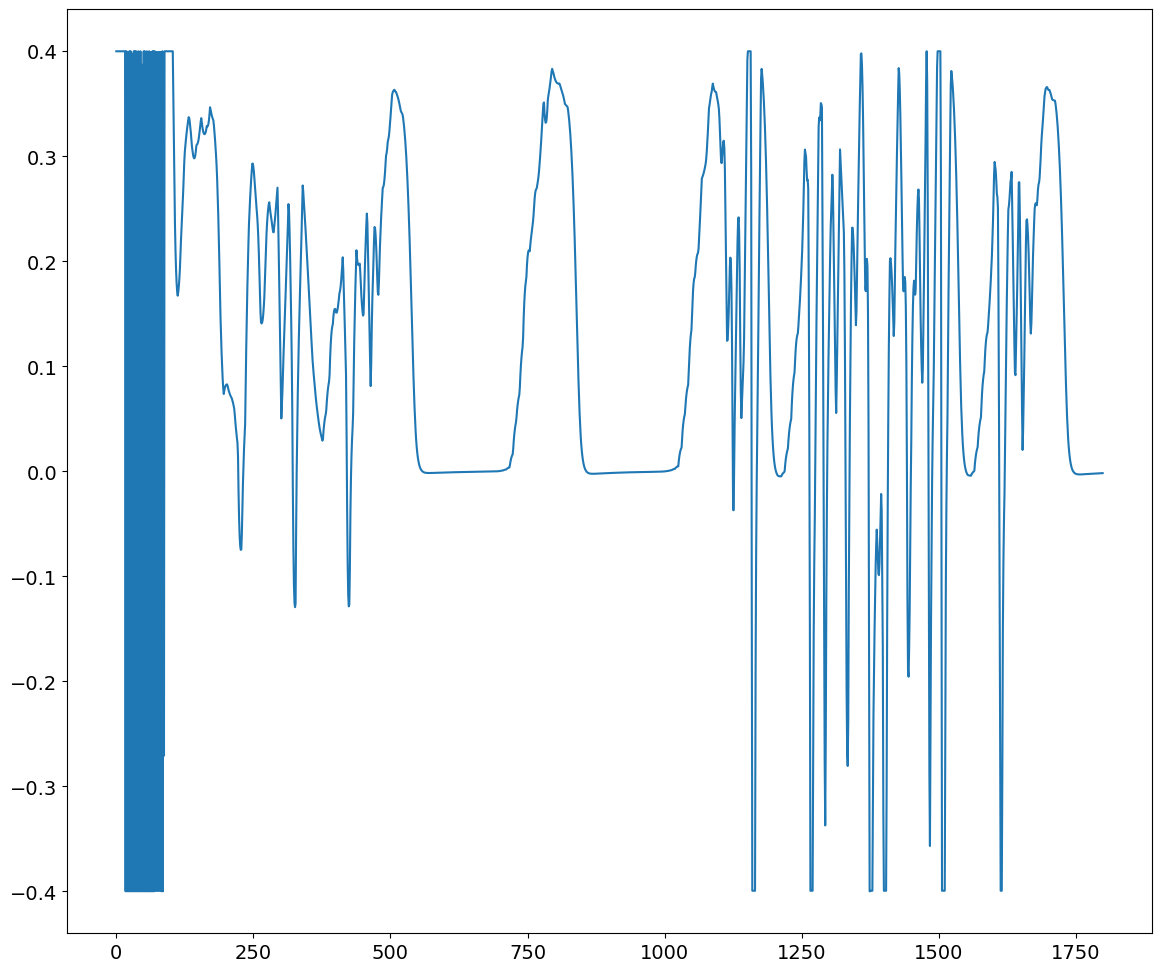

### PLOTTING SLACK ###


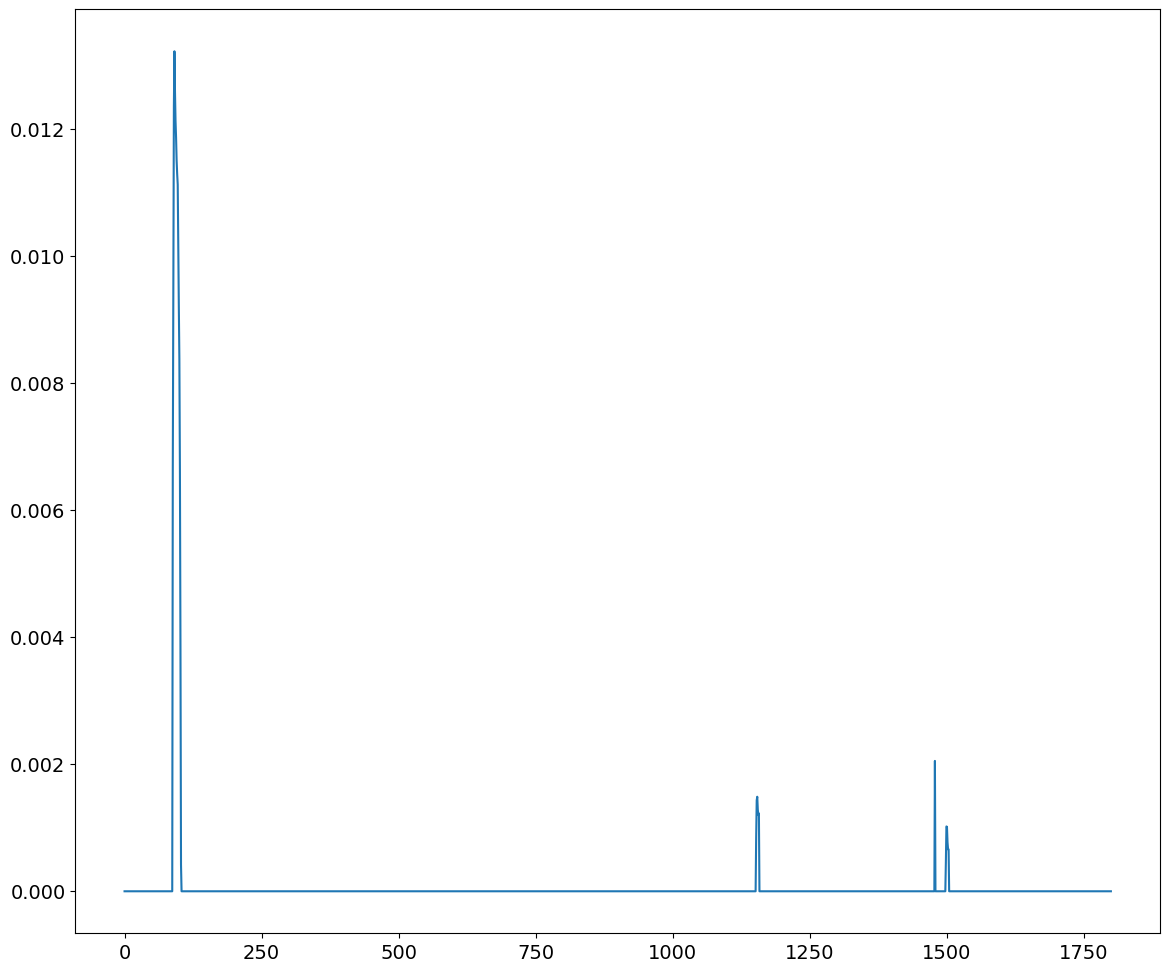

### PLOTTING CBVF TRAJECTORY ###


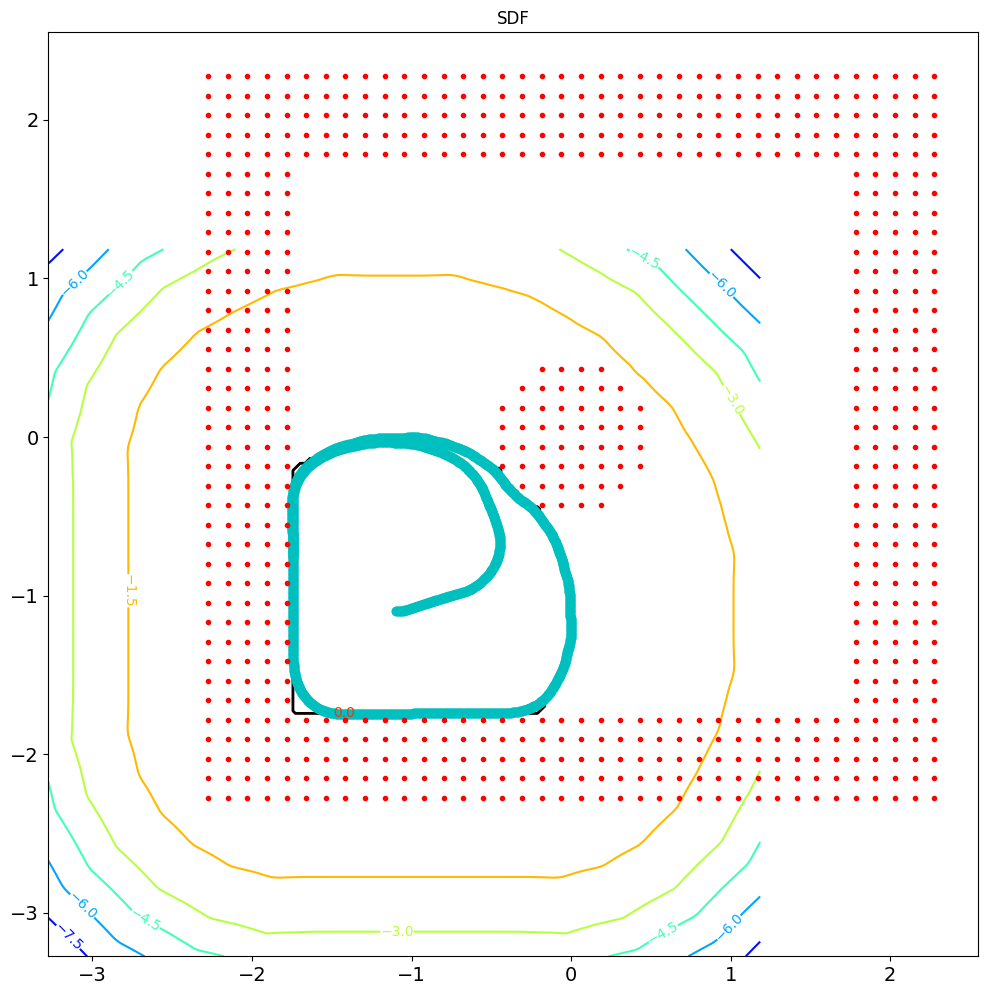

percent violation: 0.012777777777777779
new position is [-1.7446793  -0.75796896 11.001819  ]
new time is 180
V is now -0.004556084


ValueError: too many values to unpack (expected 2)

In [105]:
########################
### Safe Exploration ###
########################

a.pos = np.array([init_x, init_y, init_theta])

targets   = [np.array([1, -1,       0]),
             np.array([1, -1,       0]),
             np.array([1,  1, np.pi/2]),
             np.array([1,  1, np.pi/2])]
#targets   = None

for i in range(N):
    ######################
    ### Go to boundary ###
    ######################
    
    prev_pos = a.pos  
    if targets is not None:
        print("target:", targets[i]) 
        traj,usig = a.goto(targets[i], T=T, tend=tend, htol=tol, angle=a.pos[-1], use_scipy=False, sim_DT=DT, eps=eps, cbvf=True, grid=loc_hjb_grid, V=loc_V, 
                           bicycle=True, plot_usig=True, plot_slack=True)  
        print("dx:", np.linalg.norm(a.pos - prev_pos))
    else: 
        while np.linalg.norm(a.pos - prev_pos) <= dx:    
            target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)  
            target_angle = np.array([2 * np.pi * np.random.rand()])
            target       = np.hstack((target_pos, target_angle)) 
            while h(target, np.array(a.centers), np.array(a.thetas))[0] > 0:
                target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)
                target_angle = np.array([2 * np.pi * np.random.rand()])
                target       =  np.hstack((target_pos, target_angle)) 
            print("target:", target) 
            traj,usig = a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps) 
            print("dx:", np.linalg.norm(a.pos - prev_pos))

    ####################
    ### Collect data ###
    ####################

    # scan states 
    pts_safe, pts_unsafe, in_scan_f = a.scan(ret_in_scan_f=True)
    scan_funcs.append(in_scan_f)
    samples, gparams, is_obs_sample,\
    x2pi_samp, x0_samp = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True, bicycle=True, boundary_condition=True)
    sample_funcs.append(is_obs_sample)
    loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], thn, rx=rx, T=500, mult=mult)

    # total data 
    from data import check_obs
    all_obs_func = lambda x: check_obs(x, obs_funcs) or (check_obs(x, sample_funcs) and not check_obs(x, scan_funcs))
    out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
    obsamp_f     = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
    for x in grid:
        if obsamp_f(x):
            plt.plot(x[0], x[1], color='red', marker='o', linestyle='none')           
        else:
            plt.plot(x[0], x[1], color='black', marker='o', linestyle='none')
    plt.show()
    
    # collect quad plot data
    curr_data    = np.copy(np.vstack( ( curr_data, np.vstack((x_safe, x_buffer, x_unsafe)) ) ))
    curr_centers = np.copy(np.array(a.centers))
    curr_thetas  = np.copy(np.array(a.thetas))
    curr_traj    = np.copy(np.vstack( (curr_traj, traj) ))
    quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)
    quad_plot_args.append((i+1, curr_centers, curr_thetas, curr_data))

    data_safe   = union(data_safe, np.vstack((x_buffer, x_safe)))
    data_unsafe = difference(union(data_unsafe, x_unsafe), data_safe)

    all_C = union(all_C, C)
    plot_angle_data(all_C, grid, obs_dict, spacing, safe=data_safe, unsafe=data_unsafe, title="ALL DATA")

final_pos = np.copy(a.pos)
quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)

In [ ]:
#vmin, vmax = loc_V.min(), loc_V.max()
#levels = np.linspace(round(vmin), round(vmax), 10*(round(vmax) - round(vmin) + 1))
X = np.linspace(lo[0], hi[0], n[0])
Y = np.linspace(lo[1], hi[1], n[1])
Th = np.linspace(0, 2*np.pi, thn, endpoint=True)
hvals = np.empty((n[0], n[1], thn))
h = get_h_curr(a)
for i, x, in enumerate(X):
    for j, y in enumerate(Y):
        for k, th in enumerate(Th):
            hvals[i, j, k] = h(jnp.array([x, y, th]))[0]
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation

In [ ]:
#######################################
### Sequential plot of learned CBFs ###
#######################################

fig = plt.figure(figsize=(15, 15))
axs = [fig.add_subplot(2,2,i+1) for i in range(4)]

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal') 
    
fig.subplots_adjust(wspace=0, hspace=0)

for i, args in enumerate(quad_plot_args):
    quad_plot(a, axs[i], args[0], args[1], args[2], args[3], args[4], grid, obs_dict)
plt.show()

In [ ]:
##################################################
### Learn a single CBF from all data collected ###
##################################################

n_safe = len(pts_safe)
all_obs_func = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
gparams = get_gparams(np.vstack((data_safe, data_unsafe)), hjb_grid)
loc_V, loc_hjb_grid = a.get_local_V(gparams, all_obs_func, thn, rx=None, out_func=out_func, T=500, mult=mult)
print("number of gridpoints:", loc_hjb_grid.states.flatten().shape)
all_x_buffer, all_x_safe = a.make_buffer(data_safe, int(nm * n_safe), pct, bicycle=True) 
all_u_safe = hjb_controls_parallel(a, all_x_safe, loc_hjb_grid, loc_V, verbose=True)
if x_buffer.shape[0] != 0:
    all_u_buffer = hjb_controls_parallel(a, all_x_buffer, loc_hjb_grid, loc_V)
else:
    all_u_buffer = np.array([])
all_theta = np.array(clarabel_solve_cbf(a, all_x_safe, all_u_safe, all_x_buffer, all_u_buffer, data_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, centers=all_C))
h_max = plot_cbf(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...], angle=a.pos[-1], obstacles=obstacles)
_plot_angles(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...], grid, hjb_grid, obs_dict)

In [ ]:
#############################
### Plot velocity curves ####
#############################
import copy

a2 = copy.copy(a)
a2.thetas = [all_theta]
a2.centers= [all_C]

start_pos = np.array([-1.2 ,-1, 0])
target    = np.array([1, 0, np.pi])
a.pos = start_pos
a2.pos= start_pos

DT   = 0.001
tol  = 0.1
tend = 30
T    = 0.1
traj ,usig = a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps)  
traj2,usig2= a2.goto(target, T=T, tend=tend, tol=tol, angle=a2.pos[-1], manual=True, DT=DT, eps=eps)  


v1 = np.linalg.norm(np.vstack((traj[1:, :-1],np.array([0,0])))  - traj, axis=1)/DT
v2 = np.linalg.norm(np.vstack((traj2[1:,:-1],np.array([0,0])))  - traj2, axis=1)/DT
plt.plot(v1[:-1], color="red", label="max of local cbfs")
plt.plot(v2[:-1], color="blue", label="baseline")
plt.ylabel("velocity")
plt.xlabel("time")
plt.legend()
plt.show()

plt.plot(usig , color="red" , label="max cbf, |u|" )
plt.plot(usig2, color="blue", label="baseline, |u|")
plt.ylabel("norm of control")
plt.xlabel("time")
plt.legend()
plt.show()

In [ ]:
X = np.linspace(lo[0], hi[0], n[0])
Y = np.linspace(lo[1], hi[1], n[1])
Th = np.linspace(0, 2*np.pi, thn, endpoint=True)
hvals = np.empty((n[0], n[1], thn))
h = get_h_curr(a2)
for i, x, in enumerate(X):
    for j, y in enumerate(Y):
        for k, th in enumerate(Th):
            hvals[i, j, k] = h(jnp.array([x, y, th]))[0]
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation